In [1]:
# !pip install xgboost

In [2]:
# !conda install -c conda-forge jupyterlab=4.0.7 notebook=7.0.6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay

import random

import xgboost as xgb
from xgboost import XGBClassifier

### Текущие задачи

2024 ***

фичи по классам трейдеров

Готово:

1 сделать график LOB 

2 сделать сид 

3 сделать контейнер для выполненых сделок в классе OrderList

4 сделать фичу transaction volume

5 добавить сид трейдерам

### My simulation

In [2]:
from AgentBasedModel import *
from AgentBasedModel.extra import *
from AgentBasedModel.visualization import *
from AgentBasedModel.visualization.other import plot_book
from AgentBasedModel.visualization.other import plot_full_book
from AgentBasedModel.visualization.trader import *
from random import randint

# from AgentBasedModel.exchange import Asset

# Feature extraction

Needed features - (Bid-Ask Spread + , Bid-Ask Volume Imbalance + , Signed Transaction Volume + )

In [3]:
def get_order_book(info, exchange_id):
    return info.exchanges[exchange_id].order_book

def get_bids(info, exchange_id):
    return get_order_book(info, exchange_id)['bid'].to_list()

def get_asks(info, exchange_id):
    return get_order_book(info, exchange_id)['ask'].to_list()

def get_spread(info, exchange_id):
    
    """
    getting bid-ask spread as a difference between best ask and bid prices 
    for every time tick in a simulation
    """
    
    bid_ask_spread = info.spreads[exchange_id]
    spreads = pd.DataFrame(bid_ask_spread, columns=['bid', 'ask'])
    return list(map(lambda x: round(x, 4), (spreads['ask'] - spreads['bid'])))

def get_bid_ask_volume_imbalance(info, exchange_id, depth=1000, class_division=False):
    
    """
    Bid-Ask Volume Imbalance: A signed quantity indicating the number of shares at the bid
    minus the number of shares at the ask in the current order books.
    """
    
    bids = get_bids(info, exchange_id)
    asks = get_asks(info, exchange_id)
    
    bids_qty = pd.DataFrame(bids)
    asks_qty = pd.DataFrame(asks)
    
    bids_qty['trader_link'] = bids_qty['trader_link'].apply(lambda x: x.type if x else None)
    asks_qty['trader_link'] = asks_qty['trader_link'].apply(lambda x: x.type if x else None)

    bids_level = bids_qty['price'].unique()
    bids_level = bids_level[min(depth, len(bids_level) - 1)]
    
    asks_level = asks_qty['price'].unique()
    asks_level = asks_level[min(depth, len(asks_level) - 1)]
    
    bids_qty = bids_qty[bids_qty.price >= bids_level]
    asks_qty = asks_qty[asks_qty.price <= asks_level]
    
    if class_division:
        
        bid_ask_volume_imbalance_list = {}
        
        all_bids_qty = bids_qty['qty'].sum()
        all_asks_qty = asks_qty['qty'].sum()
        
        for trader_class in bids_qty['trader_link'].unique():
            if trader_class:
                cur_bids = bids_qty[bids_qty['trader_link'] == trader_class]['qty'].sum()
                cur_asks = asks_qty[asks_qty['trader_link'] == trader_class]['qty'].sum()

                bid_ask_volume_imbalance_list[trader_class] = (cur_bids - cur_asks)/(all_bids_qty + all_asks_qty)
                
            else:
                cur_bids = bids_qty[bids_qty['trader_link'].isnull()]['qty'].sum()
                cur_asks = asks_qty[asks_qty['trader_link'].isnull()]['qty'].sum()

                bid_ask_volume_imbalance_list[trader_class] = (cur_bids - cur_asks)/(all_bids_qty + all_asks_qty)
            
        return bid_ask_volume_imbalance_list
    
    else:
        bids_qty = bids_qty['qty'].sum()
        asks_qty = asks_qty['qty'].sum()
    
        return (bids_qty - asks_qty)/(bids_qty + asks_qty)

def get_transaction_volume(info, exchange_id, limit=15):
    
    """
    Signed Transaction Volume: A signed quantity indicating the number of shares bought in the
    last 15 seconds minus the number of shares sold in the last 15 seconds.
    """
    
    transactions = pd.DataFrame(info.exchanges[exchange_id].transactions.transactions, 
                                columns=['time', 'price', 'quantity', 'side', 'trader_link'])
    
    time_values = sorted(transactions['time'].unique())
    
    limit = min(limit, len(time_values))
    
    if limit == 0:
        return 0
    
    transactions = transactions[transactions['time'] >= time_values[-limit]]

    total_buy = transactions[transactions['side'] == 'bid']['quantity'].sum()      # fulfilled bid orders - buy
    total_sell = transactions[transactions['side'] == 'ask']['quantity'].sum()     # fulfilled ask orders - sell
    
    return (total_buy - total_sell) / (total_buy + total_sell)

def get_all_transaction_volume(info, exchange_id, limit=15):
    
    """
    Signed Transaction Volume: A signed quantity indicating the number of shares bought in the
    last 15 seconds minus the number of shares sold in the last 15 seconds.
    """
    
    transactions = pd.DataFrame(info.exchanges[exchange_id].transactions.transactions, 
                                columns=['time', 'price', 'quantity', 'side', 'trader_link'])
    
    time_values = sorted(transactions['time'].unique())
    
    limit = min(limit, len(time_values))
    
    if limit == 0:
        return 0
    
    transactions = transactions[transactions['time'] >= time_values[-limit]]

    total_buy = transactions[transactions['side'] == 'bid']['quantity'].sum()      # fulfilled bid orders - buy
    total_sell = transactions[transactions['side'] == 'ask']['quantity'].sum()     # fulfilled ask orders - sell
    
    return (total_buy + total_sell)

In [4]:
"""
0 - feature, посмотреть аномалии по группам
1 - сгенерить данные (1 конфиг) соотнести качество

"""

'\n0 - feature, посмотреть аномалии по группам\n1 - сгенерить данные (1 конфиг) соотнести качество\n\n'

In [5]:
def simulation_with_data(simulator, exchange_id, n, limit=15, random_state=None, 
                         bid_ask_volume_imbalance_window = [1, 3, 5, 10], sign_transaction_volume_window = [1, 5, 10, 20],
                         class_division=False):
    
    feature_list = []
        
    if random_state:
        random.seed(random_state)
    
    for i in tqdm(range(n)):
        
        feature_list.append([])
        
        info = simulator.info
        
#         random.seed(random_state)
#         print(random.random())
        
        simulator.simulate(1, silent=True)
        
        col_names = []
        
        
        for w in bid_ask_volume_imbalance_window:
            
            bid_ask_volume_imbalance_w = get_bid_ask_volume_imbalance(info, exchange_id, depth=w, class_division=class_division)
            
            if class_division:
                
                present_classes = set(list(map(lambda x: x.type, simulator.traders)))
                current_keys = bid_ask_volume_imbalance_w.keys()
                
                for cls in present_classes:
                    
                    if cls in current_keys:
                        feature_list[i].append(bid_ask_volume_imbalance_w[cls])
                        col_names.append(f"bid_ask_volume_imbalance_{cls.replace(' ', '_')}_{w}")
                    else:
                        feature_list[i].append(0)
                        col_names.append(f"bid_ask_volume_imbalance_{cls.replace(' ', '_')}_{w}")                        
            
            else:
                feature_list[i].append(bid_ask_volume_imbalance_w)
                col_names.append(f"bid_ask_volume_imbalance_{w}")
        
        for w in sign_transaction_volume_window:
            
            sign_transaction_volume_w = get_transaction_volume(info, exchange_id, limit=w)
            
            feature_list[i].append(sign_transaction_volume_w)
            col_names.append(f"sign_transaction_volume_{w}")
        
        feature_list[i].append(get_all_transaction_volume(info, exchange_id, limit=1))
        col_names.append("all_transaction_volume_1")
    
#     print(col_names)
    result_df = pd.DataFrame(feature_list, columns=col_names)

        
    bid_ask_spread = get_spread(info, exchange_id)
    
    last_vals = len(bid_ask_spread)
    
    bid_ask_spread = bid_ask_spread[last_vals - n:]
    
    result_df['bid_ask_spread'] = bid_ask_spread
    result_df['dividends'] = info.dividends[exchange_id][last_vals - n:] 
    result_df['price'] = info.prices[exchange_id][last_vals - n:]
    result_df['dividends_previous_divided'] = (result_df['dividends'] / (result_df['price'] * simulator.exchanges[0].risk_free_rate).shift(1))
    
    fundamental_value_data = info.fundamental_value(exchange_id)
    n_past_iterations = len(fundamental_value_data)
    
    result_df['fundamental_v'] = fundamental_value_data[n_past_iterations - n:]
    
    result_df['return_1'] = ((result_df['price'] - result_df['price'].shift(1))/result_df['price']) #*100
    result_df['return_5'] = ((result_df['price'] - result_df['price'].shift(5))/result_df['price']) #*100
    result_df['return_10'] = ((result_df['price'] - result_df['price'].shift(10))/result_df['price']) #*100
    result_df['return_20'] = ((result_df['price'] - result_df['price'].shift(20))/result_df['price']) #*100
    
    return result_df

def make_graphs(data, columns):
    
    colors = ['blue', 'orange', 'green', 'crimson']
    
    n = len(columns)
    
    if len(columns) % 2 == 0:
        nrows = len(columns) // 2
    else:
        nrows = (len(columns) // 2) + 1
    
    if n == 1:
        fig1, axs1 = plt.subplots()
        
    else:
        fig1, axs1 = plt.subplots(nrows=nrows, ncols=2)
        
    fig1.tight_layout()
    
    for i in range(n):
        axs1[i//2, i%2].plot(data[columns[i]], label=columns[i], color=plt.cm.tab10(i)) #color=colors[i%4])
        axs1[i//2, i%2].legend()
    
    plt.show()

In [6]:
def make_many_simulations(n_sim=5, n_iter=100, risk_free_rate=0.05, price=100, 
                          dividend=None, random_state=None, silent=False, market_agents=[6, 6, 6, 1],
                          class_division=False, sim_return=False, mm_softlimit=100):
    
    if not dividend:
        dividend = price * risk_free_rate
    
    risk_free_rate = risk_free_rate
    price = price
    dividend = dividend
    
    resulting_df = []
    
    simulators=[]
    
    for i in range(n_sim):
        
        random.seed(random_state)
        
        # print(random_state)
    
        assets = [Stock(dividend)]

        simple_exchange = ExchangeAgent(assets[0], risk_free_rate, mean=price)
        
        simple_traders = [
            *[Random(simple_exchange) for _ in range(market_agents[0])],
            *[Chartist1D(simple_exchange) for _ in range(market_agents[1])],
            *[Fundamentalist(simple_exchange) for _ in range(market_agents[2])],
            *[MarketMaker1D(simple_exchange, softlimit = mm_softlimit) for _ in range(market_agents[3])]
        ]
        
        # *[Universalist(market=simple_exchange) for _ in range(100)],

        simple_sim = Simulator(**{
            'assets': [assets[0]],
            'exchanges': [simple_exchange],
            'traders': simple_traders
        })
        
        exchange_id = simple_exchange.id
        
        simulators.append(simple_sim)
        
        # bug report
#         if i == 0:
#             features_simulation_data = simulation_with_data(simple_sim, exchange_id, n_iter, random_state=None)
#             make_graphs(features_simulation_data, features_simulation_data.columns)
#             continue
        
#         try:

        features_simulation_data = simulation_with_data(simple_sim, exchange_id, n_iter, random_state=None, class_division=class_division)
        print(f"--step {i + 1} of simulation results with random state {random_state}--")

        if not silent:
            make_graphs(features_simulation_data, features_simulation_data.columns)

        resulting_df.append(features_simulation_data)
        
        if random_state:
            random_state = (random_state + (i + 1 + (i + 2)**2) + 100 * (i + 3)) % 11221
        
#         except:
#             print('no orders bla bla')
#             print(random_state)
#             return
#     plot_book(simple_sim.info, exchange_id)
    
    if sim_return:
        return resulting_df, simulators
    else:
        return resulting_df

In [7]:
def make_graphs_column(data, columns, figsize=[8, 10]):
    
    colors = ['blue', 'orange', 'green', 'crimson']
    
    n = len(columns)
    
    fig1, axs1 = plt.subplots(nrows=n, ncols=1, figsize=figsize)
        
    fig1.tight_layout()
    
    for i in range(n):
        axs1[i].plot(data[columns[i]], label=columns[i], color=plt.cm.tab10(i)) #color=colors[i%4])
        axs1[i].legend()
    
    plt.show()

In [8]:
# посмотреть средние фичей для длинных траекторий

# Experiments

In [11]:
more_market_agents=[40, 40, 40, 1]

In [12]:
mmm_data, sims = make_many_simulations(n_sim=1, n_iter=100, random_state=911, silent=True, market_agents=more_market_agents, sim_return=True)

100%|██████████| 100/100 [00:02<00:00, 38.43it/s]

--step 1 of simulation results with random state 911--


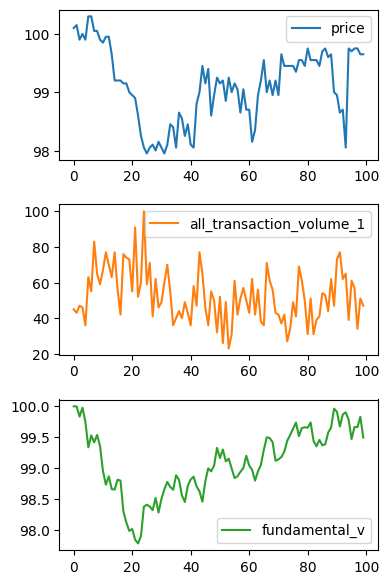

In [13]:
make_graphs_column(mmm_data[0], ['price', 'all_transaction_volume_1', 'fundamental_v'], figsize=[4, 6])

In [14]:
mmm_data_30, sims_30 = make_many_simulations(n_sim=1, n_iter=62, random_state=911, silent=True, market_agents=more_market_agents, sim_return=True)

100%|██████████| 62/62 [00:01<00:00, 38.55it/s]

--step 1 of simulation results with random state 911--


97.8 8.5
98.9 189.8


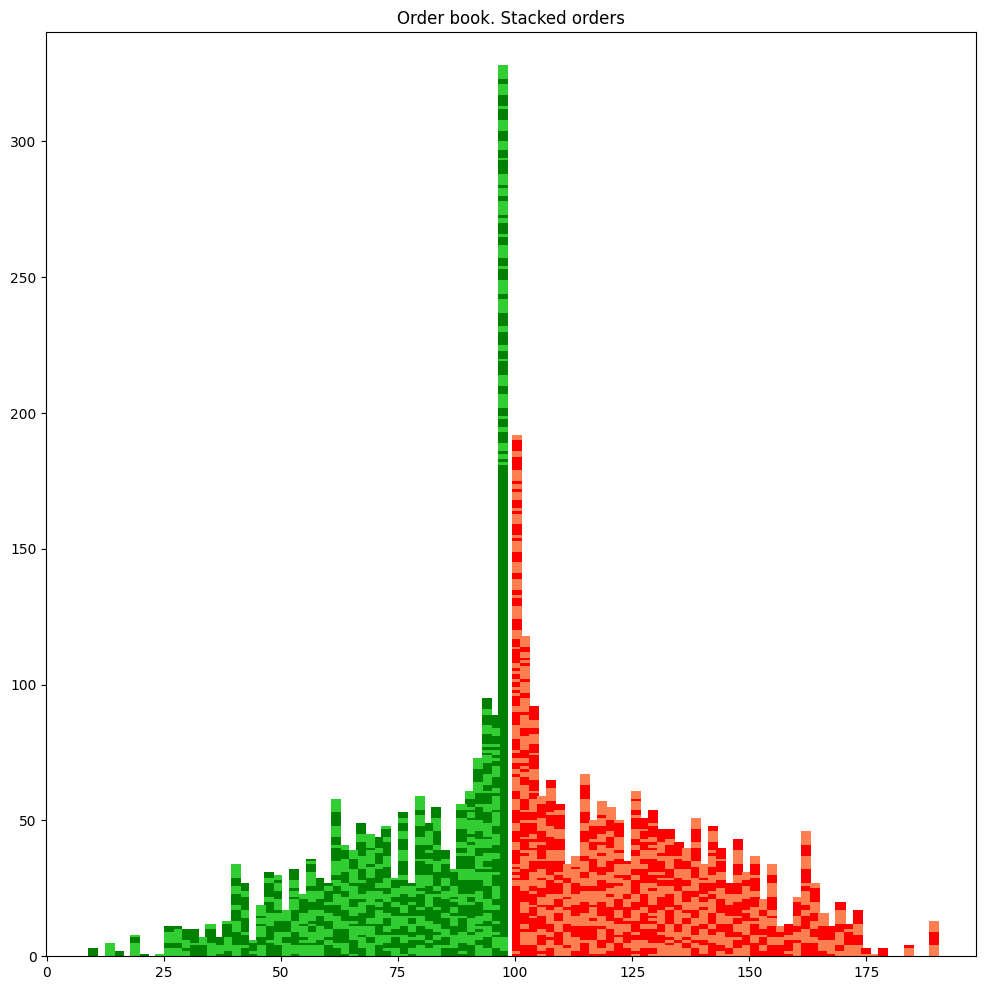

In [15]:
ex_id = list(sims_30[0].info.exchanges.keys())[0]

plot_full_book(sims_30[0].info, ex_id, bins=50)

In [18]:
mmm_data_30[0].head()

bid_ask_volume_imbalance_1  bid_ask_volume_imbalance_3  \
0                   -0.023256                   -0.004367   
1                    0.071038                   -0.004651   
2                    0.368421                   -0.020000   
3                   -0.049505                   -0.032864   
4                   -0.877193                   -0.086758   

   bid_ask_volume_imbalance_5  bid_ask_volume_imbalance_10  \
0                    0.028112                     0.027397   
1                    0.025641                     0.024911   
2                   -0.047619                     0.021898   
3                   -0.045267                    -0.071429   
4                   -0.130081                    -0.054313   

   sign_transaction_volume_1  sign_transaction_volume_5  \
0                   0.155556                   0.155556   
1                   0.162791                   0.159091   
2                  -0.234043                   0.022222   
3                   0.130435                   0.049724   
4                   0.166667                   0.069124   

   sign_transaction_volume_10  sign_transaction_volume_20  \
0                    0.155556                    0.155556   
1                    0.159091                    0.159091   
2                    0.022222                    0.022222   
3                    0.049724                    0.049724   
4                    0.069124                    0.069124   

   all_transaction_volume_1  bid_ask_spread  dividends   price  \
0                        45             0.2   5.000000  100.10   
1                        43             0.9   5.000000  100.15   
2                        47             0.6   4.991706   99.90   
3                        46             0.2   4.998938  100.00   
4                        36             0.4   4.987398   99.90   

   dividends_previous_divided  fundamental_v  return_1  return_5  return_10  \
0                         NaN     100.000000       NaN       NaN        NaN   
1                    0.999001     100.000000  0.000499       NaN        NaN   
2                    0.996846      99.834123 -0.002503       NaN        NaN   
3                    1.000788      99.978765  0.001000       NaN        NaN   
4                    0.997480      99.747964 -0.001001       NaN        NaN   

   return_20  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

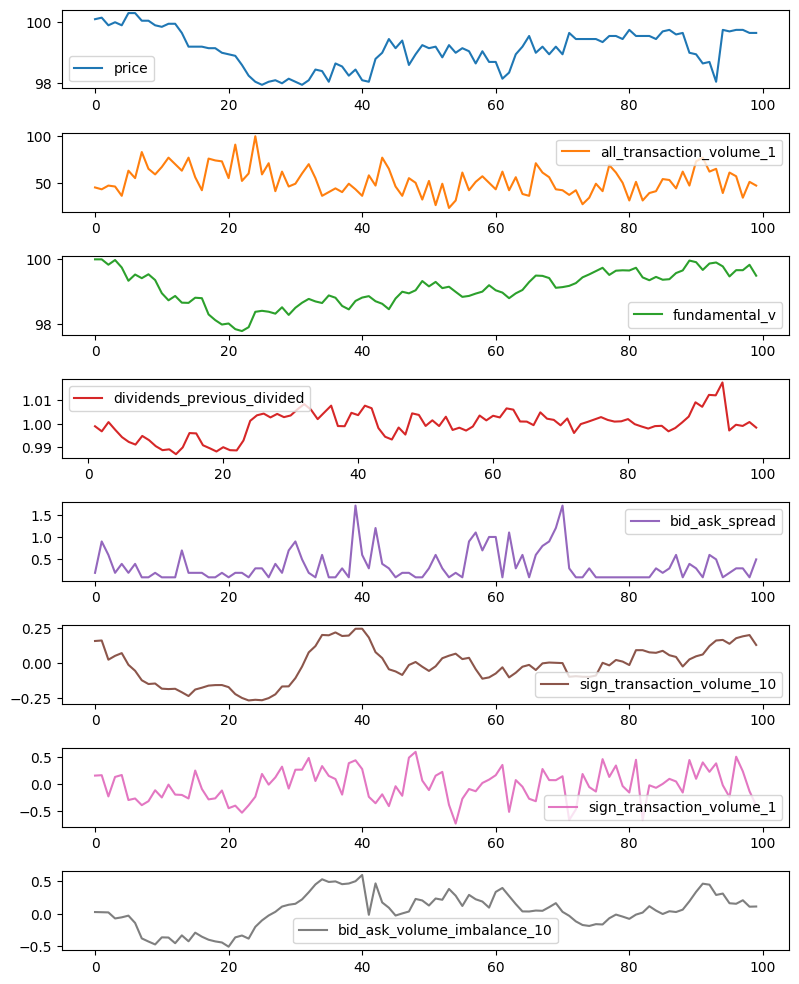

In [17]:
make_graphs_column(mmm_data[0], ['price', 'all_transaction_volume_1', 'fundamental_v', 'dividends_previous_divided', 'bid_ask_spread', 'sign_transaction_volume_10', 'sign_transaction_volume_1', 'bid_ask_volume_imbalance_10'])

In [18]:
ex_id = list(sims[0].info.exchanges.keys())[0]

transactions = pd.DataFrame(sims[0].info.exchanges[ex_id].transactions.transactions, 
                                columns=['time', 'price', 'quantity', 'side', 'trader_link'])

In [19]:
print(sims[0].info.exchanges[ex_id].order_book['ask'].to_list()[:5])

[{'price': 99.7, 'qty': 48, 'order_type': 'ask', 'trader_link': Trader120}, {'price': 99.7, 'qty': 3, 'order_type': 'ask', 'trader_link': Trader76}, {'price': 99.8, 'qty': 3, 'order_type': 'ask', 'trader_link': Trader20}, {'price': 99.8, 'qty': 1, 'order_type': 'ask', 'trader_link': Trader74}, {'price': 99.9, 'qty': 2, 'order_type': 'ask', 'trader_link': Trader62}]


In [20]:
# print(sims[0].info.exchanges[ex_id].order_book['bid'].to_list()[:5])

In [21]:
transactions[transactions['time']==37]

time  price  quantity side                 trader_link
1103    37   98.4         1  ask           Trader21 (Random)
1104    37   98.4         3  ask         Trader74 (Chartist)
1105    37   98.3         1  ask         Trader74 (Chartist)
1106    37   98.8         2  bid         Trader65 (Chartist)
1107    37   98.8         1  bid         Trader65 (Chartist)
1108    37   98.9         1  bid         Trader65 (Chartist)
1109    37   98.7         2  ask         Trader42 (Chartist)
1110    37   98.3         1  ask         Trader42 (Chartist)
1111    37   98.3         2  ask         Trader42 (Chartist)
1112    37   98.9         3  bid           Trader27 (Random)
1113    37   98.9         1  bid           Trader27 (Random)
1114    37   98.3         1  ask           Trader19 (Random)
1115    37   98.3         1  ask           Trader32 (Random)
1116    37   98.4         1  bid  Trader119 (Fundamentalist)
1117    37   98.3         1  ask         Trader48 (Chartist)
1118    37   98.3         1  ask         Trader48 (Chartist)
1119    37   98.3         4  ask         Trader60 (Chartist)
1120    37   98.2         1  ask         Trader60 (Chartist)
1121    37   98.9         2  bid            Trader3 (Random)
1122    37   98.6         1  ask            Trader1 (Random)
1123    37   98.9         3  bid           Trader12 (Random)
1124    37   98.6         1  ask         Trader53 (Chartist)
1125    37   99.0         1  bid           Trader31 (Random)
1126    37   99.0         1  bid         Trader63 (Chartist)
1127    37   98.6         2  ask         Trader49 (Chartist)
1128    37   98.6         1  ask  Trader106 (Fundamentalist)

In [22]:
# for trader in sims[0].traders:
#     print(trader.cash, trader.assets, 98.6 * trader.assets + trader.cash, trader, sep='\t')

In [23]:
# plot_liquidity(sims[0].info, ex_id)

99.4 8.5
99.7 189.8


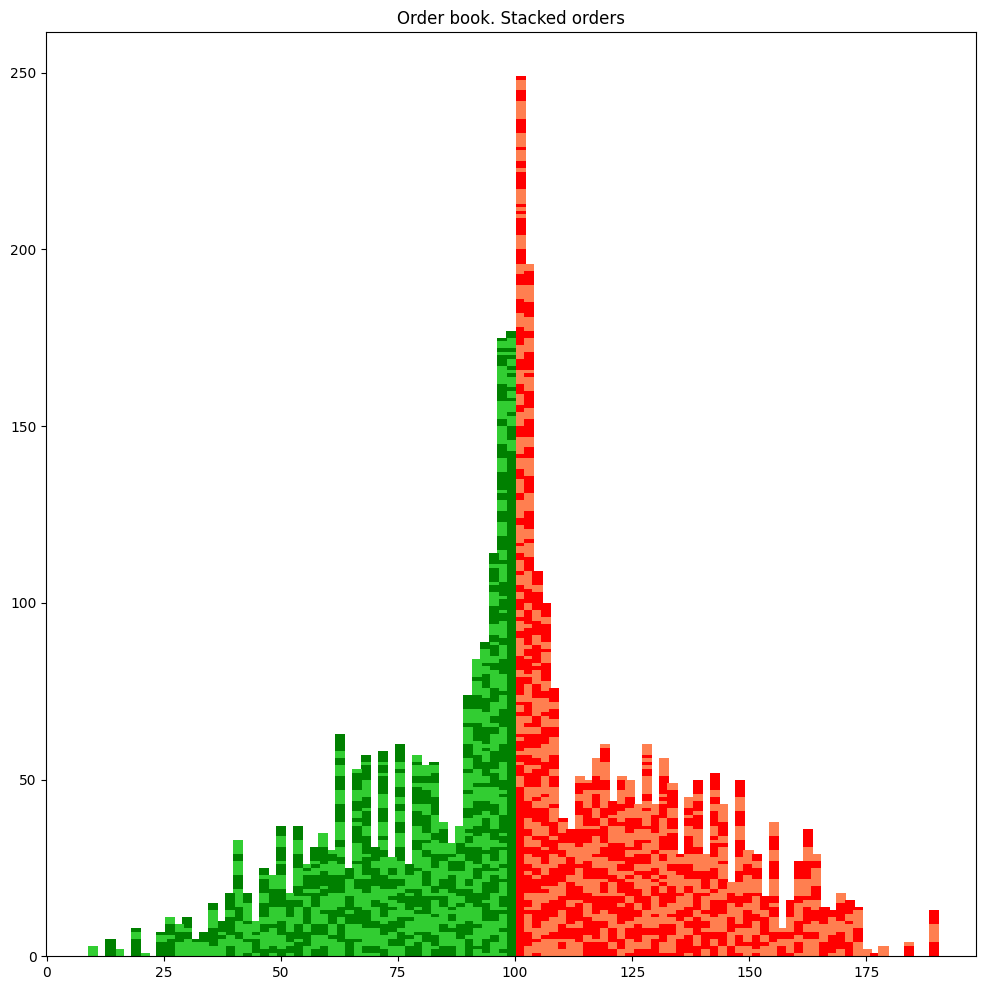

In [24]:
plot_full_book(sims[0].info, ex_id, bins=50)

# Trying to set larger softlimit to the market maker

In [29]:
mm_softline_data, sims = make_many_simulations(n_sim=1, n_iter=38, random_state=911, silent=True, market_agents=more_market_agents, sim_return=True, mm_softlimit=30)

100%|██████████| 38/38 [00:00<00:00, 42.47it/s]

--step 1 of simulation results with random state 911--


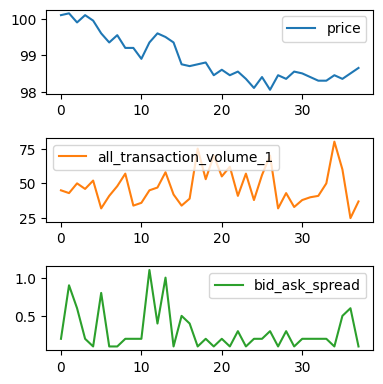

In [30]:
make_graphs_column(mm_softline_data[0], ['price', 'all_transaction_volume_1', 'bid_ask_spread'], figsize=[4, 4])

98.3 8.5
98.5 189.8


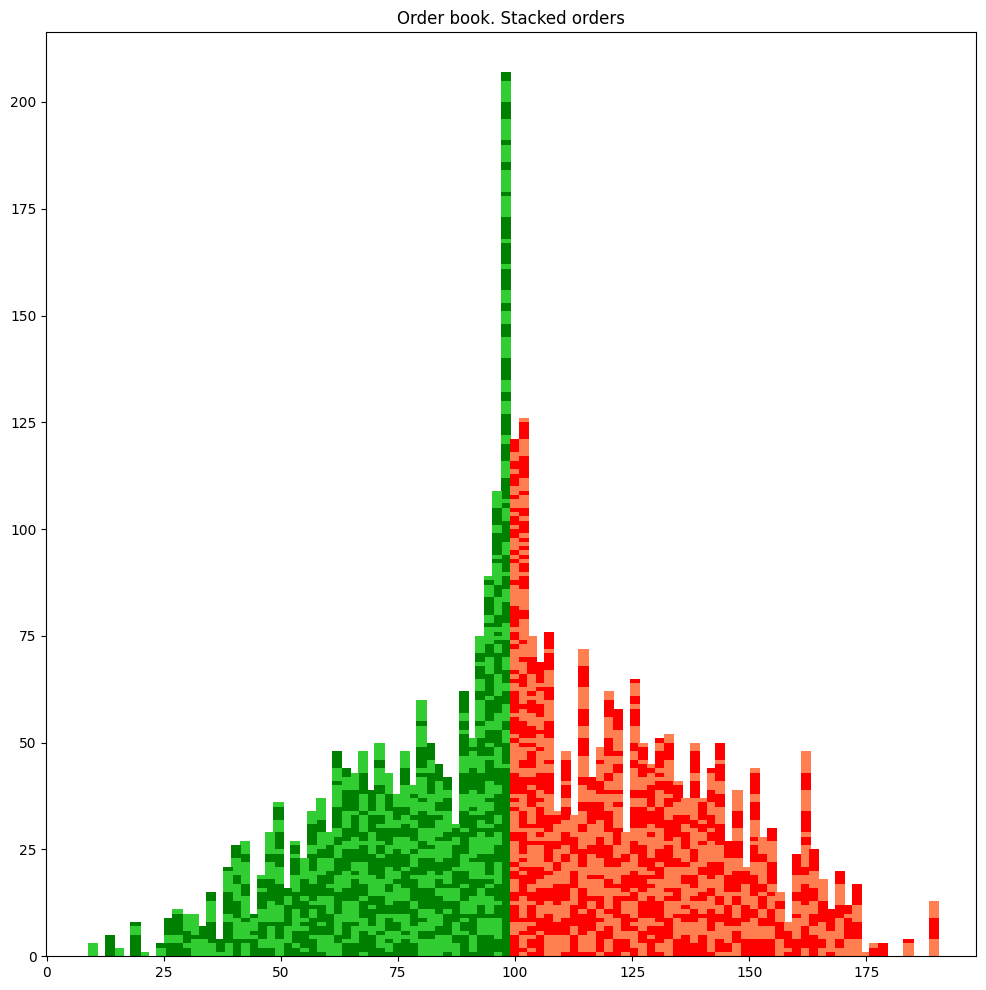

In [31]:
ex_id = list(sims[0].info.exchanges.keys())[0]
plot_full_book(sims[0].info, ex_id, bins=50)

In [32]:
print(sims[0].info.exchanges[ex_id].order_book['ask'].to_list()[:5])

[{'price': 98.5, 'qty': 5, 'order_type': 'ask', 'trader_link': Trader431}, {'price': 98.7, 'qty': 3, 'order_type': 'ask', 'trader_link': Trader408}, {'price': 98.8, 'qty': 4, 'order_type': 'ask', 'trader_link': Trader411}, {'price': 98.9, 'qty': 1, 'order_type': 'ask', 'trader_link': Trader465}, {'price': 99.0, 'qty': 2, 'order_type': 'ask', 'trader_link': Trader476}]


In [33]:
print(sims[0].info.exchanges[ex_id].order_book['bid'].to_list()[:5])

[{'price': 98.3, 'qty': 44, 'order_type': 'bid', 'trader_link': Trader483}, {'price': 97.9, 'qty': 1, 'order_type': 'bid', 'trader_link': Trader379}, {'price': 97.9, 'qty': 5, 'order_type': 'bid', 'trader_link': Trader440}, {'price': 97.9, 'qty': 3, 'order_type': 'bid', 'trader_link': Trader440}, {'price': 97.9, 'qty': 2, 'order_type': 'bid', 'trader_link': None}]


### Data simulation 

In [34]:
# 1175

In [35]:
# smol_data = make_many_simulations(n_sim=5, n_iter=250, risk_free_rate=0.05, price=200, dividend=10, random_state=1175, silent=True, class_division=False)

In [36]:
# smol_data[0].columns

In [37]:
# make_graphs(smol_data[0], ['price', 'fundamental_v', 'bid_ask_volume_imbalance_10', 'return_10', 'sign_transaction_volume_10', 'dividends'])

In [38]:
# smol_data = make_many_simulations(n_sim=1, n_iter=250, risk_free_rate=0.05, price=200, dividend=10, random_state=1175, silent=True, class_division=True)

In [39]:
# smol_data[0].head()

In [40]:
# for el in smol_data:
#     el[['price', 'fundamental_v']].plot()

In [41]:
# for el in smol_data:
#     el[['price', 'fundamental_v']].plot()
#     el[['bid_ask_volume_imbalance_Market_Maker_1']].plot()

In [42]:
# посмотреть на sign_transaction_volume по классам

# Data Generation

In [11]:
random_state_for_simulations = 999

market_agents=[40, 40, 40, 1]
market_agents_no_mm=[40, 40, 40, 0]

In [12]:
# huge_data = make_many_simulations(n_sim=200, n_iter=250, risk_free_rate=0.05, price=200, dividend=10, random_state=random_state_for_simulations, silent=True, market_agents=market_agents)

In [13]:
# huge_data_no_mm = make_many_simulations(n_sim=200, n_iter=250, risk_free_rate=0.05, price=200, dividend=10, random_state=random_state_for_simulations, silent=True, market_agents=market_agents_no_mm)

In [14]:
# huge_data_undervalued = make_many_simulations(n_sim=200, n_iter=250, risk_free_rate=0.05, price=181.81, dividend=10, random_state=random_state_for_simulations, silent=True, market_agents=market_agents)

In [15]:
# huge_data_undervalued_no_mm = make_many_simulations(n_sim=200, n_iter=250, risk_free_rate=0.05, price=181.81, dividend=10, random_state=random_state_for_simulations, silent=True, market_agents=market_agents_no_mm)

In [16]:
# all_data = [huge_data, huge_data_no_mm, huge_data_undervalued, huge_data_undervalued_no_mm]

In [17]:
all_data_names = ['huge_data', 'huge_data_no_mm', 'huge_data_undervalued', 'huge_data_undervalued_no_mm']

In [18]:
for i in range(4):
    result_df = pd.DataFrame()
    d = all_data[i]
    
    for smol_d in d:
        result_df = pd.concat([result_df, smol_d])
    
    result_df.to_csv(f'generated_data/{all_data_names[i]}')

NameError: name 'all_data' is not defined

### Downloading data

In [9]:
all_data_names = ['huge_data', 'huge_data_no_mm', 'huge_data_undervalued', 'huge_data_undervalued_no_mm']

In [10]:
cur_df = pd.read_csv(f'generated_data/{all_data_names[0]}')

In [11]:
separation_column = []

for i in range(cur_df.shape[0]//250):
    separation_column += [i] * 250

In [12]:
enormous_data = {}

for i in range(4):
    current_division = []
    cur_df = pd.read_csv(f'generated_data/{all_data_names[i]}').drop(['Unnamed: 0'], axis=1)
    cur_df['sep_col'] = separation_column
    
    for j in range(cur_df.shape[0] // 250):
        current_division.append(cur_df[cur_df['sep_col'] == j].reset_index(drop=True).drop(['sep_col'], axis=1))
    
    
    enormous_data[all_data_names[i]] = current_division

In [13]:
huge_data = enormous_data['huge_data']
huge_data_no_mm = enormous_data['huge_data_no_mm']
huge_data_undervalued = enormous_data['huge_data_undervalued']
huge_data_undervalued_no_mm = enormous_data['huge_data_undervalued_no_mm']

In [14]:
all_data = [huge_data, huge_data_no_mm, huge_data_undervalued, huge_data_undervalued_no_mm]
all_data_names = ['huge_data', 'huge_data_no_mm', 'huge_data_undervalued', 'huge_data_undervalued_no_mm']

### Mean-variance analysis of trajectories

In [15]:
len(huge_data)

200

In [18]:
huge_data[0].mean()['bid_ask_volume_imbalance_1']

-0.10157732167152261

In [68]:
def find_mean_variance(trajectories, variable):
    n_traj = len(trajectories)
    n_time = len(trajectories[0])
    
    all_trajectories = pd.DataFrame()
    
    rename={}
    
    for i in range(n_traj):
        all_trajectories = pd.concat([all_trajectories, trajectories[i][variable]], axis=1)
#         all_trajectories[f"{variable}_trajectory_{i+1}"] = trajectories[i][variable]
        
        rename[variable] = f"{variable}_trajectory_{i+1}"
        
        all_trajectories = all_trajectories.rename(mapper=rename, axis=1)
    
    all_trajectories = all_trajectories.T
    
    mean_vector = []
    variance_vector = []
    
    for i in range(all_trajectories.shape[1]):
        mean_vector.append((all_trajectories[i]).mean())
        variance_vector.append((all_trajectories[i]).var())
    
    return mean_vector, variance_vector

In [82]:
def draw_mean_variance(data, variable, x=250):
    
    mean_variance = find_mean_variance(data, variable)

    fig, ax = plt.subplots()

    x = range(x)
    y = mean_variance[0]


    lower_part = y - (1.96 * np.array(mean_variance[1]) ** 0.5)
    upper_part = y + (1.96 * np.array(mean_variance[1]) ** 0.5)

    ax.plot(x,y)
    ax.fill_between(x, lower_part, upper_part, color='b', alpha=.1)
    
    plt.show()
    
    return mean_variance

In [123]:
def find_mean_quantile(trajectories, variable, quantile):
    n_traj = len(trajectories)
    n_time = len(trajectories[0])
    
    all_trajectories = pd.DataFrame()
    
    rename={}
    
    for i in range(n_traj):
        all_trajectories = pd.concat([all_trajectories, trajectories[i][variable]], axis=1)
#         all_trajectories[f"{variable}_trajectory_{i+1}"] = trajectories[i][variable]
        
        rename[variable] = f"{variable}_trajectory_{i+1}"
        
        all_trajectories = all_trajectories.rename(mapper=rename, axis=1)
    
    all_trajectories = all_trajectories.T
    
    mean_vector = []
    lower_quantile = []
    higher_quantile = []
    
    for i in range(all_trajectories.shape[1]):
        mean_vector.append((all_trajectories[i]).mean())
        lower_quantile.append(all_trajectories[i].quantile(q=(1-quantile), interpolation='lower'))
        higher_quantile.append(all_trajectories[i].quantile(q=quantile, interpolation='higher'))
    
    return mean_vector, lower_quantile, higher_quantile

In [180]:
def draw_mean_quantile(data, variable, quantile, x=250, title=None, y_lim=None):
    
    mean, lower_quantiles, higher_quantiles = find_mean_quantile(data, variable, quantile)

    fig, ax = plt.subplots()

    x = range(x)
    y = mean
    
#     if title:
#         ax.title=title
    
    ax.plot(x,y, label=title)
    
    if y_lim:
        ax.set_ylim([y_lim[0], y_lim[1]])
    
    ax.fill_between(x, lower_quantiles, higher_quantiles, color='b', alpha=.1)
    
    plt.legend()
    plt.show()
    
    return mean, lower_quantiles, higher_quantiles

In [262]:
def draw_many_mean_quantile(dataset, variable, quantile, x=250, title=None, y_lim=None):
    
    fig, ax = plt.subplots(figsize=[12, 10])
    
    colors = ['b', 'g', 'r', 'y', 'm']
    color_ind = 0
    
    x = range(x)
    
    for data in dataset:
        mean, lower_quantiles, higher_quantiles = find_mean_quantile(data, variable, quantile)        
        y = mean

    #     if title:
    #         ax.title=title

        ax.plot(x,y, label=title[color_ind])

        if y_lim:
            ax.set_ylim([y_lim[0], y_lim[1]])

        ax.fill_between(x, lower_quantiles, higher_quantiles, color=colors[color_ind], alpha=.05)
        
        color_ind += 1

    plt.legend()
    plt.show()

In [70]:
def draw_many_mean_variance(data, variable, labels=all_data_names):
    print(f"GRAPHS OF {variable}")
    fig, ax = plt.subplots(2, 2, figsize=(10,5))
    
    i = 0
    
    for d in data:
        mean_variance = find_mean_variance(d, variable)
        
        x = range(250)
        y = mean_variance[0]
        
        lower_part = y - (1.96 * np.array(mean_variance[1]) ** 0.5)
        upper_part = y + (1.96 * np.array(mean_variance[1]) ** 0.5)
        
        ax[int(i>1), i%2].plot(x,y, label=labels[i])
        ax[int(i>1), i%2].fill_between(x, lower_part, upper_part, color='b', alpha=.1)
        
        ax[int(i>1), i%2].legend()
        
        i+=1
    
    
    plt.show()

In [452]:
all_data_names

['huge_data',
 'huge_data_no_mm',
 'huge_data_undervalued',
 'huge_data_undervalued_no_mm']

In [457]:
all_data_names2 = ['Regular settings', 'No MM agent', 'Undervalued price', 'Undervalued price an no MM agent']

In [458]:
def draw_all_features_mean_var(data, labels=all_data_names):
    variables = data[0][0].columns
    
    for var in variables:
        draw_many_mean_variance(data, var, labels=labels)

GRAPHS OF bid_ask_volume_imbalance_1


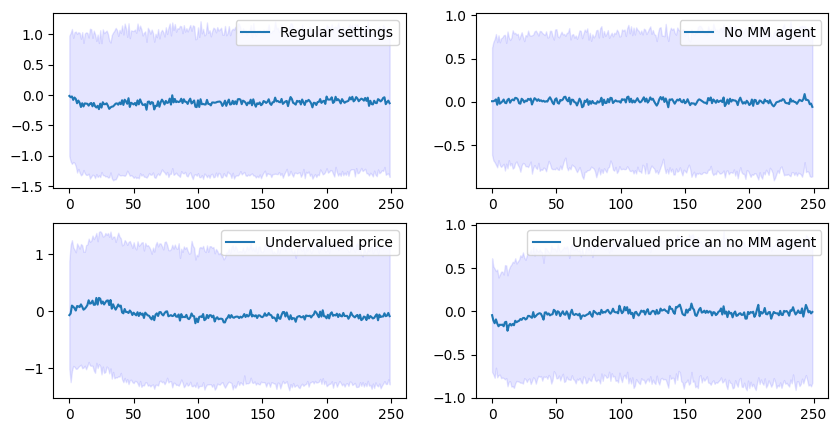

GRAPHS OF bid_ask_volume_imbalance_3


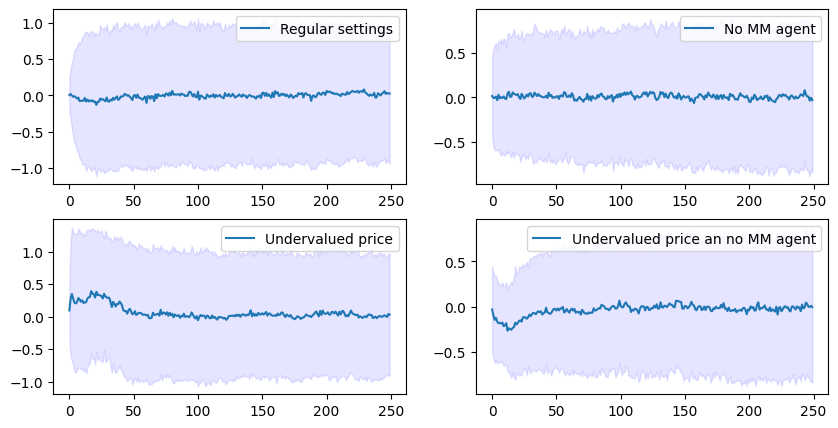

GRAPHS OF bid_ask_volume_imbalance_5


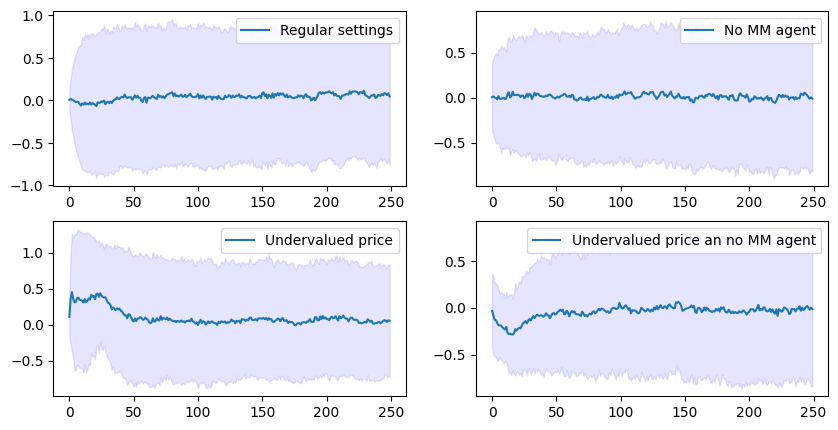

GRAPHS OF bid_ask_volume_imbalance_10


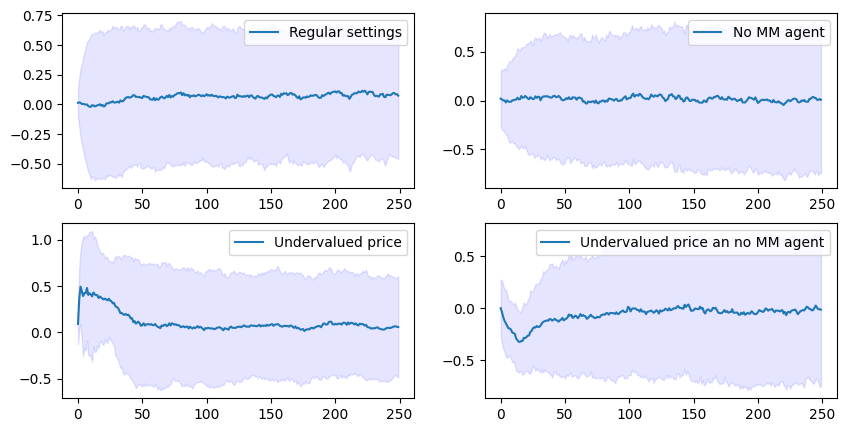

GRAPHS OF sign_transaction_volume_1


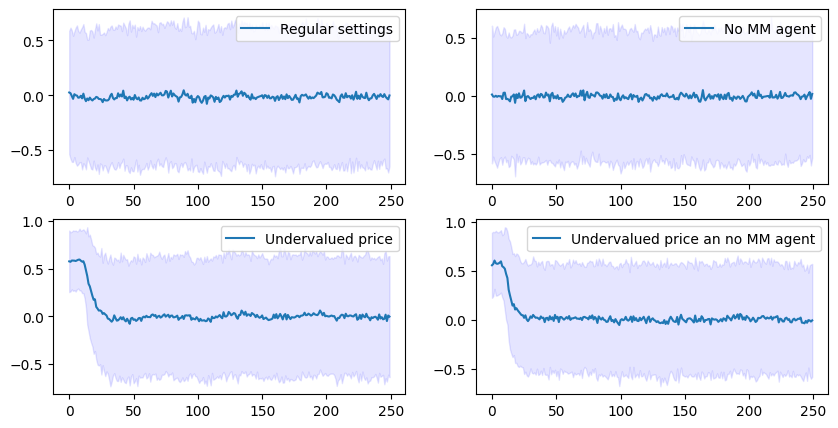

GRAPHS OF sign_transaction_volume_5


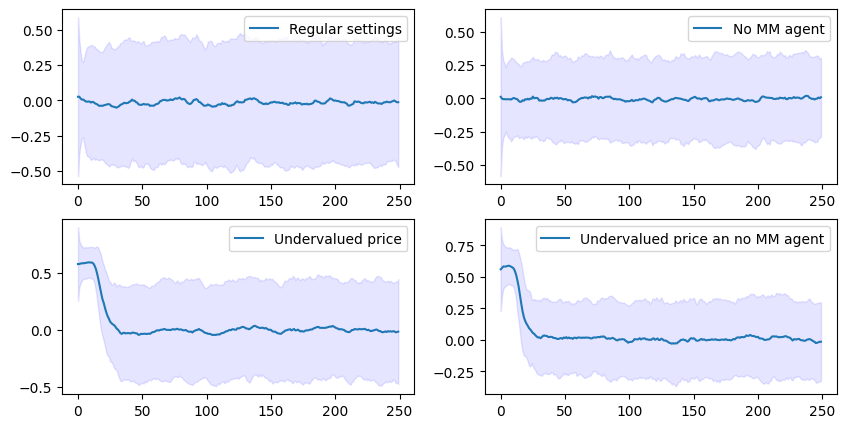

GRAPHS OF sign_transaction_volume_10


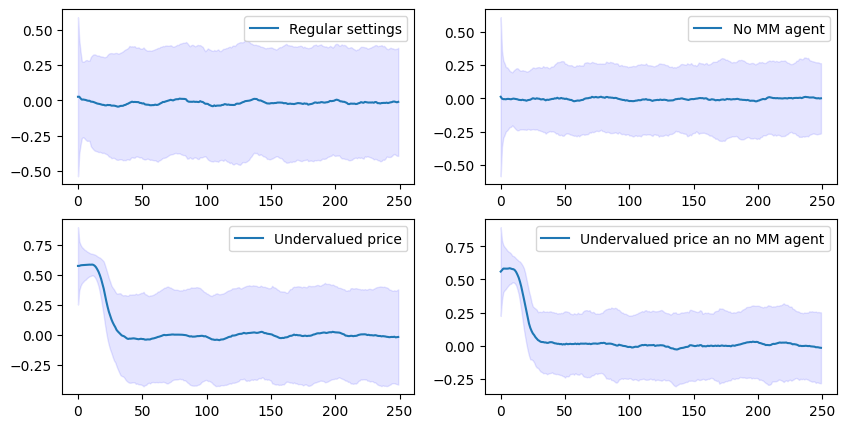

GRAPHS OF sign_transaction_volume_20


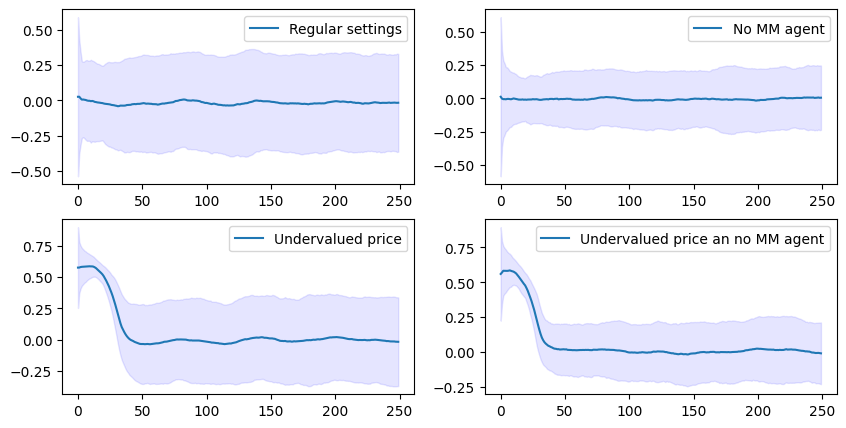

GRAPHS OF all_transaction_volume_1


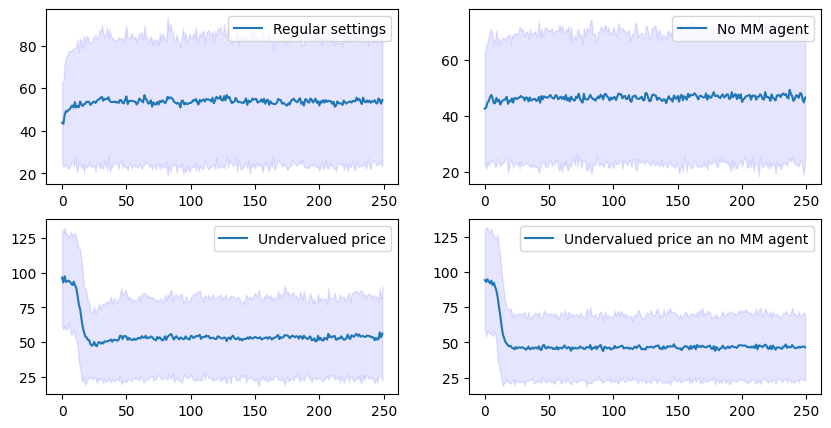

GRAPHS OF bid_ask_spread


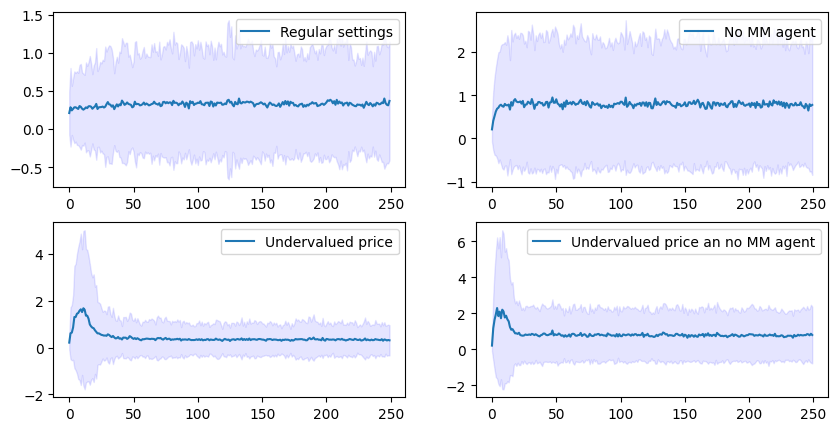

GRAPHS OF dividends


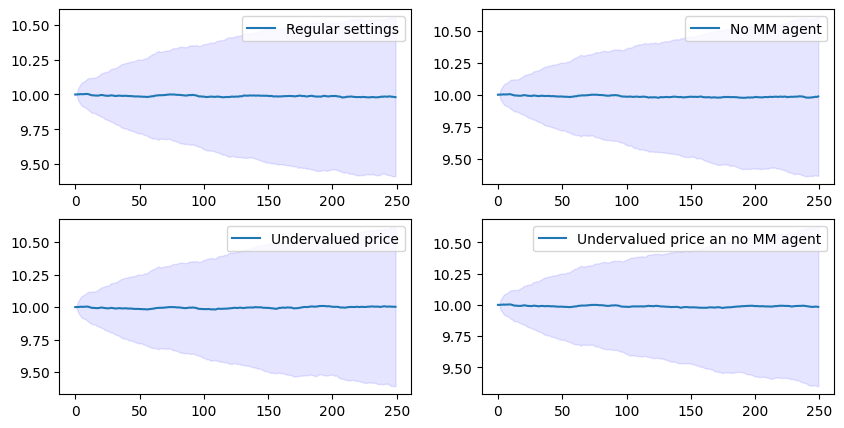

GRAPHS OF price


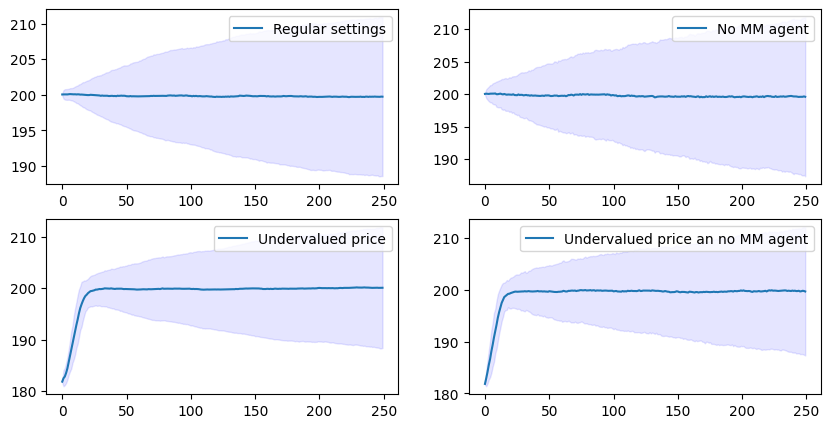

GRAPHS OF dividends_previous_divided


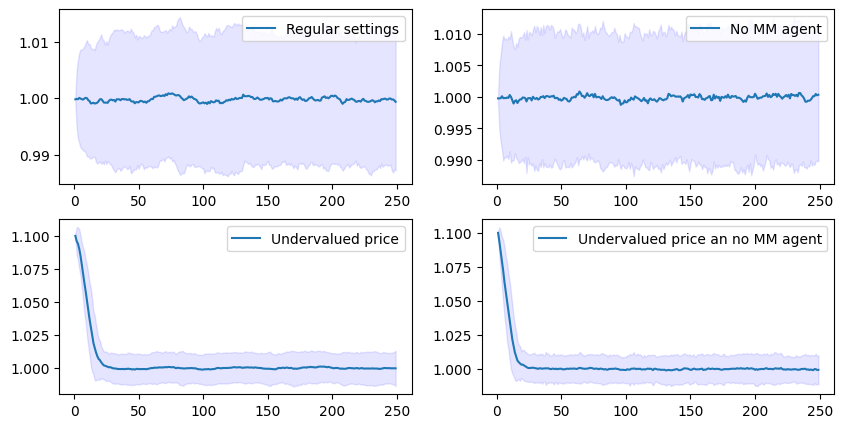

GRAPHS OF fundamental_v


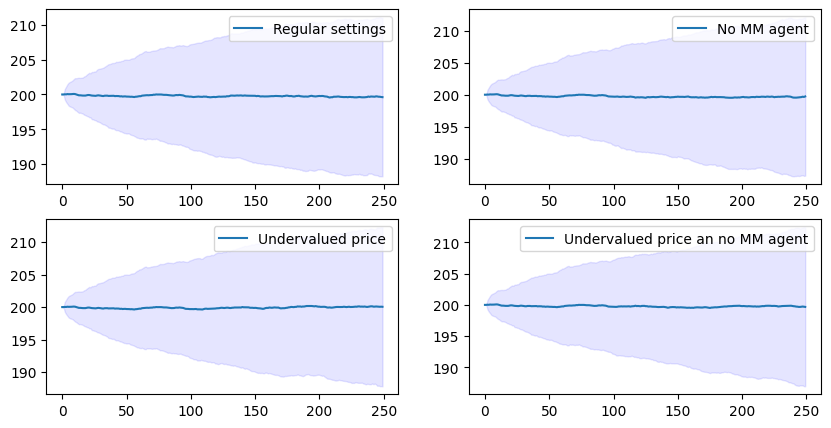

GRAPHS OF return_1


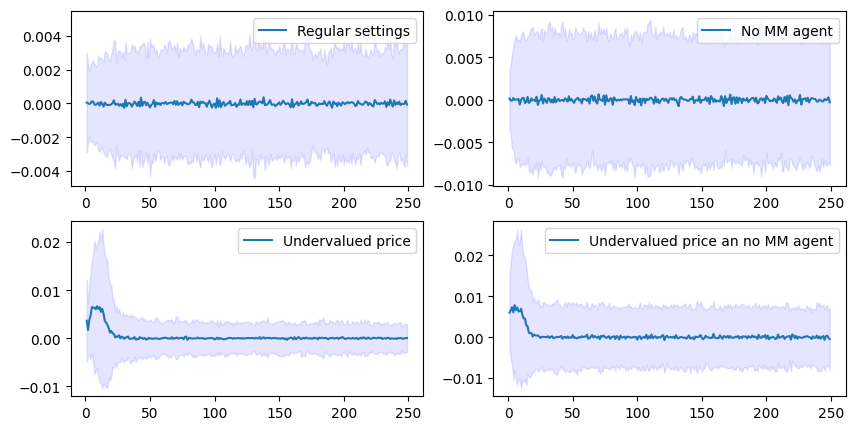

GRAPHS OF return_5


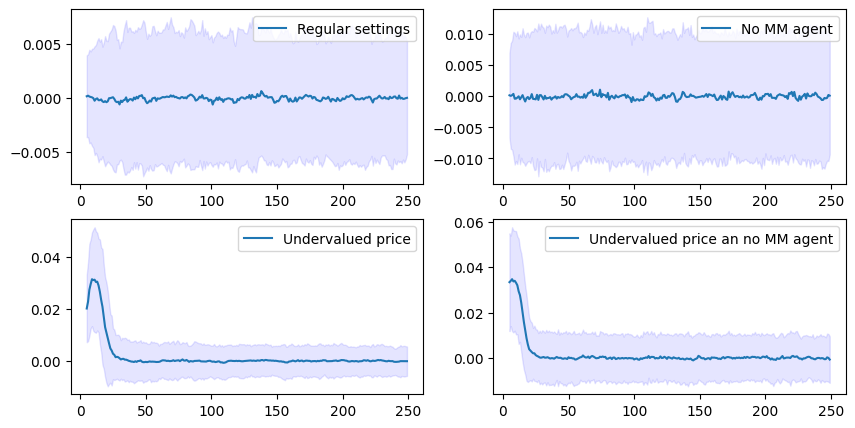

GRAPHS OF return_10


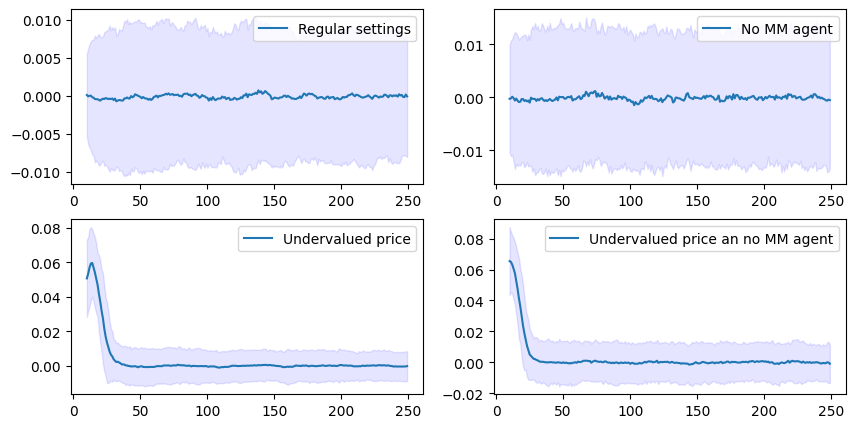

GRAPHS OF return_20


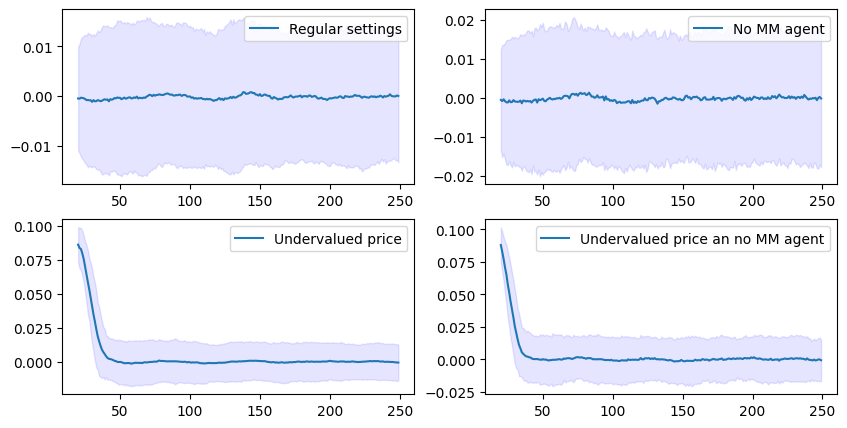

In [459]:
draw_all_features_mean_var(all_data, labels=all_data_names2)

# Predictions

In [16]:
def difference_split(data, price, percentage):
    if data > price * percentage:
        return 1
    elif data < -price * percentage:
        return -1
    else:
        return 0

def prepare_data(data, shift=5, percentage=0.0015, two_classes_only=False, rf_rate=0.05):
    
#     if len(data) > 1:
#         result = pd.DataFrame()
#         for d in data:
#             result = pd.concat([result, d])
    
#         data = result
    
    n = data.shape[0]
    
    data = data.copy()
    data['future_price'] = data['price'].shift(-shift)
    data = data[data.index < data.shape[0] - shift]
    
    difference = (data['future_price'] - data['price']) / data['price']
    difference_bounder = [percentage for i in range(len(data['price']))]
    
    price_movement=[]
    
    for i in range(len(difference)):
        if difference[i] > difference_bounder[i]:
            price_movement.append(1)
        elif difference[i] < -1 * difference_bounder[i]:
            price_movement.append(-1)
        else:
            price_movement.append(0)
        
    data['difference'] = price_movement
    data = data.dropna()
    
    # additional normalization
    data['bid_ask_spread_percentage'] = data['bid_ask_spread'] / data['price']
    
    data['fundamental_v_norm'] = data['fundamental_v'] / data['price'] - 1
#     data['dividends_previous'] = data['dividends_previous'] 
    
    data = data.drop(['bid_ask_spread'], axis=1)
    
    return data.reset_index()

def prepare_huge_data(data: list(), shift=5, percentage=0.0015, two_classes_only=False):
    result = pd.DataFrame()
    
    iteration = 1
    
    for d in data:
        d = prepare_data(d, shift, percentage, two_classes_only)
        d["trajectory_number"] = iteration
        result = pd.concat([result, d])
        
        iteration+=1
    
    return result

In [318]:
def classifier_test(test_classifier, passed_data, shift=10, percentage=0.0010, xgb=True, silent=False, x_columns=None, trajectory_test_split=0):
    
    # data preparation
    
    data_xy = prepare_huge_data(passed_data, shift=shift, percentage=percentage)
    
    if trajectory_test_split == 0:
        
        data_xy = data_xy.drop(['trajectory_number'], axis=1)
    
        n_iterations = max(data_xy['index'].unique())
        train_border = n_iterations * 0.8

        data_xy = data_xy[data_xy.index % shift == 0]

        if not silent:
            print('data shape -', data_xy.shape)

        data_xy_train = data_xy[data_xy['index'] < train_border]
        data_xy_test = data_xy[data_xy['index'] >= train_border]
        
    else:
    
        n_iterations = max(data_xy['trajectory_number'].unique())
        train_border = n_iterations * 0.8

        data_xy = data_xy[data_xy.index % shift == 0]

        if not silent:
            print('data shape -', data_xy.shape)

        data_xy_train = data_xy[data_xy['trajectory_number'] < train_border]
        data_xy_test = data_xy[data_xy['trajectory_number'] >= train_border]
        
        data_xy_train = data_xy_train.drop(['trajectory_number'], axis=1)
        data_xy_test = data_xy_test.drop(['trajectory_number'], axis=1)

#     data_xy_train = data_xy_train.sample(frac = 1)

    data_y_train = data_xy_train['difference']
    data_x_train = data_xy_train.drop(['future_price', 'index', 'difference', 'dividends', 'price', 'fundamental_v'], axis=1) # price fundamental_v
    
#     data_x_train['price_m_fund'] = data_x_train['price'] - data_x_train['fundamental_v']

    data_y_test = data_xy_test['difference']
    data_x_test = data_xy_test.drop(['future_price', 'index', 'difference', 'dividends', 'price', 'fundamental_v'], axis=1) # price fundamental_v
    
#     data_x_test['price_m_fund'] = data_x_test['price'] - data_x_test['fundamental_v']
    
    if x_columns:
        data_x_train = data_x_train[x_columns]
        data_x_test = data_x_test[x_columns]
    
    if not silent:
#         plt.title('classes distribution')
        data_xy_train['difference'].hist()
        data_xy_test['difference'].hist()
        plt.show()
    
#     else:
#         distribution = data_xy['difference'].value_counts()
#         total = data_xy['difference'].count()
        
#         print(f"classes distribution: \n-1\t{round(distribution[-1]/total, 2) * 100}%\n0\t{round(distribution[0]/total, 2) * 100}%\n1\t{round(distribution[1]*100/total, 2)}%")
    
    # predictions
    
    X_train, X_test, y_train, y_test = data_x_train, data_x_test, data_y_train, data_y_test
    
    if xgb and min(y_train)  == -1:
        y_train += 1
        y_test += 1

    tested_model = test_classifier
    tested_model.fit(X_train, y_train)

    # training accuracy
    predictions = tested_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, predictions)
    
    if not silent:
        print("TRAIN accuracy score - ", round(train_accuracy, 2)) #, recall_score(y_test, predictions))

    # test accuracy
    predictions = tested_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, predictions)
    
    if not silent:
        print("TEST  accuracy score - ", round(test_accuracy, 2)) #, recall_score(y_test, predictions))
    
    if not silent:
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions), #/confusion_matrix(y_test, predictions).sum(),
                                    display_labels=['down', 'nothing', 'up'])
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
    
    return tested_model, train_accuracy, test_accuracy

### Functions classifications

In [18]:
def replace_name(x):
    return x

def draw_importance_xgb(models):
    
    xgb_model_1, xgb_model_2, xgb_model_3, xgb_model_4 = models[0], models[1], models[2], models[3]
    
    xxx = pd.DataFrame(columns = replace_name(xgb_model_1.feature_names_in_))
    xxx.loc[len(xxx.index)] = (xgb_model_1.feature_importances_)

    xxy = pd.DataFrame(columns = replace_name(xgb_model_2.feature_names_in_))
    xxy.loc[1] = (xgb_model_2.feature_importances_)

    xyy = pd.DataFrame(columns = replace_name(xgb_model_3.feature_names_in_))
    xyy.loc[2] = (xgb_model_3.feature_importances_)

    yyy = pd.DataFrame(columns = replace_name(xgb_model_4.feature_names_in_))
    yyy.loc[3] = (xgb_model_4.feature_importances_)

    zzz = pd.concat([xxx, xxy, xyy, yyy])

    fig, ax = plt.subplots(figsize=(16, 8))

    zzz.T.rename({0:"default simulation", 1:"simulation with no MM", 2:"simulation with undervalued stock", 3:"simulation with undervalued stock, no MM"}, axis=1).sort_values("default simulation").plot.barh(ax=ax, title="Importance of microstructural features for different configurations of synthetic market") #, color=(plt.cm.Blues(0.99), plt.cm.Blues(0.8), plt.cm.Blues(0.61), plt.cm.Blues(0.42)))
    
    plt.plot()

In [19]:
def new_model(name):
    models={
    'xgb': XGBClassifier(random_state=2114, importance_type='weight'),
    'xgb_depth_3': XGBClassifier(random_state=2114, importance_type='weight', max_depth=3),
    'xgb_iteration_restrict': XGBClassifier(random_state=2114, importance_type='weight', n_estimators=5),
    'xgb_lower_lr': XGBClassifier(random_state=2114, importance_type='weight', max_depth=6, learning_rate = 0.01),
    'xgb_l2_reg': XGBClassifier(random_state=2114, importance_type='weight', max_depth=6, reg_lambda = 100),
    'logreg': LogisticRegression(random_state=99)
    }
    
    return models[name]

In [20]:
shift_percentage = {}
shift_percentage['huge_data'] = [(1, 0.0004), (5, 0.001), (10, 0.0017)]
shift_percentage['huge_data_no_mm'] = [(1, 0.001), (5, 0.0025), (10, 0.003)]
shift_percentage['huge_data_undervalued'] = [(1, 0.0008), (5, 0.0025), (10, 0.004)]
shift_percentage['huge_data_undervalued_no_mm'] = [(1, 0.00105), (5, 0.003), (10, 0.0042)]

In [ ]:
for d in all_tested_data:
    prepared_d = prepare_data[d]
    
    

In [ ]:
data_xy = prepare_huge_data(passed_data, shift=shift, percentage=percentage)

data shape - (45800, 22)


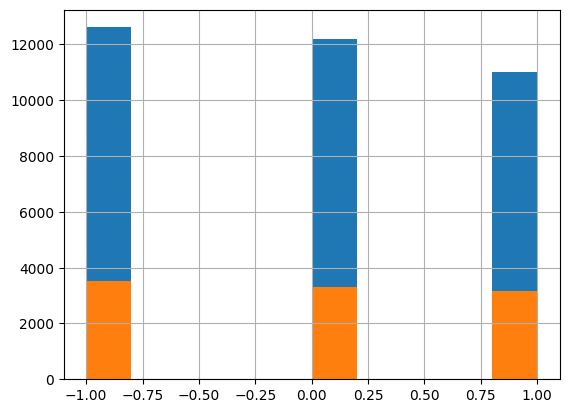

TRAIN accuracy score -  0.64
TEST  accuracy score -  0.61


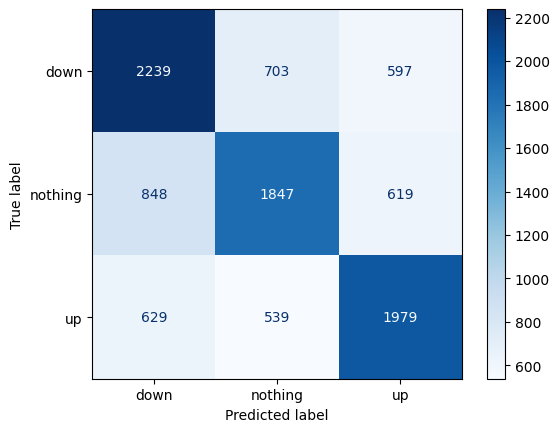

data shape - (9000, 22)


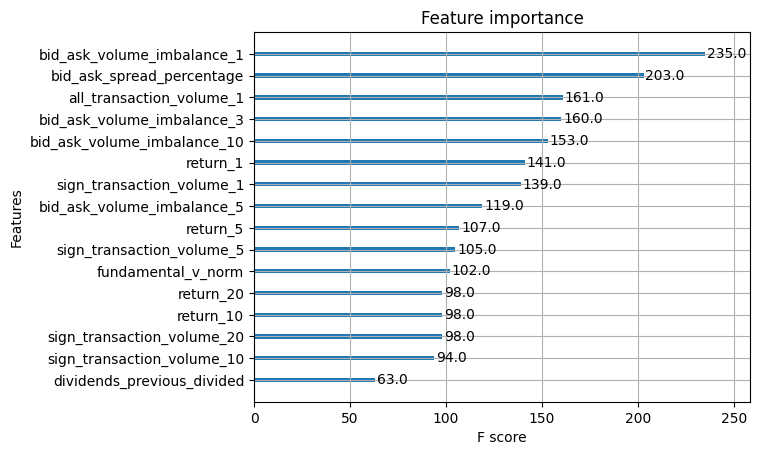

TRAIN accuracy score -  0.73
TEST  accuracy score -  0.62


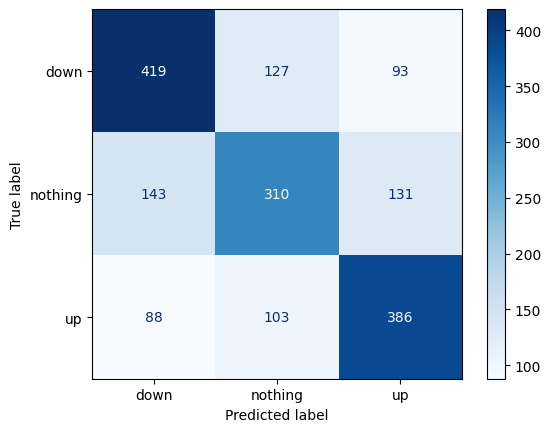

data shape - (4400, 22)


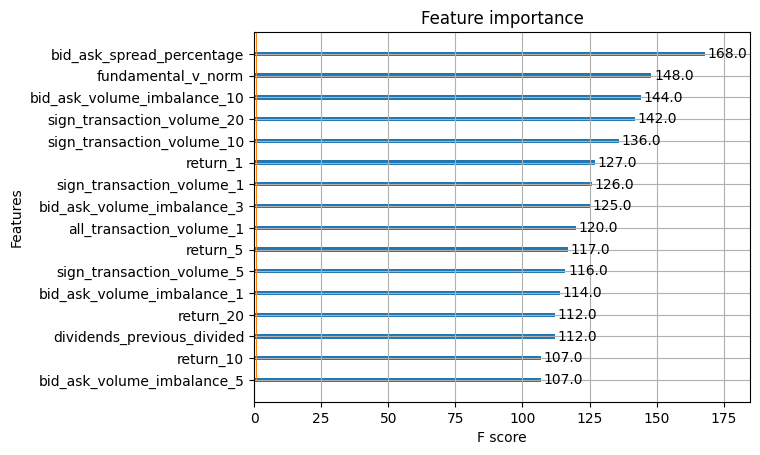

TRAIN accuracy score -  0.82
TEST  accuracy score -  0.57


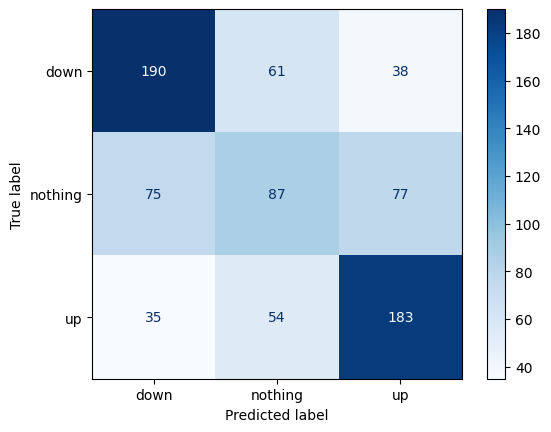

data shape - (45800, 22)


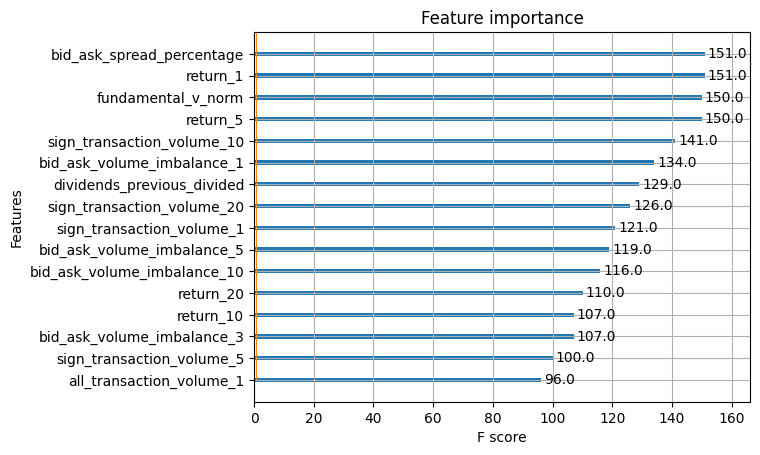

TRAIN accuracy score -  0.66
TEST  accuracy score -  0.62


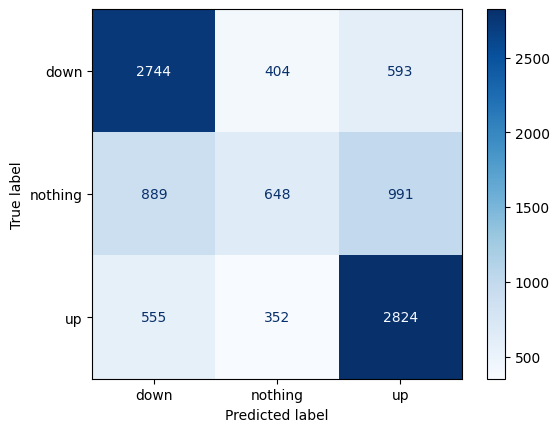

data shape - (9000, 22)


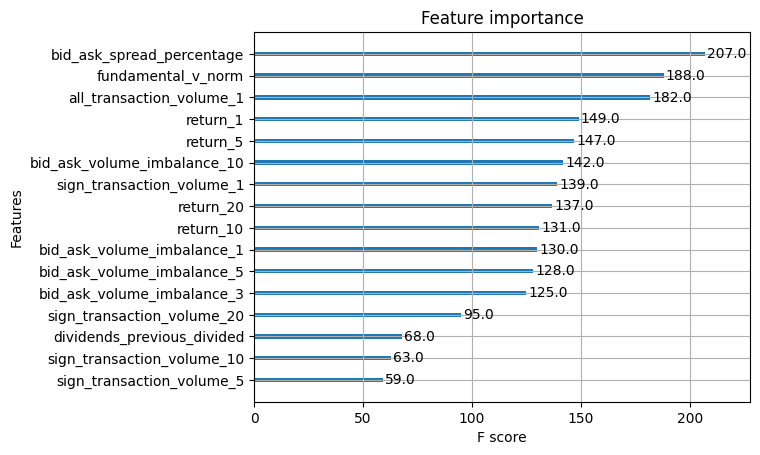

TRAIN accuracy score -  0.69
TEST  accuracy score -  0.52


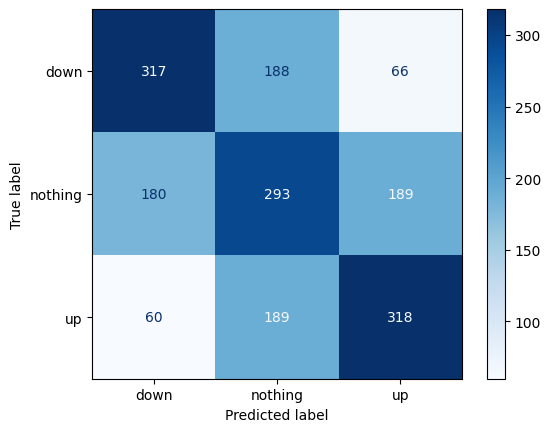

data shape - (4400, 22)


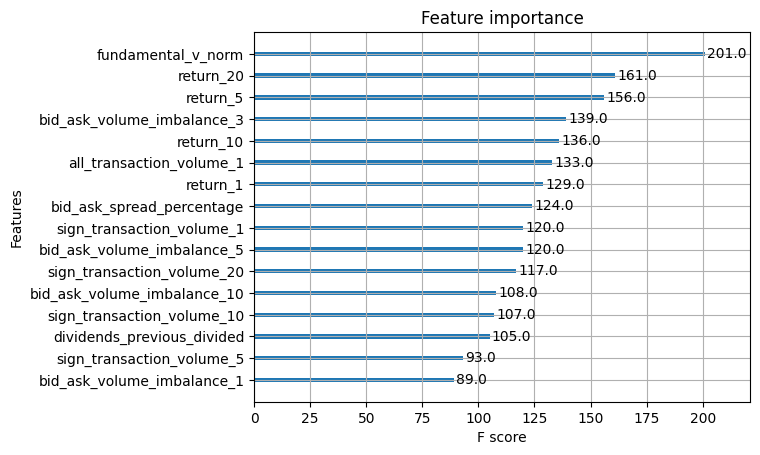

TRAIN accuracy score -  0.77
TEST  accuracy score -  0.49


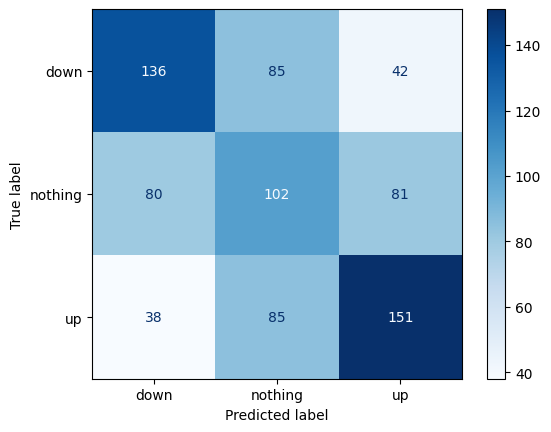

data shape - (45800, 22)


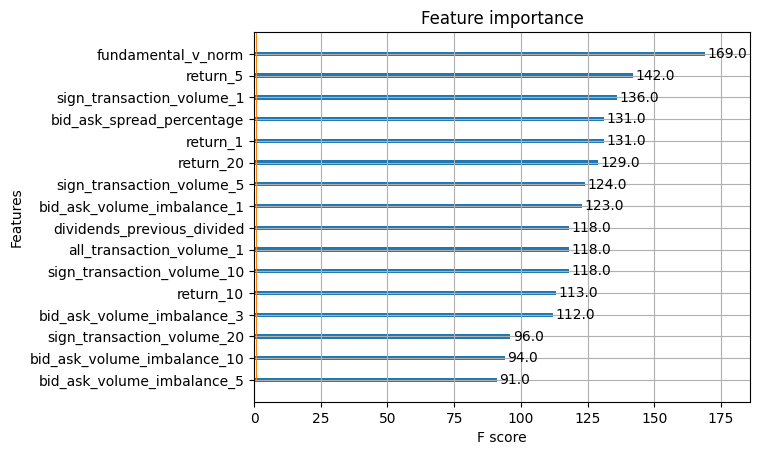

TRAIN accuracy score -  0.69
TEST  accuracy score -  0.68


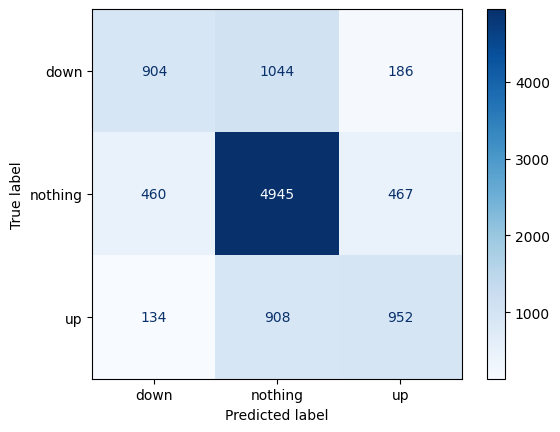

data shape - (9000, 22)


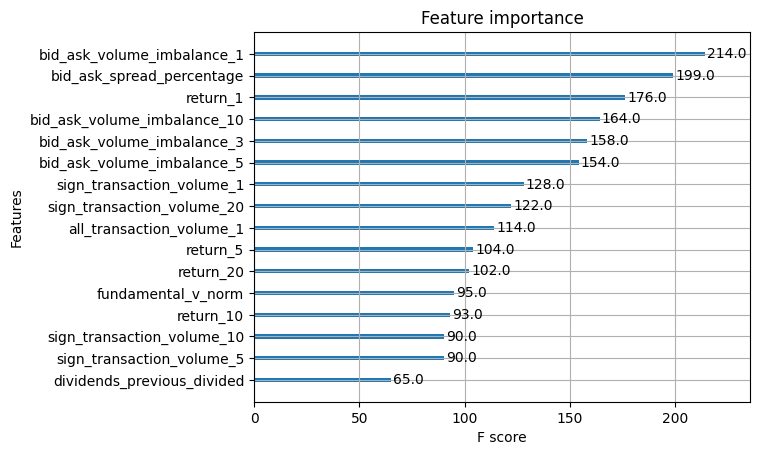

TRAIN accuracy score -  0.79
TEST  accuracy score -  0.74


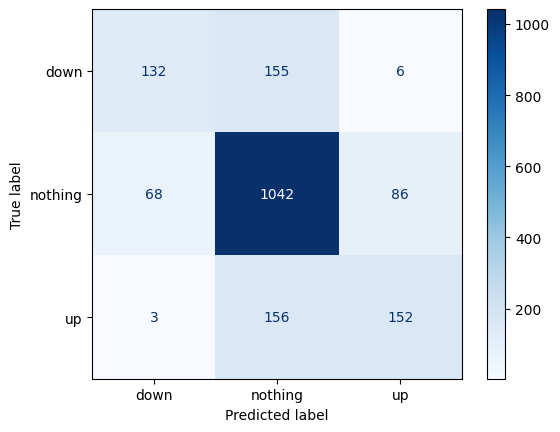

data shape - (4400, 22)


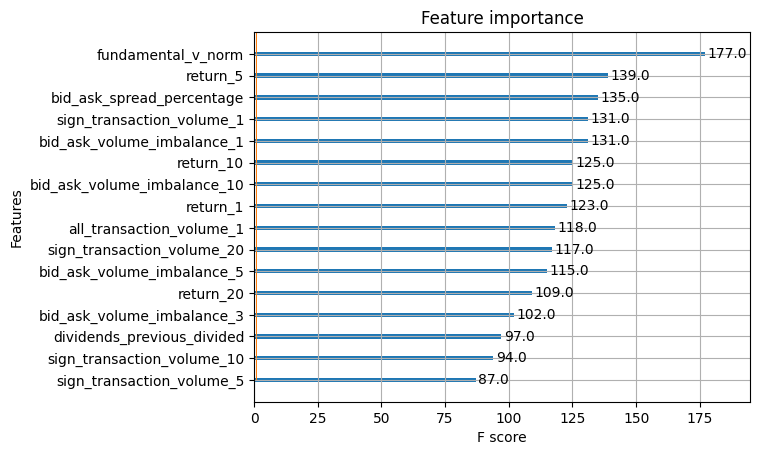

TRAIN accuracy score -  0.85
TEST  accuracy score -  0.73


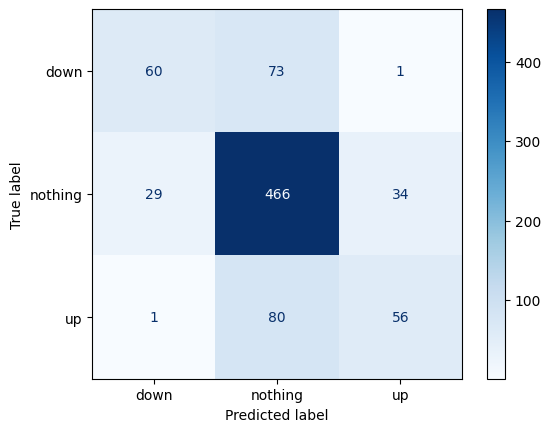

data shape - (45800, 22)


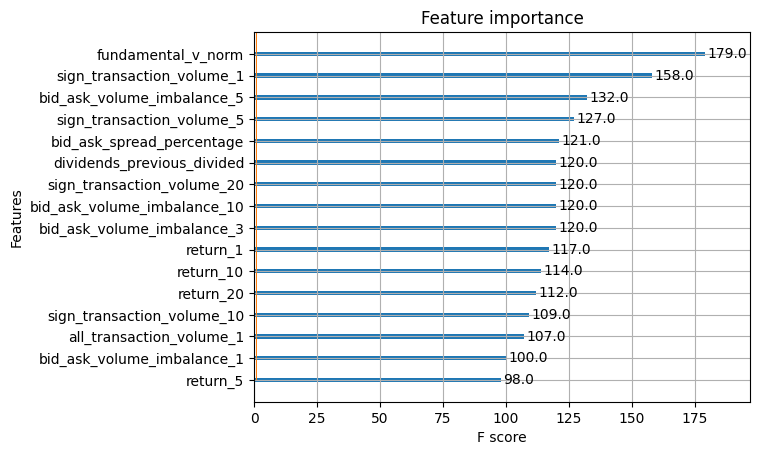

TRAIN accuracy score -  0.66
TEST  accuracy score -  0.62


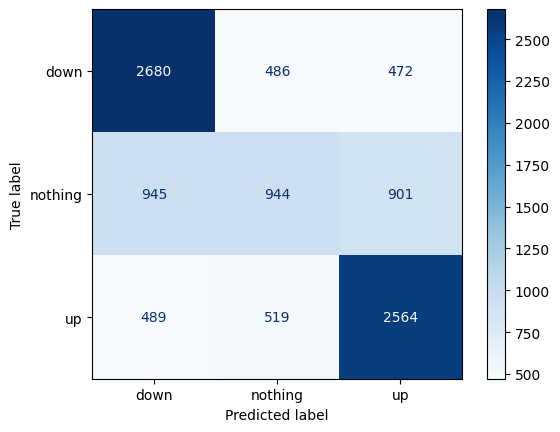

data shape - (9000, 22)


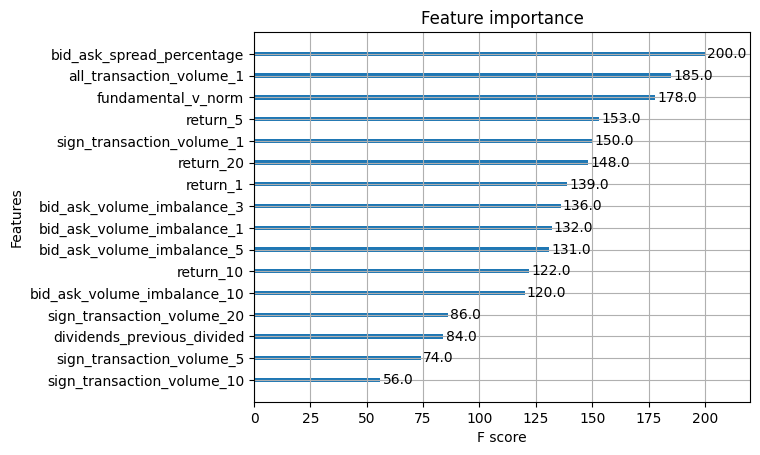

TRAIN accuracy score -  0.68
TEST  accuracy score -  0.57


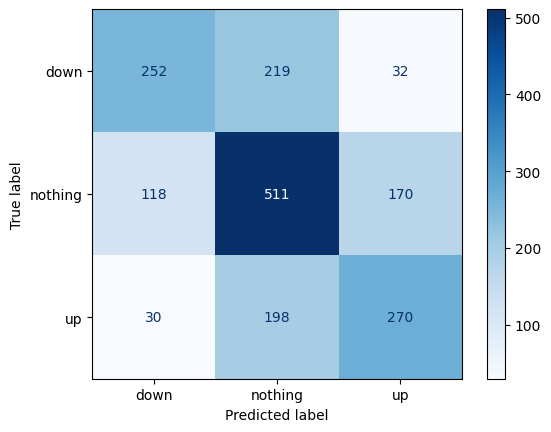

data shape - (4400, 22)


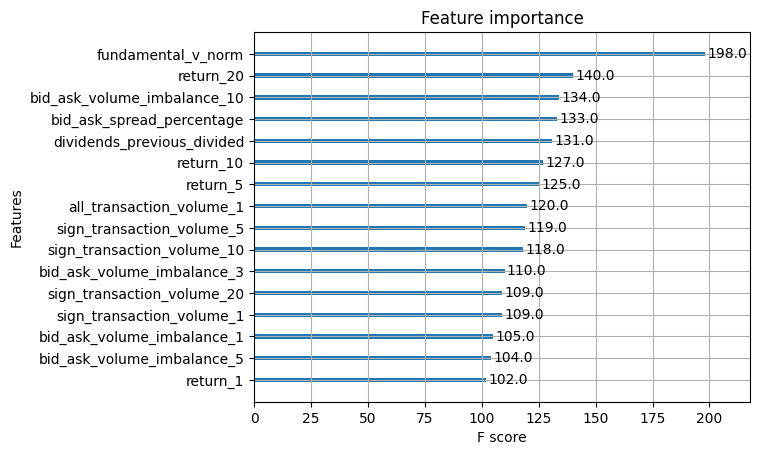

TRAIN accuracy score -  0.77
TEST  accuracy score -  0.56


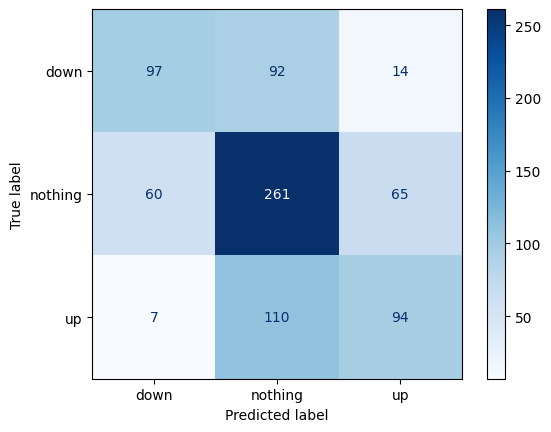

data shape - (45800, 22)


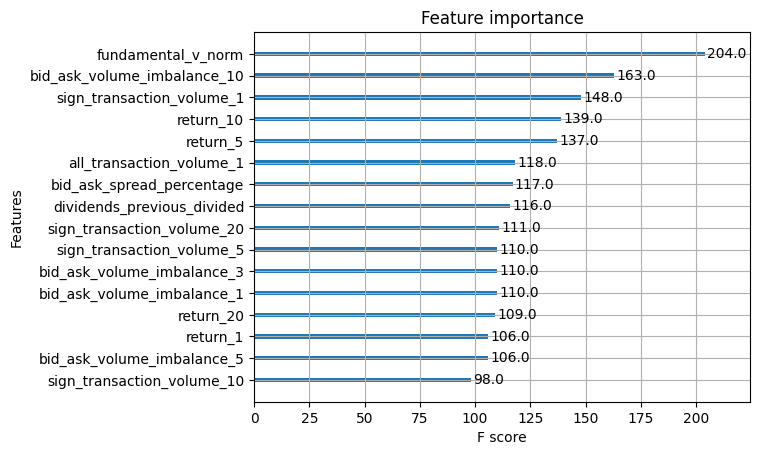

TRAIN accuracy score -  0.63
TEST  accuracy score -  0.59


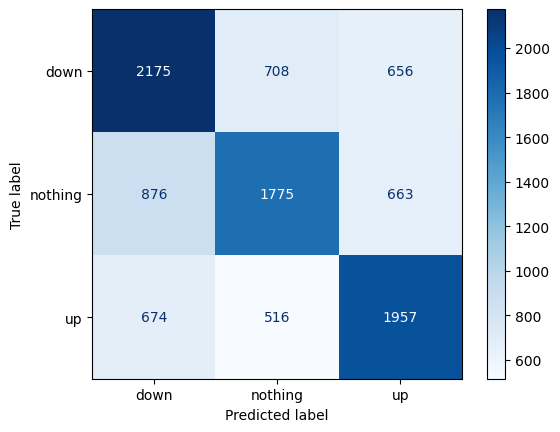

data shape - (9000, 22)


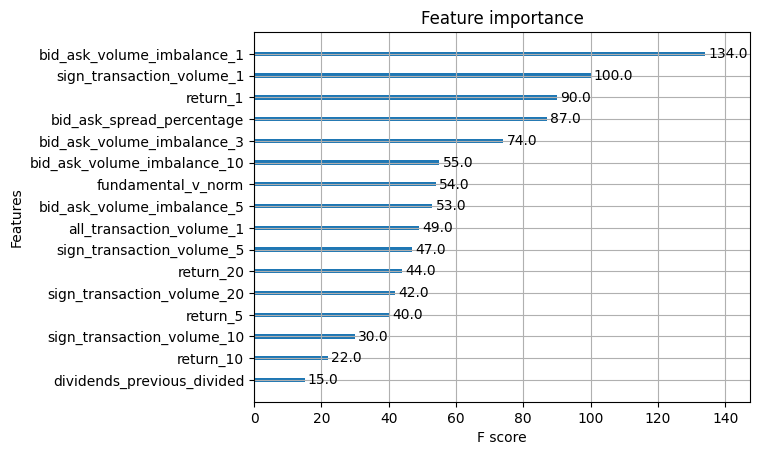

TRAIN accuracy score -  0.7
TEST  accuracy score -  0.61


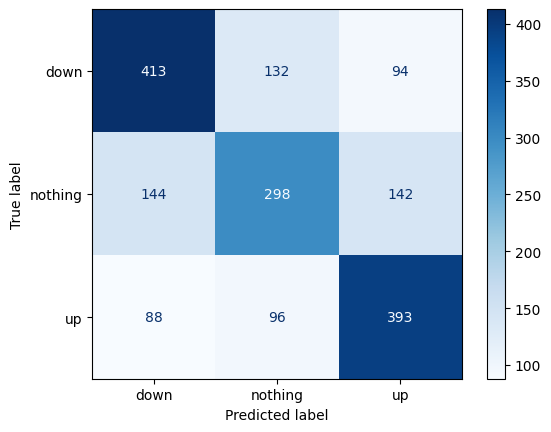

data shape - (4400, 22)


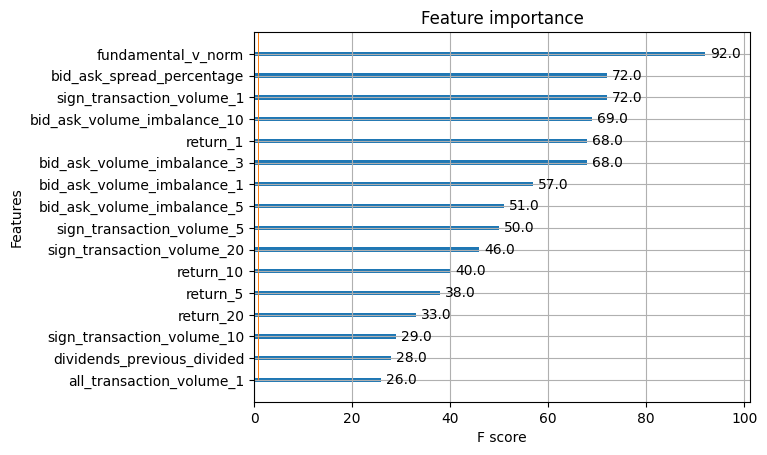

TRAIN accuracy score -  0.75
TEST  accuracy score -  0.59


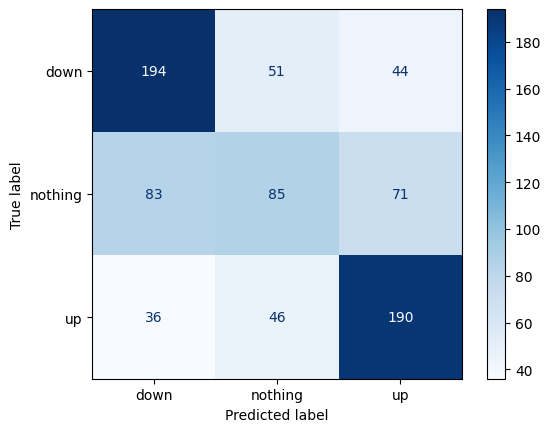

data shape - (45800, 22)


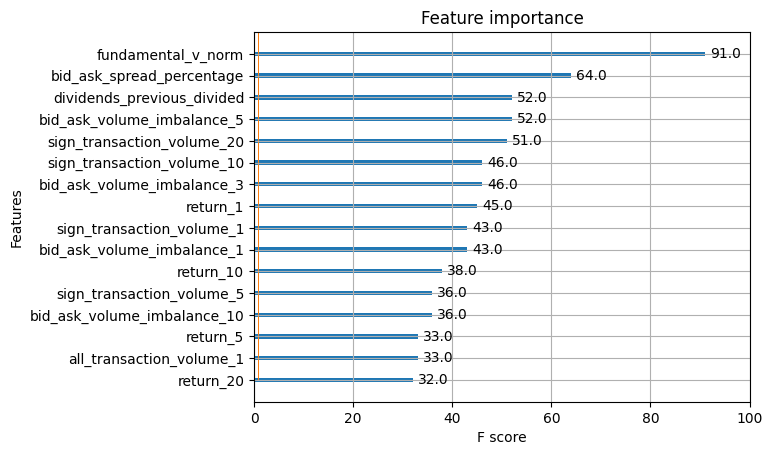

TRAIN accuracy score -  0.64
TEST  accuracy score -  0.61


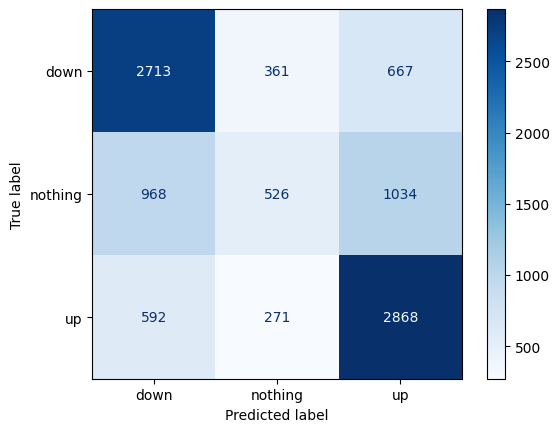

data shape - (9000, 22)


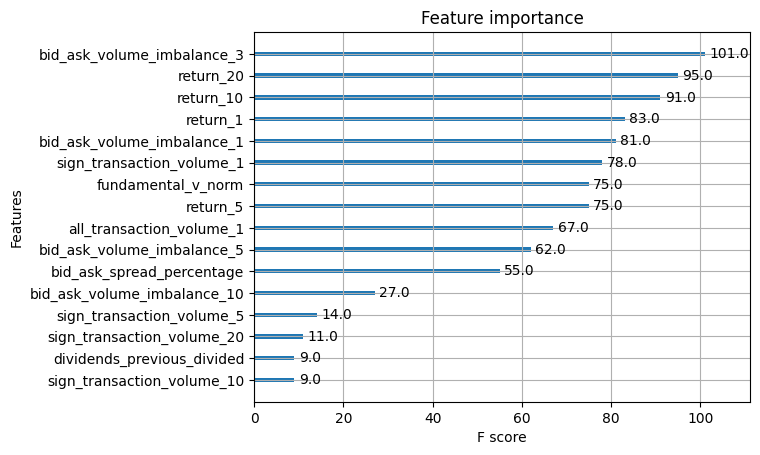

TRAIN accuracy score -  0.64
TEST  accuracy score -  0.54


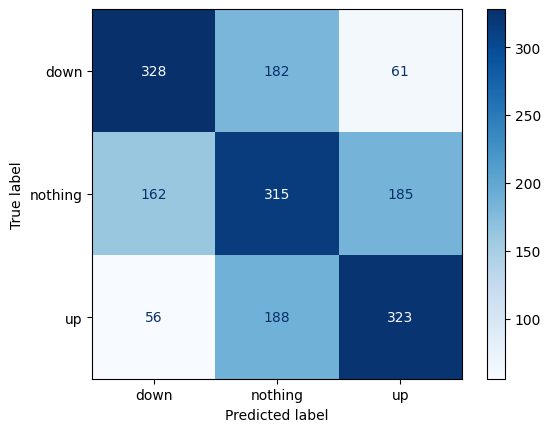

data shape - (4400, 22)


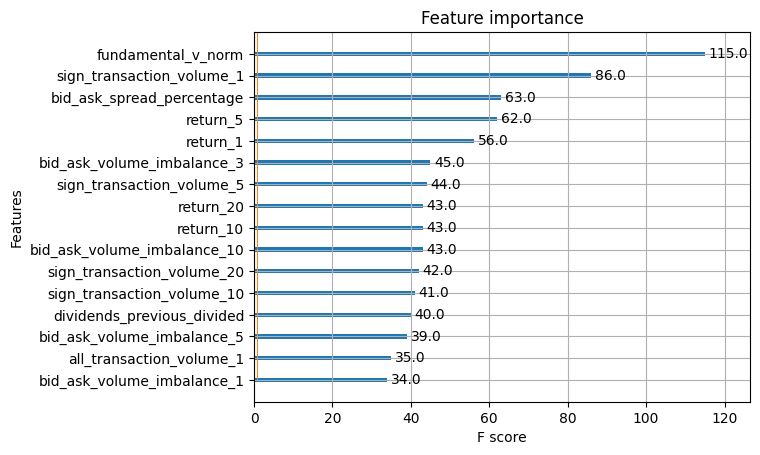

TRAIN accuracy score -  0.69
TEST  accuracy score -  0.49


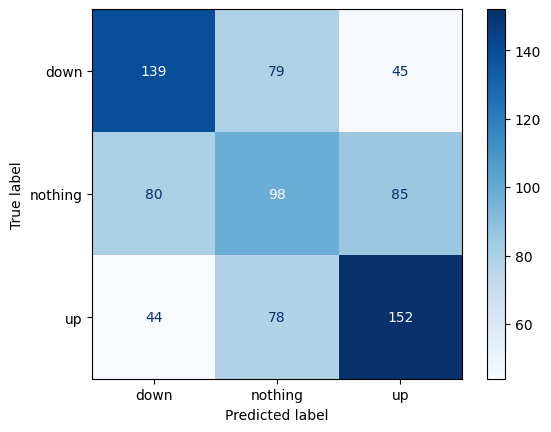

data shape - (45800, 22)


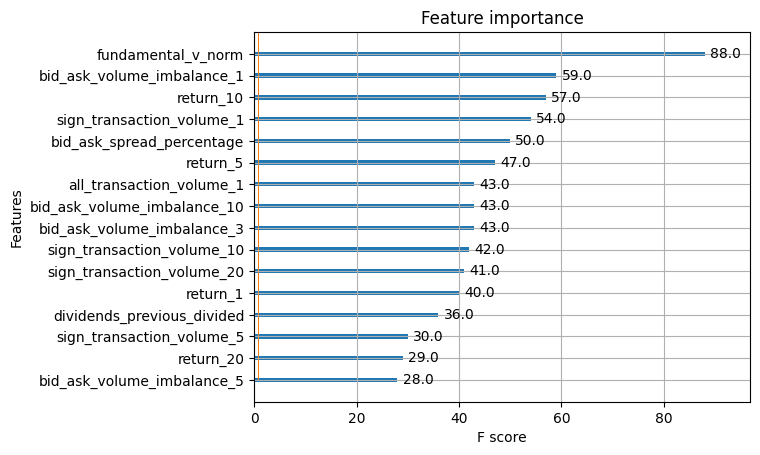

TRAIN accuracy score -  0.68
TEST  accuracy score -  0.67


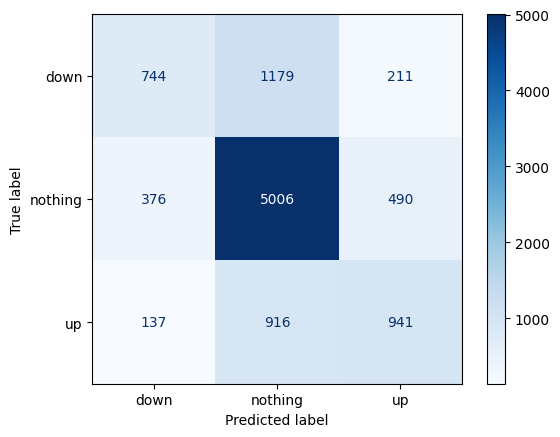

data shape - (9000, 22)


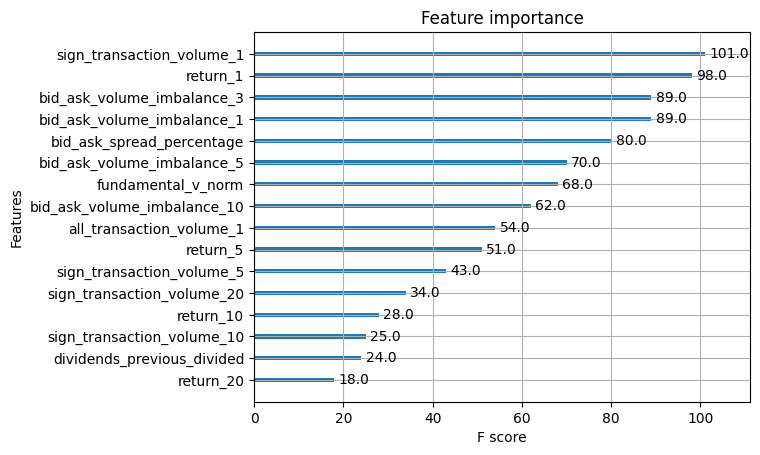

TRAIN accuracy score -  0.77
TEST  accuracy score -  0.73


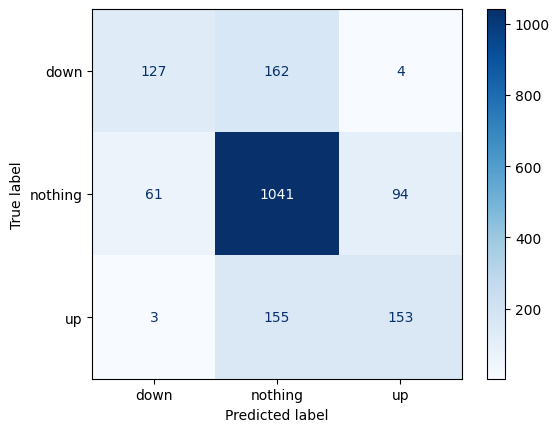

data shape - (4400, 22)


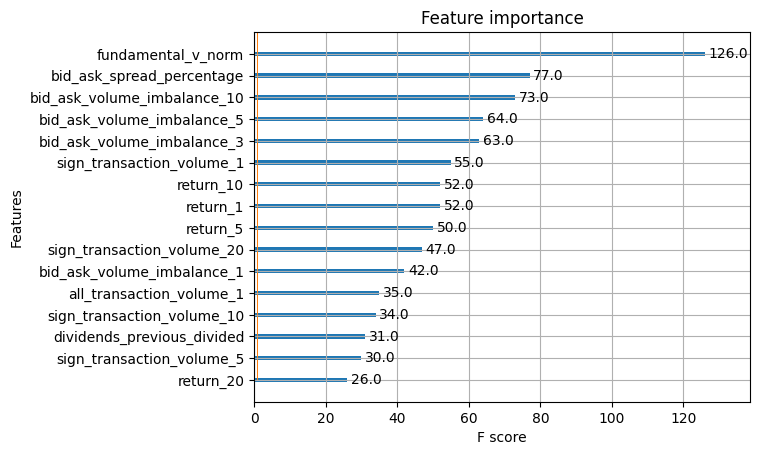

TRAIN accuracy score -  0.8
TEST  accuracy score -  0.72


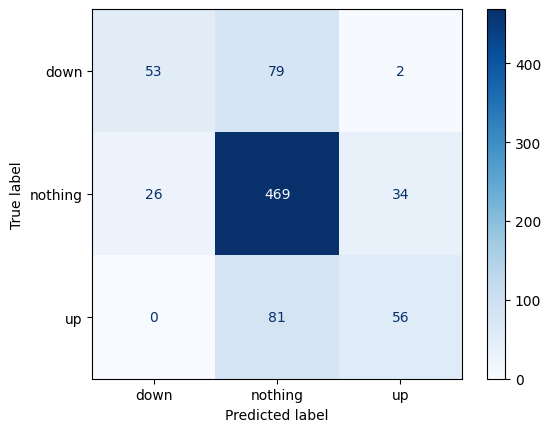

data shape - (45800, 22)


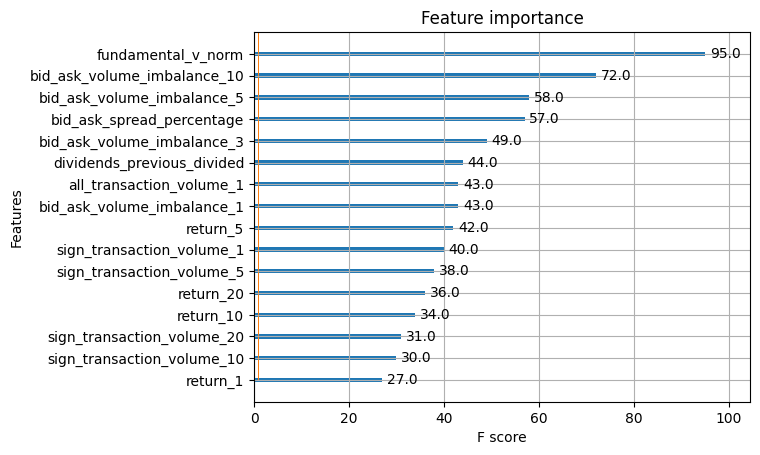

TRAIN accuracy score -  0.64
TEST  accuracy score -  0.6


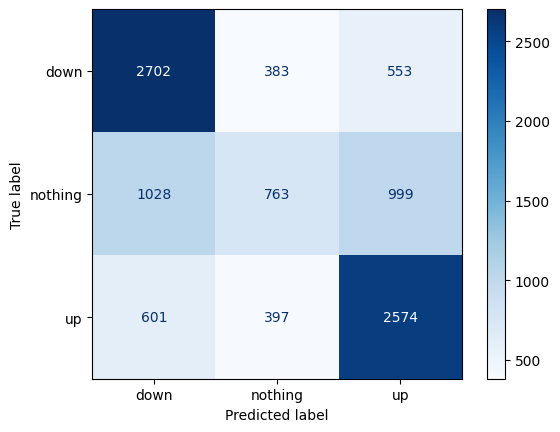

data shape - (9000, 22)


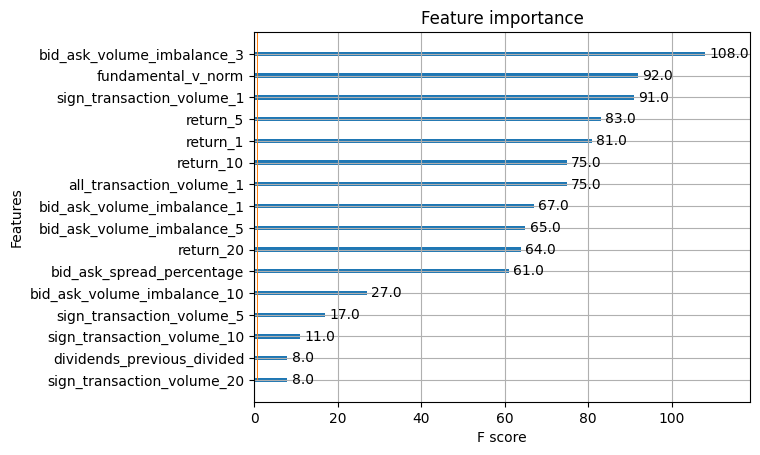

TRAIN accuracy score -  0.64
TEST  accuracy score -  0.56


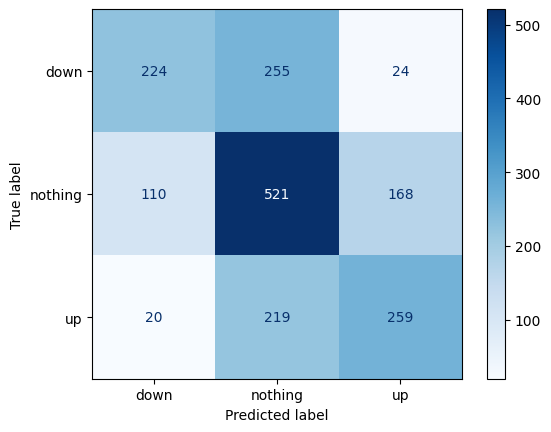

data shape - (4400, 22)


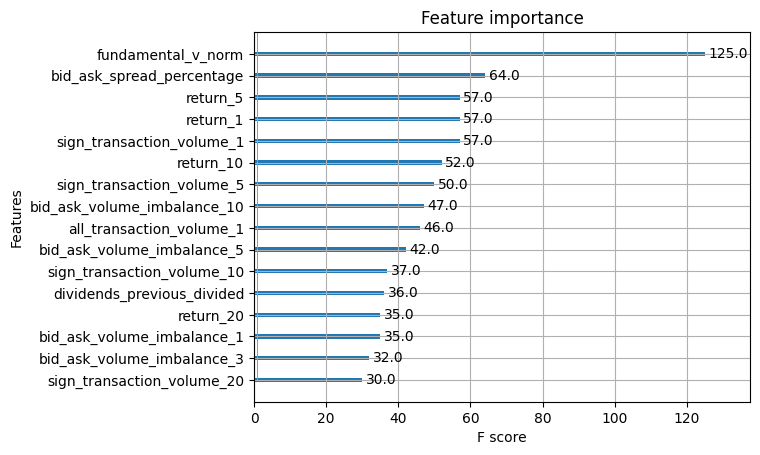

TRAIN accuracy score -  0.69
TEST  accuracy score -  0.57


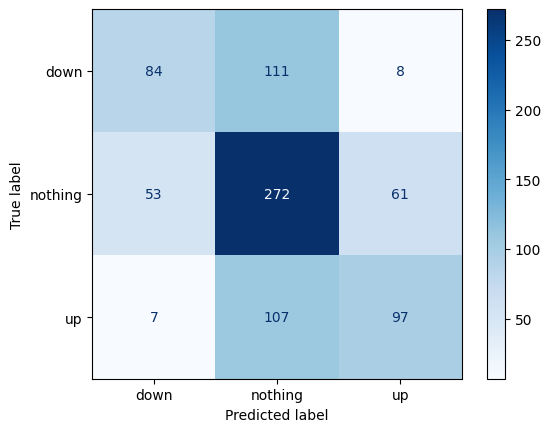

data shape - (45800, 22)


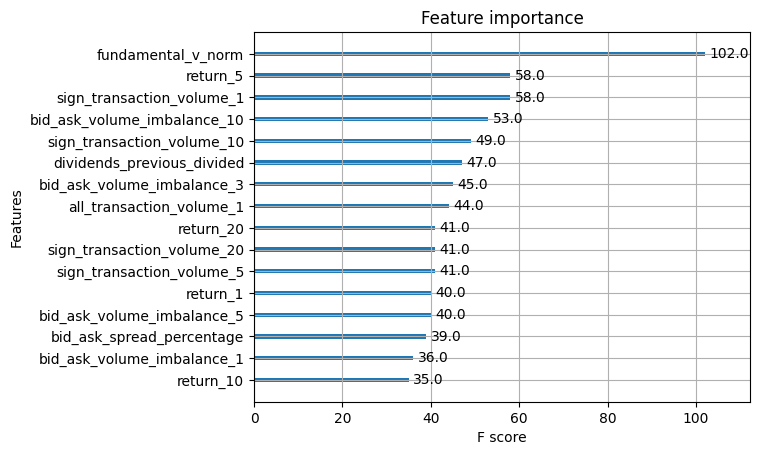

TRAIN accuracy score -  0.63
TEST  accuracy score -  0.59


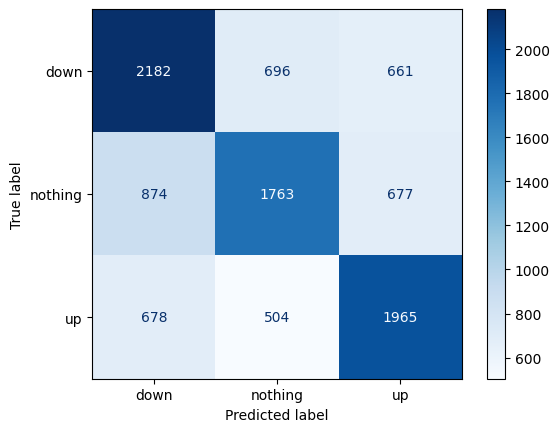

data shape - (9000, 22)


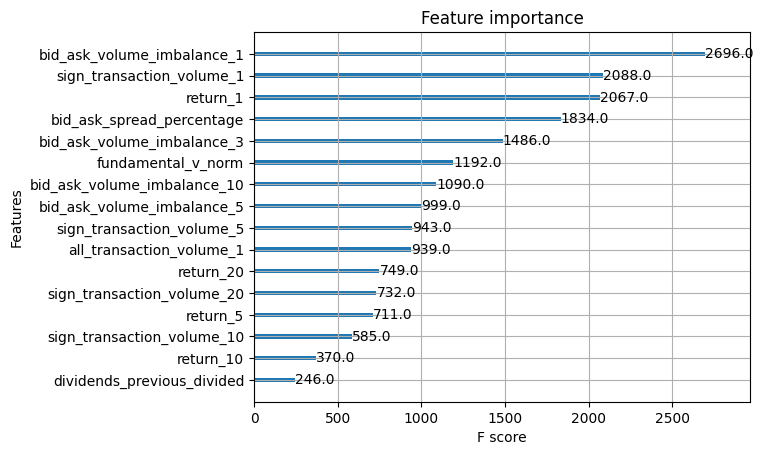

TRAIN accuracy score -  0.7
TEST  accuracy score -  0.62


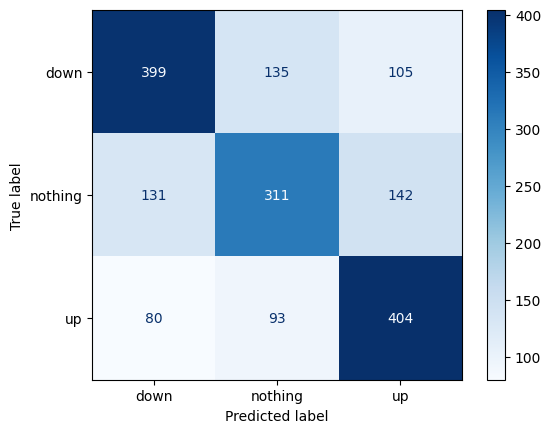

data shape - (4400, 22)


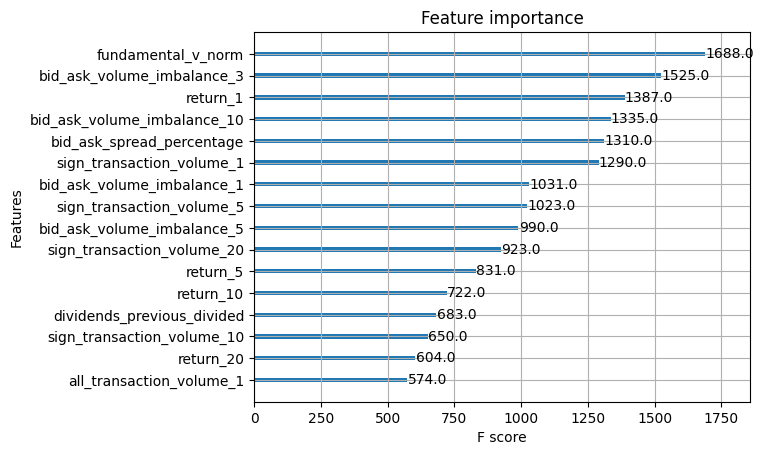

TRAIN accuracy score -  0.73
TEST  accuracy score -  0.6


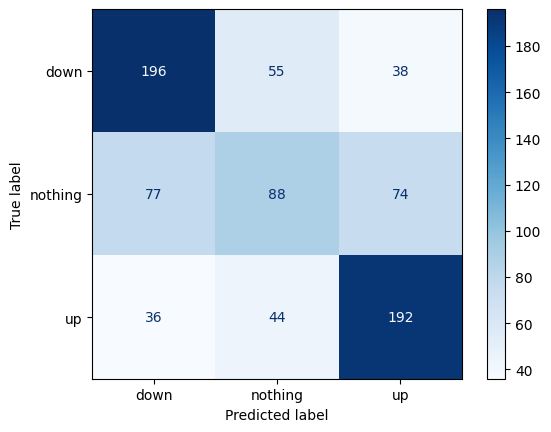

data shape - (45800, 22)


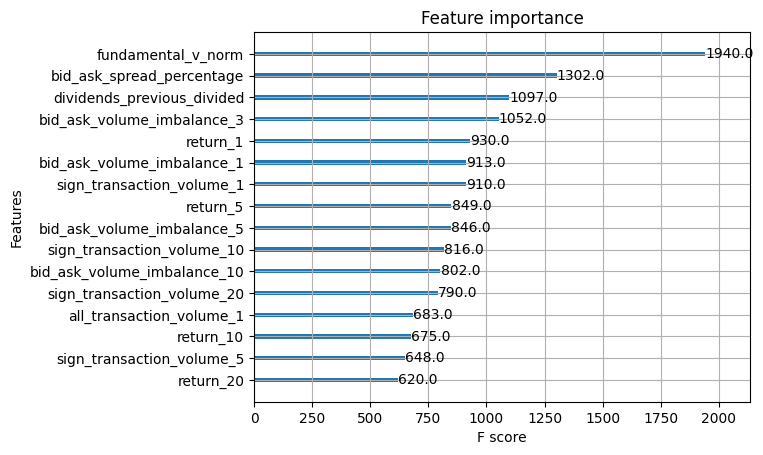

TRAIN accuracy score -  0.64
TEST  accuracy score -  0.61


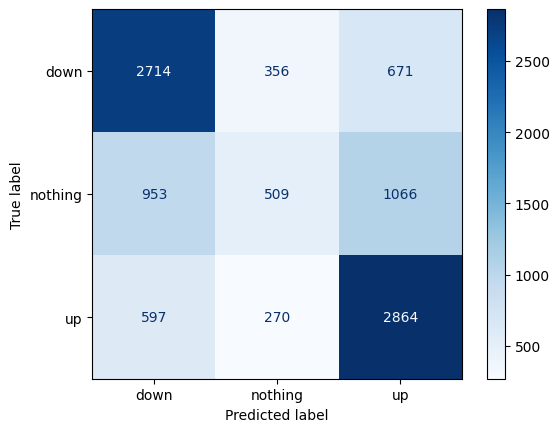

data shape - (9000, 22)


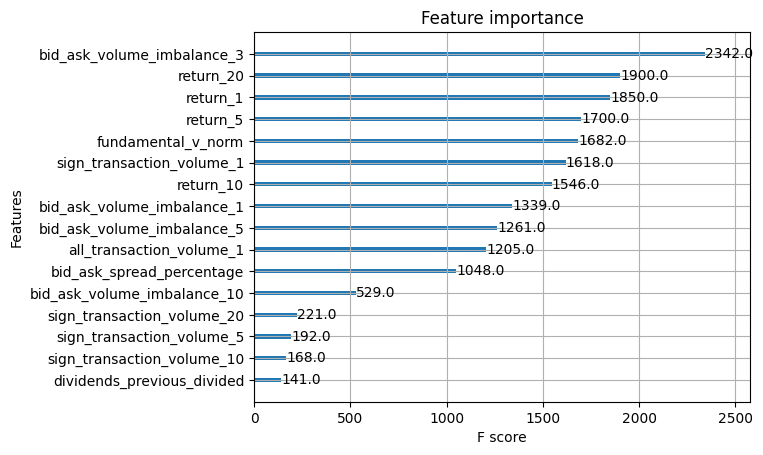

TRAIN accuracy score -  0.63
TEST  accuracy score -  0.53


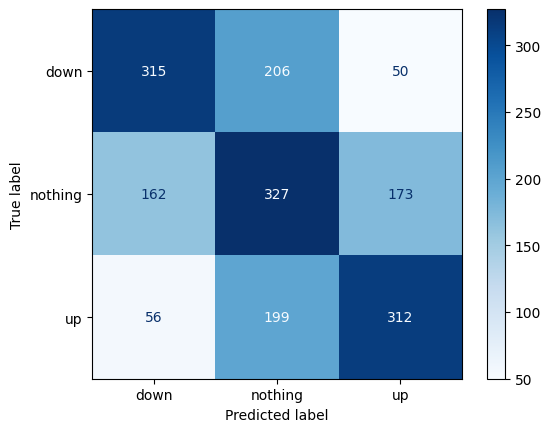

data shape - (4400, 22)


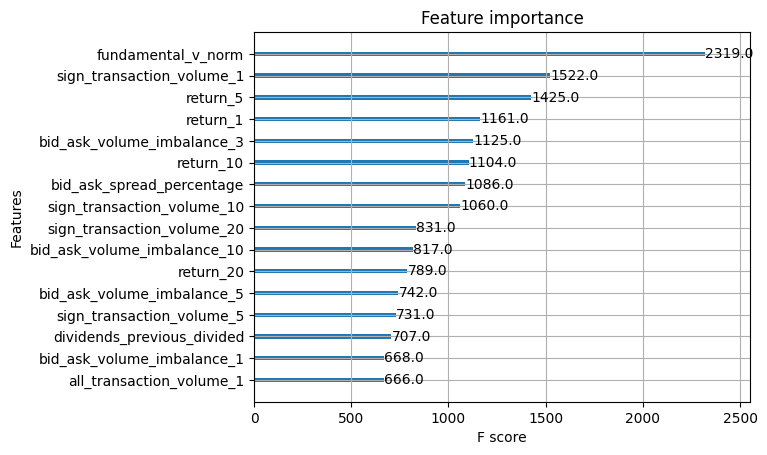

TRAIN accuracy score -  0.69
TEST  accuracy score -  0.5


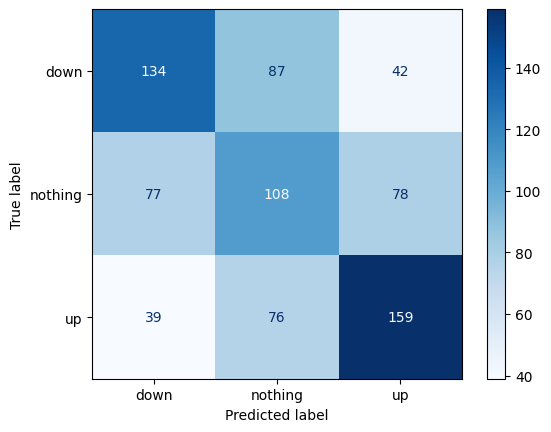

data shape - (45800, 22)


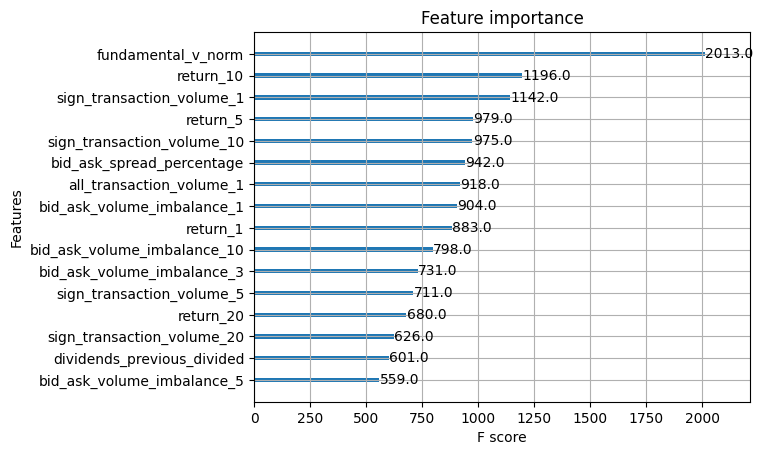

TRAIN accuracy score -  0.68
TEST  accuracy score -  0.67


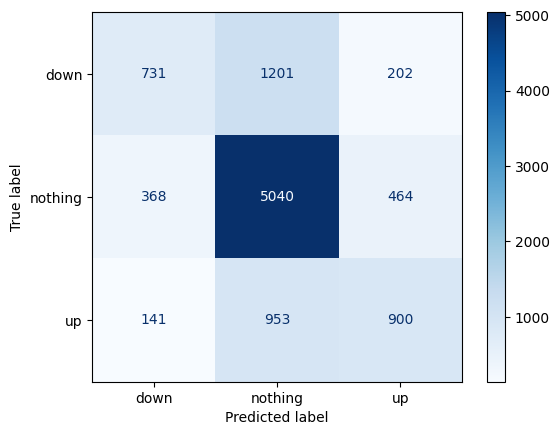

data shape - (9000, 22)


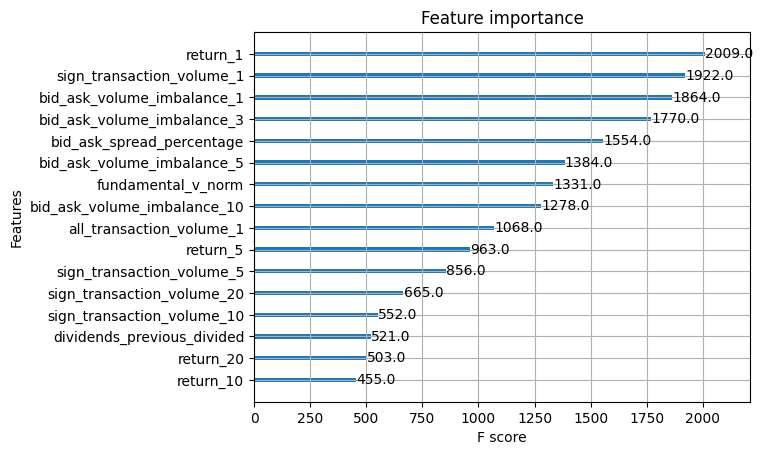

TRAIN accuracy score -  0.76
TEST  accuracy score -  0.73


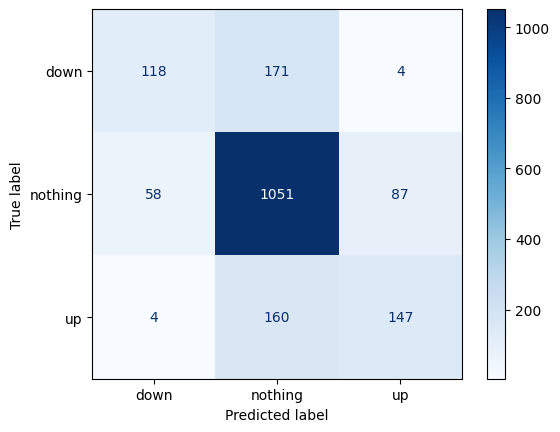

data shape - (4400, 22)


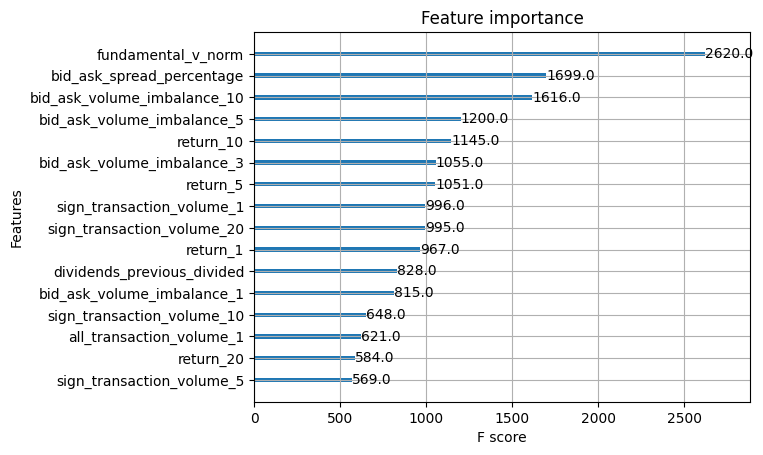

TRAIN accuracy score -  0.79
TEST  accuracy score -  0.73


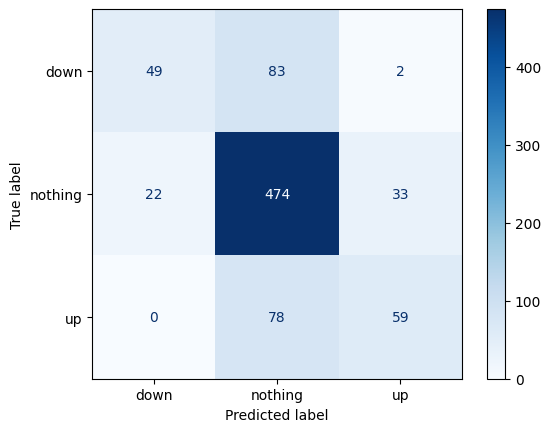

data shape - (45800, 22)


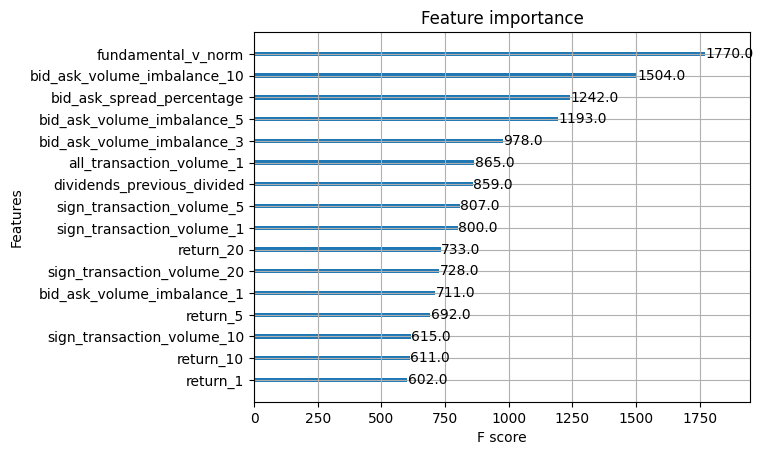

TRAIN accuracy score -  0.64
TEST  accuracy score -  0.6


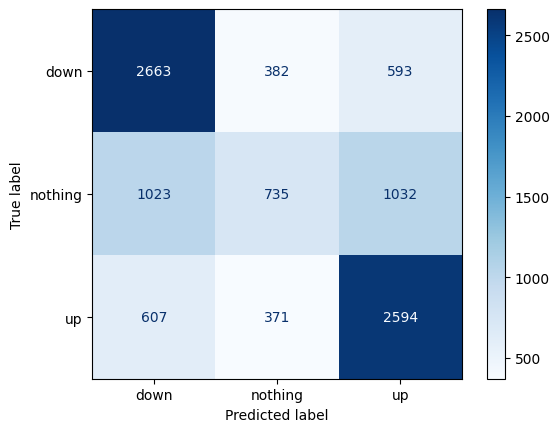

data shape - (9000, 22)


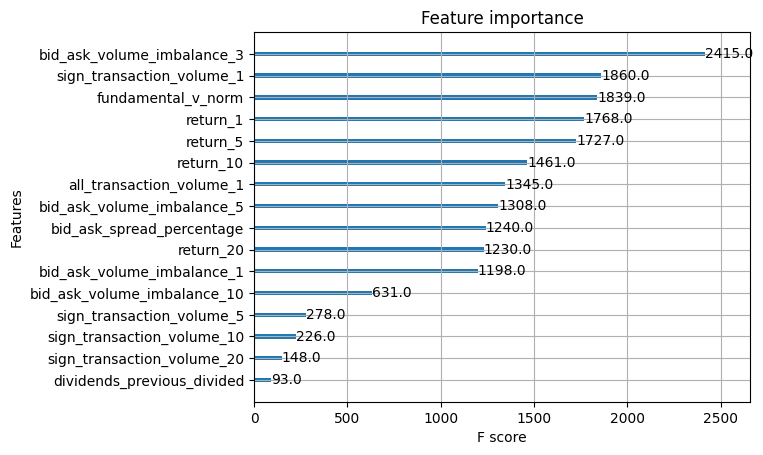

TRAIN accuracy score -  0.63
TEST  accuracy score -  0.56


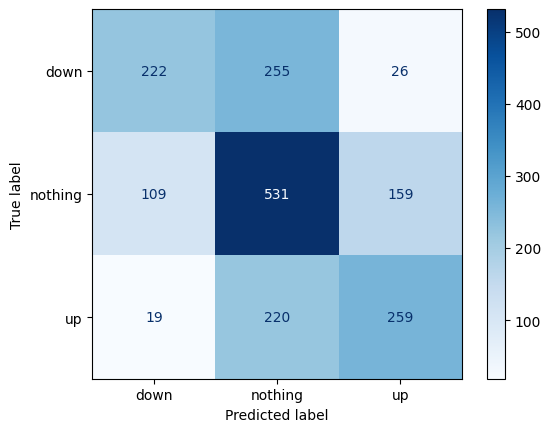

data shape - (4400, 22)


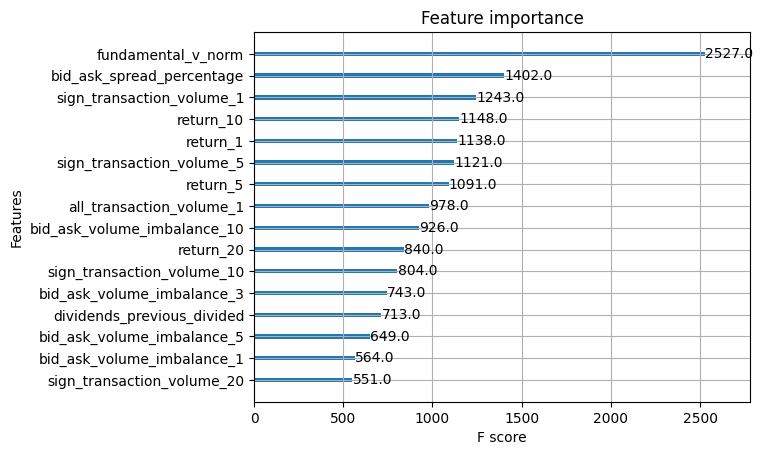

TRAIN accuracy score -  0.67
TEST  accuracy score -  0.57


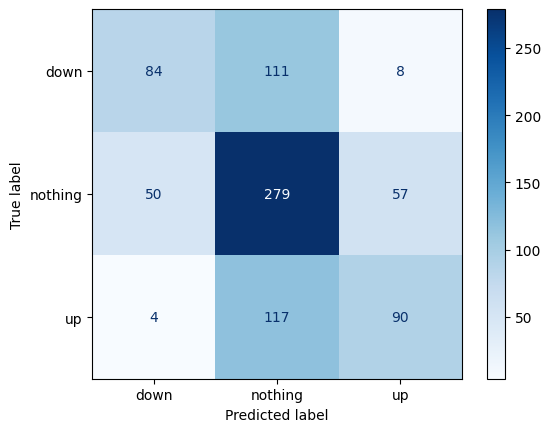

data shape - (45800, 22)


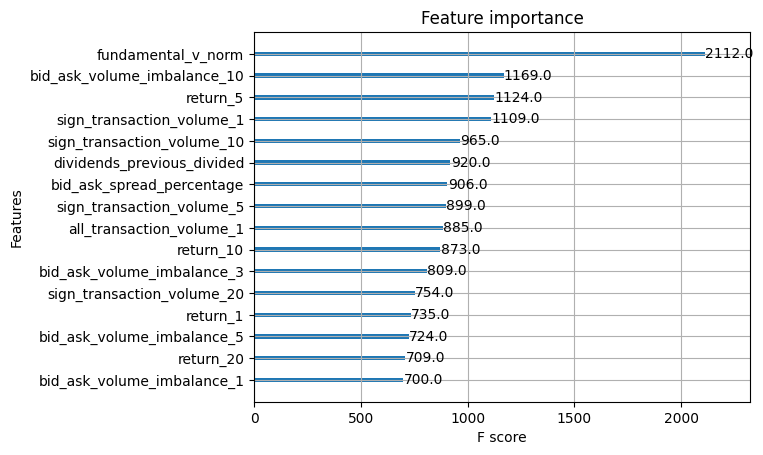

TRAIN accuracy score -  0.56
TEST  accuracy score -  0.54


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


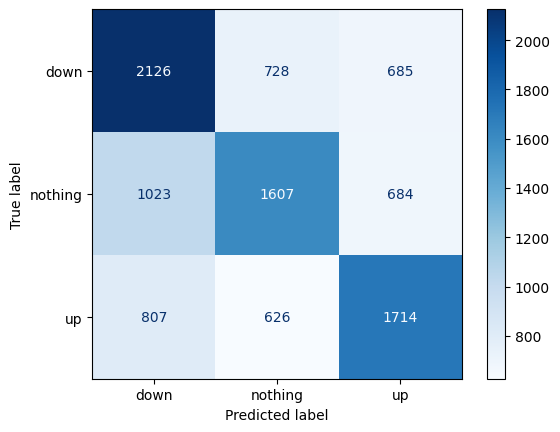

data shape - (9000, 22)


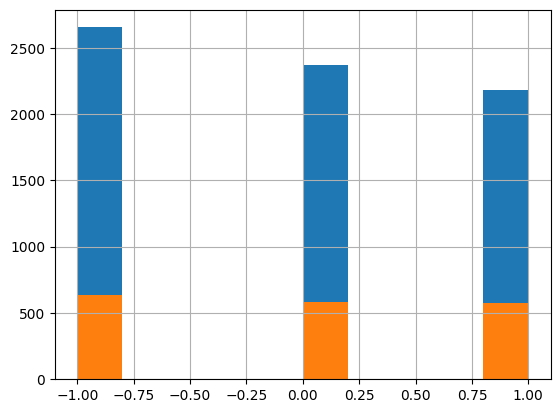

TRAIN accuracy score -  0.57
TEST  accuracy score -  0.56


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


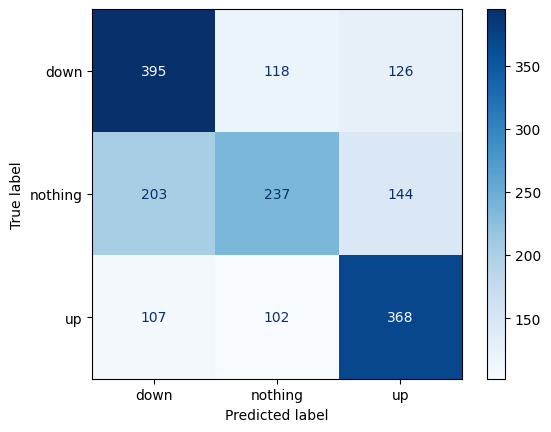

data shape - (4400, 22)


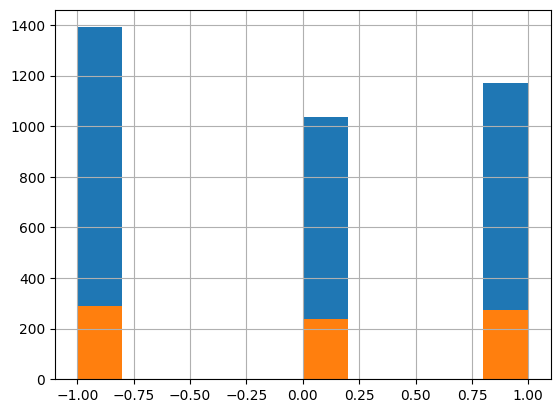

TRAIN accuracy score -  0.57
TEST  accuracy score -  0.55


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


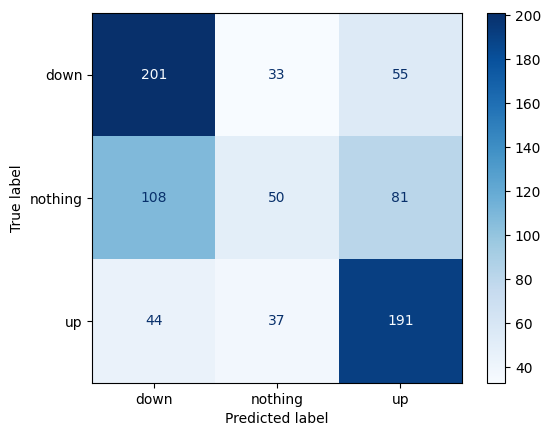

data shape - (45800, 22)


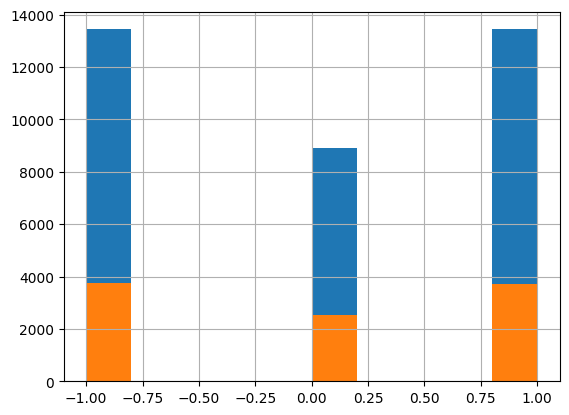

TRAIN accuracy score -  0.54
TEST  accuracy score -  0.53


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


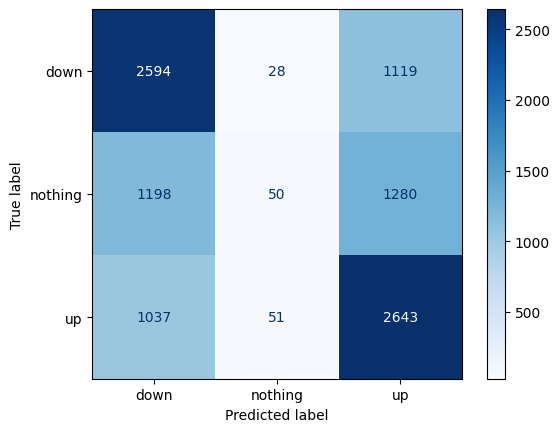

data shape - (9000, 22)


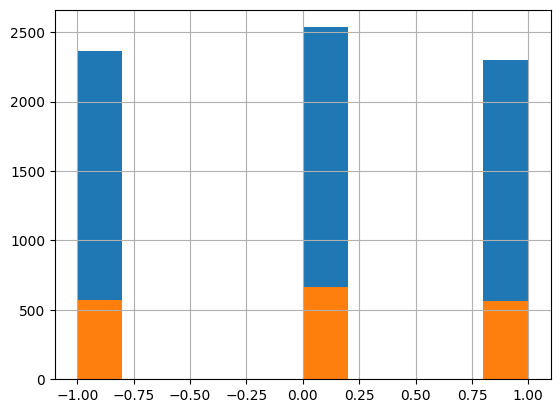

TRAIN accuracy score -  0.44
TEST  accuracy score -  0.45


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


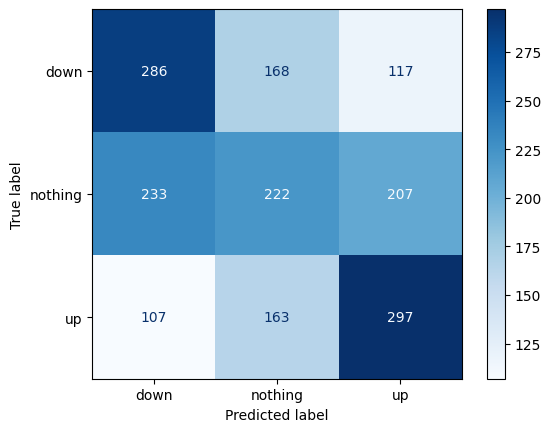

data shape - (4400, 22)


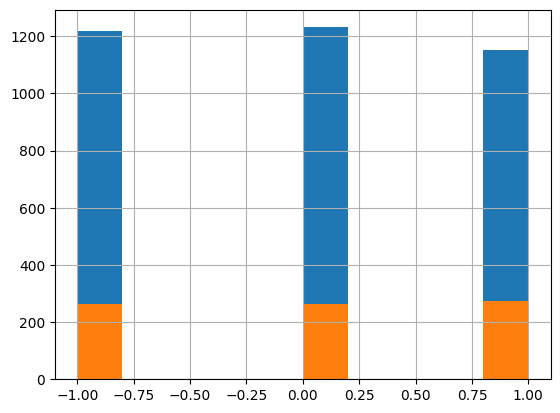

TRAIN accuracy score -  0.45
TEST  accuracy score -  0.42


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


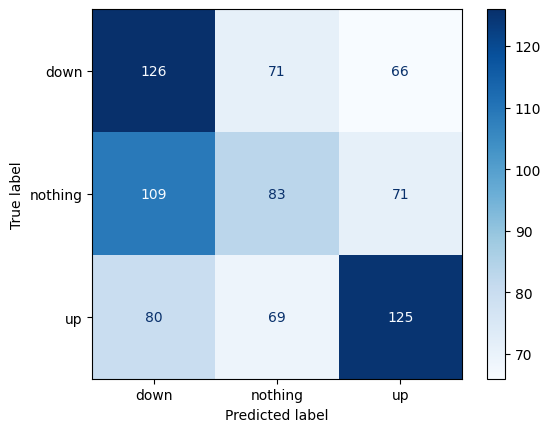

data shape - (45800, 22)


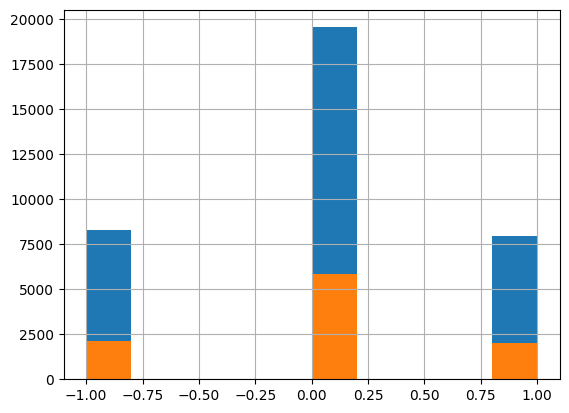

TRAIN accuracy score -  0.59
TEST  accuracy score -  0.61


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


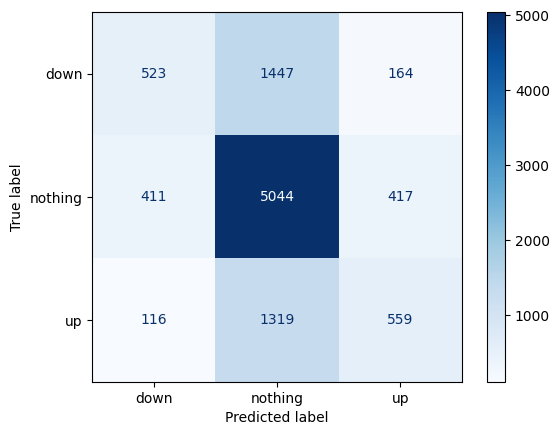

data shape - (9000, 22)


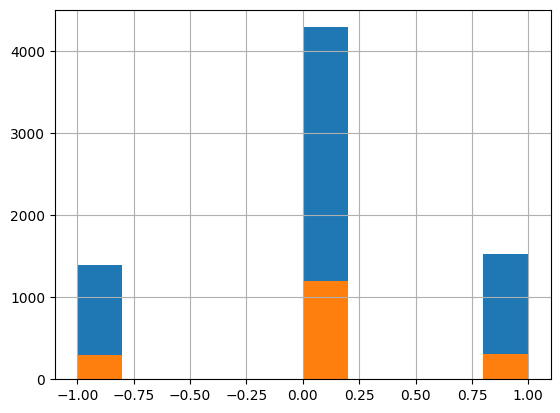

TRAIN accuracy score -  0.64
TEST  accuracy score -  0.69


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


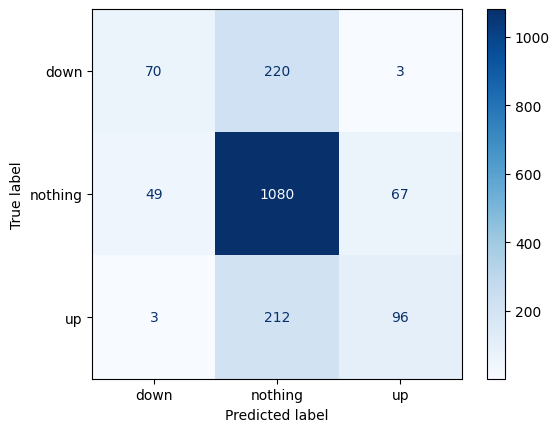

data shape - (4400, 22)


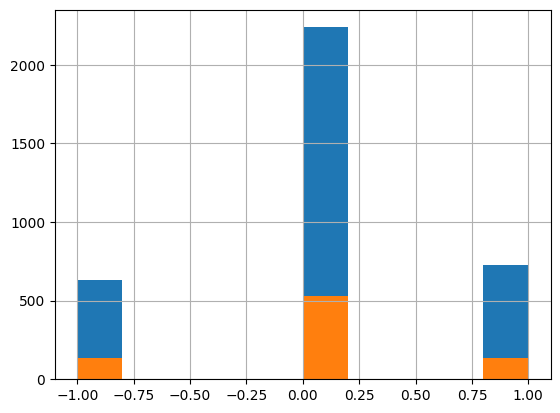

TRAIN accuracy score -  0.66
TEST  accuracy score -  0.71


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


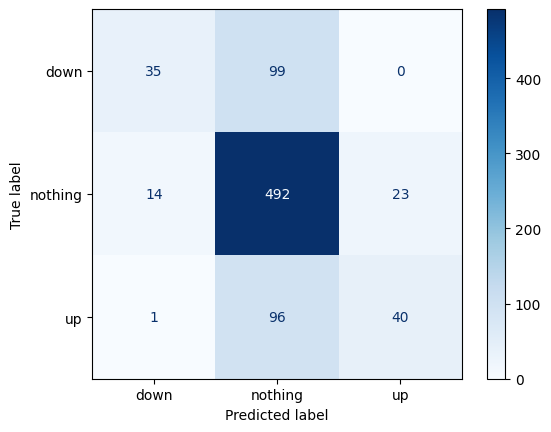

data shape - (45800, 22)


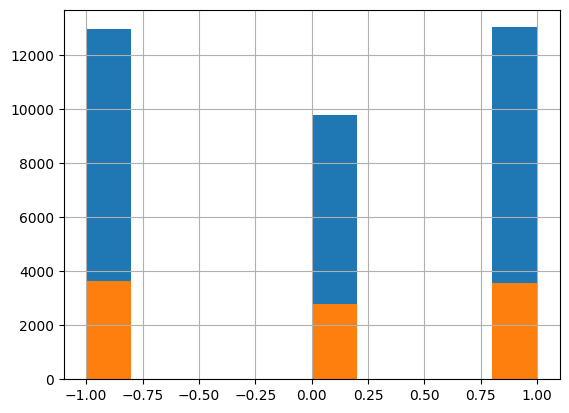

TRAIN accuracy score -  0.53
TEST  accuracy score -  0.52


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


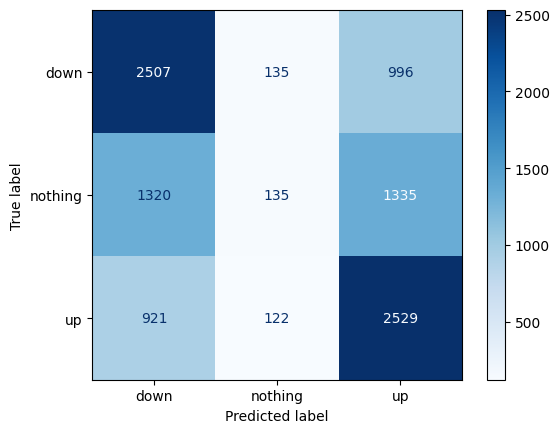

data shape - (9000, 22)


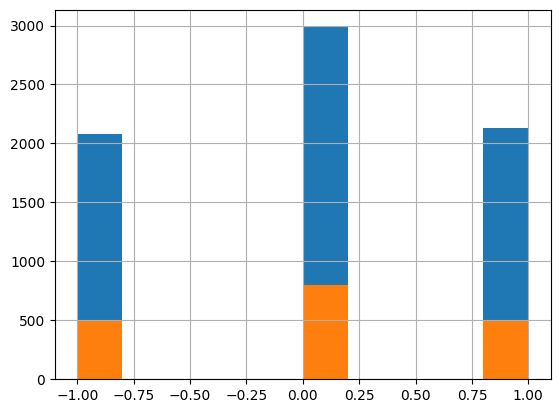

TRAIN accuracy score -  0.47
TEST  accuracy score -  0.49


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


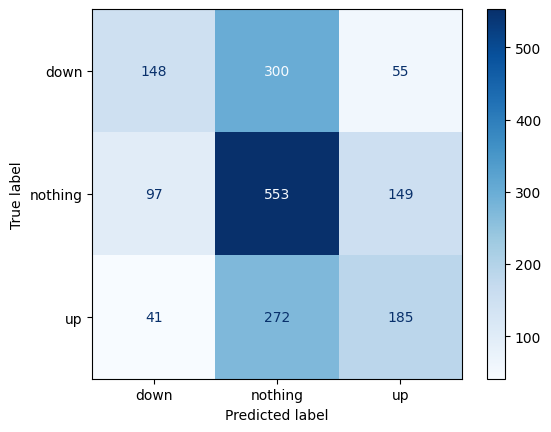

data shape - (4400, 22)


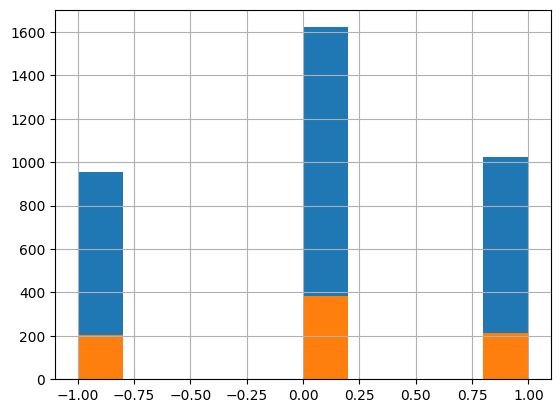

TRAIN accuracy score -  0.48
TEST  accuracy score -  0.49


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


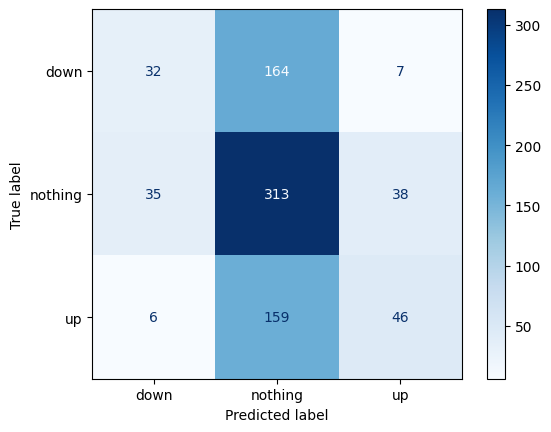

shift_1  shift_1_test  \
accuracy data xgb_depth_3                              0.64          0.61   
accuracy data_no_mm xgb_depth_3                        0.66          0.62   
accuracy data_undervalued xgb_depth_3                  0.69          0.68   
accuracy data_undervalued_no_mm xgb_depth_3            0.66          0.62   
accuracy data xgb_iteration_restrict                   0.63          0.59   
accuracy data_no_mm xgb_iteration_restrict             0.64          0.61   
accuracy data_undervalued xgb_iteration_restrict       0.68          0.67   
accuracy data_undervalued_no_mm xgb_iteration_r...     0.64          0.60   
accuracy data xgb_lower_lr                             0.63          0.59   
accuracy data_no_mm xgb_lower_lr                       0.64          0.61   
accuracy data_undervalued xgb_lower_lr                 0.68          0.67   
accuracy data_undervalued_no_mm xgb_lower_lr           0.64          0.60   
accuracy data logreg                                   0.56          0.54   
accuracy data_no_mm logreg                             0.54          0.53   
accuracy data_undervalued logreg                       0.59          0.61   
accuracy data_undervalued_no_mm logreg                 0.53          0.52   

                                                    shift_5  shift_5_test  \
accuracy data xgb_depth_3                              0.73          0.62   
accuracy data_no_mm xgb_depth_3                        0.69          0.52   
accuracy data_undervalued xgb_depth_3                  0.79          0.74   
accuracy data_undervalued_no_mm xgb_depth_3            0.68          0.57   
accuracy data xgb_iteration_restrict                   0.70          0.61   
accuracy data_no_mm xgb_iteration_restrict             0.64          0.54   
accuracy data_undervalued xgb_iteration_restrict       0.77          0.73   
accuracy data_undervalued_no_mm xgb_iteration_r...     0.64          0.56   
accuracy data xgb_lower_lr                             0.70          0.62   
accuracy data_no_mm xgb_lower_lr                       0.63          0.53   
accuracy data_undervalued xgb_lower_lr                 0.76          0.73   
accuracy data_undervalued_no_mm xgb_lower_lr           0.63          0.56   
accuracy data logreg                                   0.57          0.56   
accuracy data_no_mm logreg                             0.44          0.45   
accuracy data_undervalued logreg                       0.64          0.69   
accuracy data_undervalued_no_mm logreg                 0.47          0.49   

                                                    shift_10  shift_10_test  
accuracy data xgb_depth_3                               0.82           0.57  
accuracy data_no_mm xgb_depth_3                         0.77           0.49  
accuracy data_undervalued xgb_depth_3                   0.85           0.73  
accuracy data_undervalued_no_mm xgb_depth_3             0.77           0.56  
accuracy data xgb_iteration_restrict                    0.75           0.59  
accuracy data_no_mm xgb_iteration_restrict              0.69           0.49  
accuracy data_undervalued xgb_iteration_restrict        0.80           0.72  
accuracy data_undervalued_no_mm xgb_iteration_r...      0.69           0.57  
accuracy data xgb_lower_lr                              0.73           0.60  
accuracy data_no_mm xgb_lower_lr                        0.69           0.50  
accuracy data_undervalued xgb_lower_lr                  0.79           0.73  
accuracy data_undervalued_no_mm xgb_lower_lr            0.67           0.57  
accuracy data logreg                                    0.57           0.55  
accuracy data_no_mm logreg                              0.45           0.42  
accuracy data_undervalued logreg                        0.66           0.71  
accuracy data_undervalued_no_mm logreg                  0.48           0.49

In [460]:
# datasets
all_tested_data = [huge_data, huge_data_no_mm, huge_data_undervalued, huge_data_undervalued_no_mm] #, huge_data_no_mm, huge_data_undervalued, huge_data_undervalued_no_mm] # [huge_data]
all_tested_data_names = ['huge_data', 'huge_data_no_mm', 'huge_data_undervalued', 'huge_data_undervalued_no_mm'] #, 'huge_data_no_mm', 'huge_data_undervalued', 'huge_data_undervalued_no_mm'] # [huge_data]

# Testing xgb for different shifts
shift_percentage = {}
shift_percentage['huge_data'] = [(1, 0.0004), (5, 0.001), (10, 0.0015)]
shift_percentage['huge_data_no_mm'] = [(1, 0.001), (5, 0.0025), (10, 0.003)]
shift_percentage['huge_data_undervalued'] = [(1, 0.0008), (5, 0.0025), (10, 0.004)]
shift_percentage['huge_data_undervalued_no_mm'] = [(1, 0.00105), (5, 0.003), (10, 0.0042)]

#[huge_data, huge_data_no_mm, huge_data_undervalued, huge_data_undervalued_no_mm]

models=[
#     'xgb',
    'xgb_depth_3',
    'xgb_iteration_restrict',
    'xgb_lower_lr',
#     'xgb_l2_reg',
    'logreg',
    ]

all_train_results = pd.DataFrame()

for model_name in models:
    
#     model = models[model_name]
    
    all_train_scores = []
    all_test_scores = []
    
    current_loop_models = []
    
    for i in range(len(all_tested_data)):
        
        model = new_model(model_name)

        dataset = all_tested_data[i]
        name = all_tested_data_names[i]
        settings = shift_percentage[name]

        train_scores = []
        test_scores = []

        for setting in settings:

            m, acc_train, acc_test = classifier_test(model, dataset, shift=setting[0], percentage=setting[1], silent=False, 
                                                     x_columns=None)
        
            train_scores.append(round(acc_train, 2))
            test_scores.append(round(acc_test, 2))
            
            try:
                xgb.plot_importance(m)
            except:
                pass

        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
        
        current_loop_models.append(m)


    train_results = pd.DataFrame()
    
#     draw_importance_xgb(current_loop_models)
    

    for i in range(len(all_tested_data)):
        train_s = all_train_scores[i]
        test_s = all_test_scores[i]

        train_results['accuracy ' + all_tested_data_names[i].replace('huge_', '') + ' ' + model_name] = train_s + test_s

        train_results.index = ['shift_1', 'shift_5', 'shift_10'] + ['shift_1_test', 'shift_5_test', 'shift_10_test']

    train_results = (train_results.T)[['shift_1', 'shift_1_test', 'shift_5', 'shift_5_test', 'shift_10', 'shift_10_test']]
    all_train_results = pd.concat([all_train_results, train_results])

all_train_results

# Data representation

In [101]:
def make_line_graphs(data, columns, figsize=(16, 4)):
    
    colors = ['blue', 'orange', 'green', 'crimson']
    
    n = len(columns)
    
    fig1, axs1 = plt.subplots(nrows=1, ncols=n, figsize=figsize)
        
    fig1.tight_layout()
    
    for i in range(n):
        axs1[i].hist(data[columns[i]], label=columns[i], color=colors[i%4], bins=20) #color=colors[i%4]) // plt.cm.tab10(i)
        axs1[i].legend()
    
    plt.show()

In [102]:
glued = prepare_huge_data(all_data[0], shift=1, percentage=0.00000001).drop(['future_price', 'index', 'difference', 'dividends', 'price'], axis=1)

In [103]:
print(len(glued.columns))
glued.columns

18


Index(['bid_ask_volume_imbalance_1', 'bid_ask_volume_imbalance_3',
       'bid_ask_volume_imbalance_5', 'bid_ask_volume_imbalance_10',
       'sign_transaction_volume_1', 'sign_transaction_volume_5',
       'sign_transaction_volume_10', 'sign_transaction_volume_20',
       'all_transaction_volume_1', 'dividends_previous_divided',
       'fundamental_v', 'return_1', 'return_5', 'return_10', 'return_20',
       'bid_ask_spread_percentage', 'fundamental_v_norm', 'trajectory_number'],
      dtype='object')

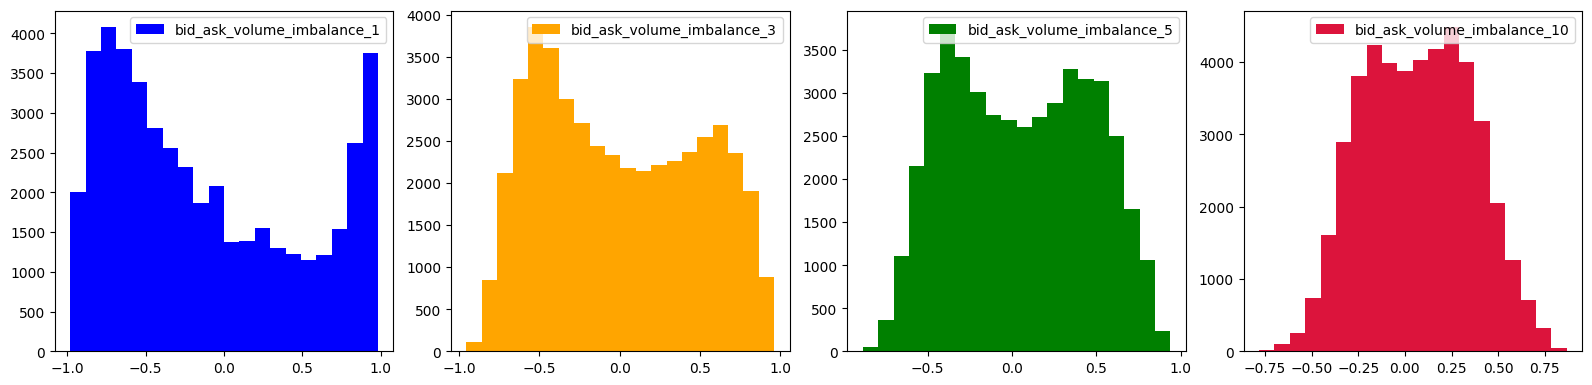

In [104]:
make_line_graphs(glued, ['bid_ask_volume_imbalance_1', 'bid_ask_volume_imbalance_3',
       'bid_ask_volume_imbalance_5', 'bid_ask_volume_imbalance_10'])

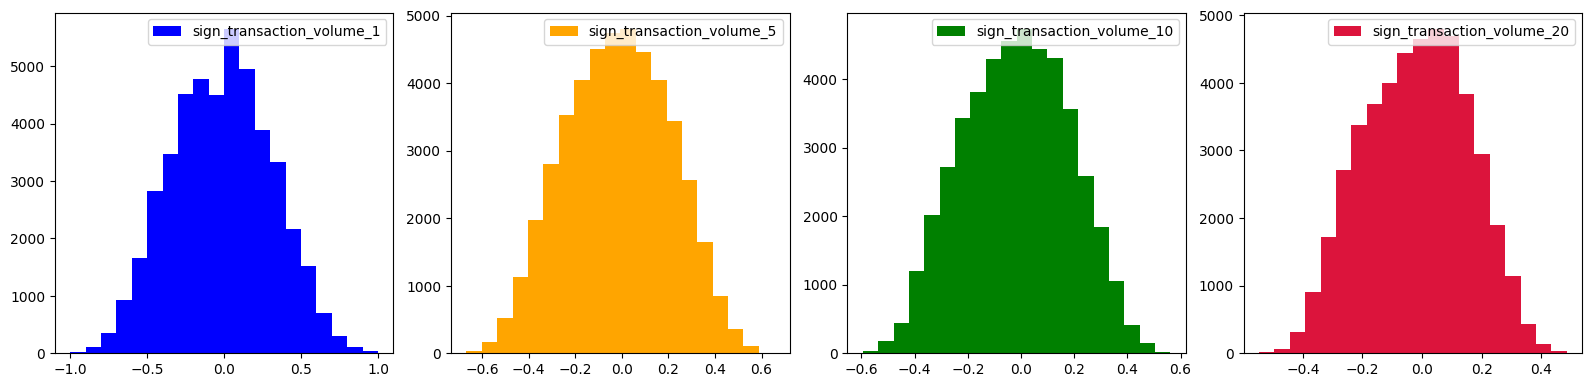

In [105]:
make_line_graphs(glued, ['sign_transaction_volume_1', 'sign_transaction_volume_5',
       'sign_transaction_volume_10', 'sign_transaction_volume_20'])

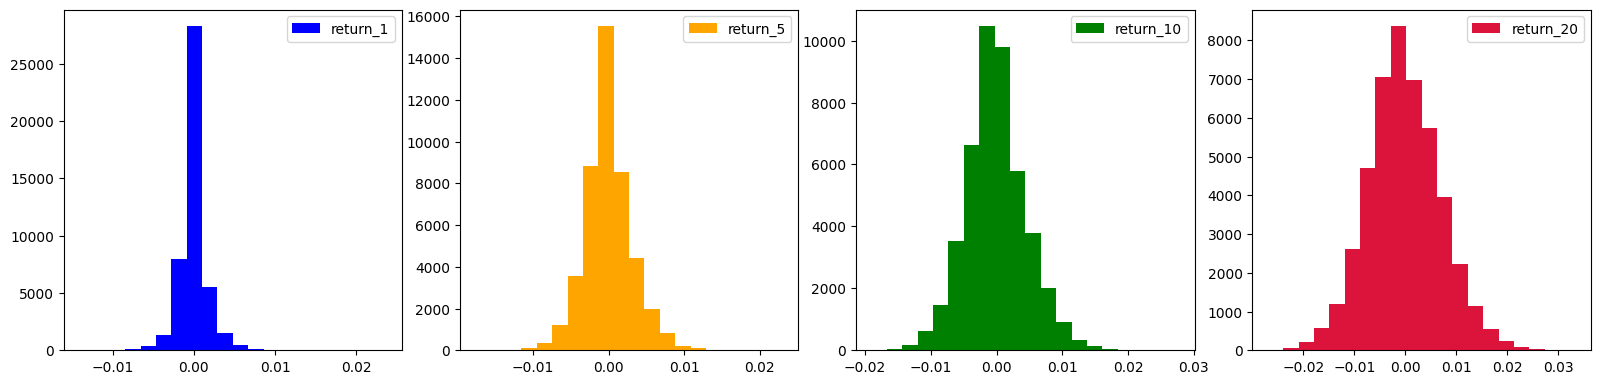

In [106]:
make_line_graphs(glued, ['return_1', 'return_5',
       'return_10', 'return_20'])

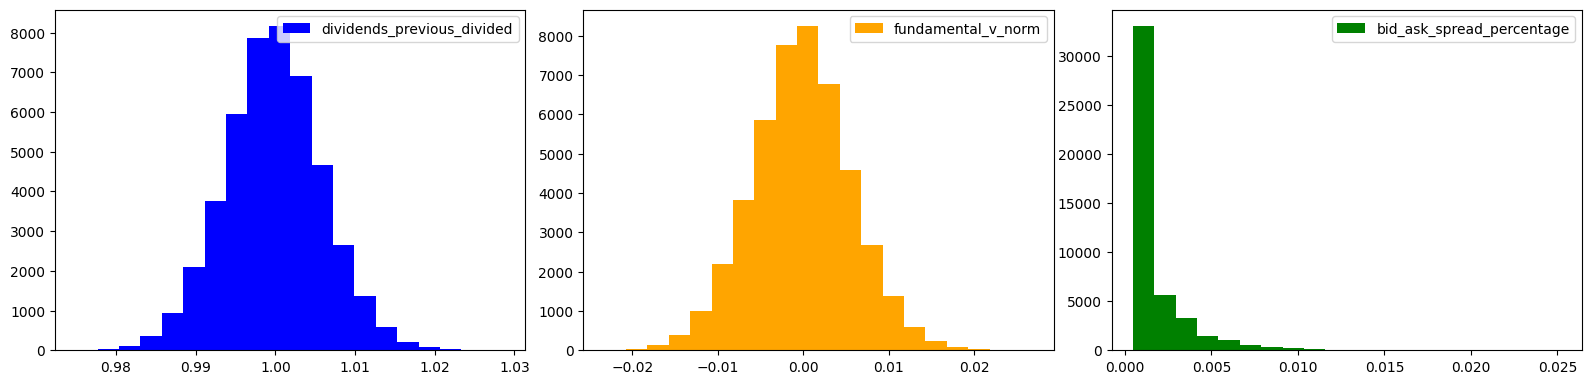

In [107]:
make_line_graphs(glued, ['dividends_previous_divided', 'fundamental_v_norm', 'bid_ask_spread_percentage'])

# Testing classificator in simulation 

In [22]:
class FeatureCollector():
    def __init__(self, sim_info, exchange):
        self.info = sim_info
        self.exchange = exchange
        self.exchange_id = exchange.id
    
    def exchange_get_order_book(self):
        return self.exchange.order_book

    def exchange_get_bids(self):
        return self.exchange_get_order_book()['bid'].to_list()

    def exchange_get_asks(self):
        return self.exchange_get_order_book()['ask'].to_list()

    def exchange_get_spread(self):

        """
        getting bid-ask spread as a difference between best ask and bid prices 
        for last tick in a simulation
        """

        bid_ask_spread = self.exchange.spread()
        return round(bid_ask_spread['ask'] - bid_ask_spread['bid'], 4)

    def exchange_get_bid_ask_volume_imbalance(self, depth=1000):

        """
        Bid-Ask Volume Imbalance: A signed quantity indicating the number of shares at the bid
        minus the number of shares at the ask in the current order books.
        """

        bids = self.exchange_get_bids()
        asks = self.exchange_get_asks()

        bids_qty = pd.DataFrame(bids)
        asks_qty = pd.DataFrame(asks)

        bids_level = bids_qty['price'].unique()
        bids_level = bids_level[min(depth, len(bids_level) - 1)]

        asks_level = asks_qty['price'].unique()
        asks_level = asks_level[min(depth, len(asks_level) - 1)]

        bids_qty = bids_qty[bids_qty.price >= bids_level]
        asks_qty = asks_qty[asks_qty.price <= asks_level]

        bids_qty = bids_qty['qty'].sum()
        asks_qty = asks_qty['qty'].sum()

        return (bids_qty - asks_qty)/(bids_qty + asks_qty)

    def exchange_get_transaction_volume(self, limit=15):

        """
        Signed Transaction Volume: A signed quantity indicating the number of shares bought in the
        last 15 seconds minus the number of shares sold in the last 15 seconds.
        """

        transactions = pd.DataFrame(self.exchange.transactions.transactions, 
                                    columns=['time', 'price', 'quantity', 'side', 'trader_link'])

        time_values = sorted(transactions['time'].unique())

        limit = min(limit, len(time_values))

        if limit == 0:
            return 0

        transactions = transactions[transactions['time'] >= time_values[-limit]]

        total_buy = transactions[transactions['side'] == 'bid']['quantity'].sum()      # fulfilled bid orders - buy
        total_sell = transactions[transactions['side'] == 'ask']['quantity'].sum()     # fulfilled ask orders - sell

        return (total_buy - total_sell) / (total_buy + total_sell)

    def exchange_get_all_transaction_volume(self, limit=15):

        """
        Signed Transaction Volume: A signed quantity indicating the number of shares bought in the
        last 15 seconds minus the number of shares sold in the last 15 seconds.
        """

        transactions = pd.DataFrame(self.exchange.transactions.transactions, 
                                    columns=['time', 'price', 'quantity', 'side', 'trader_link'])

        time_values = sorted(transactions['time'].unique())

        limit = min(limit, len(time_values))

        if limit == 0:
            return 0

        transactions = transactions[transactions['time'] >= time_values[-limit]]

        total_buy = transactions[transactions['side'] == 'bid']['quantity'].sum()      # fulfilled bid orders - buy
        total_sell = transactions[transactions['side'] == 'ask']['quantity'].sum()     # fulfilled ask orders - sell

        return (total_buy + total_sell)
    
    def get_features(self, limit=15, 
                         bid_ask_volume_imbalance_window = [1, 3, 5, 10], sign_transaction_volume_window = [1, 5, 10, 20]):
        
        exchange=self.exchange
        info=self.info
        
        feature_list = {}
        col_names = []

        for w in bid_ask_volume_imbalance_window:

            bid_ask_volume_imbalance_w = self.exchange_get_bid_ask_volume_imbalance(depth=w)
            
            feature_list[f"bid_ask_volume_imbalance_{w}"] = bid_ask_volume_imbalance_w

        for w in sign_transaction_volume_window:

            sign_transaction_volume_w = self.exchange_get_transaction_volume(limit=w)
            
            feature_list[f"sign_transaction_volume_{w}"] = sign_transaction_volume_w
        
        feature_list["all_transaction_volume_1"] = self.exchange_get_all_transaction_volume(limit=1)
        
        result_df = pd.DataFrame(feature_list, index=[0])

        bid_ask_spread = self.exchange_get_spread()

        result_df['bid_ask_spread'] = [bid_ask_spread]

        result_df['dividends'] = [exchange.dividend()]

        result_df['price'] = [exchange.price()]

        result_df['dividends_previous_divided'] = (result_df['dividends'] / (exchange.price() * exchange.risk_free_rate))
    
        fundamental_value_data = info.fundamental_value(exchange.id)[-1]

        result_df['fundamental_v'] = [fundamental_value_data]

        prices = info.prices[exchange.id]

        if len(prices) >= 20:
            result_df['return_1'] = ((result_df['price'] - prices[-1])/result_df['price']) #*100
            result_df['return_5'] = ((result_df['price'] - prices[-5])/result_df['price']) #*100
            result_df['return_10'] = ((result_df['price'] - prices[-10])/result_df['price']) #*100
            result_df['return_20'] = ((result_df['price'] - prices[-20])/result_df['price']) #*100

        elif len(prices) >= 10:
            result_df['return_1'] = ((result_df['price'] - prices[-1])/result_df['price']) #*100
            result_df['return_5'] = ((result_df['price'] - prices[-5])/result_df['price']) #*100
            result_df['return_10'] = ((result_df['price'] - prices[-10])/result_df['price']) #*100
            result_df['return_20'] = [0]

        elif len(prices) >= 5:
            result_df['return_1'] = ((result_df['price'] - prices[-1])/result_df['price']) #*100
            result_df['return_5'] = ((result_df['price'] - prices[-5])/result_df['price']) #*100
            result_df['return_10'] = [0]
            result_df['return_20'] = [0]

        elif len(prices) >= 1:
            result_df['return_1'] = ((result_df['price'] - prices[-1])/result_df['price']) #*100
            result_df['return_5'] = [0]
            result_df['return_10'] = [0]
            result_df['return_20'] = [0]

        else:
            result_df['return_1'] = [0]
            result_df['return_5'] = [0]
            result_df['return_10'] = [0]
            result_df['return_20'] = [0]
            
            
        result_df['bid_ask_spread_percentage'] = result_df['bid_ask_spread'] / result_df['price']
        
        result_df['fundamental_v_norm'] = result_df['fundamental_v'] / result_df['price'] - 1

        return result_df.drop(['bid_ask_spread', 'dividends', 'price', 'fundamental_v'], axis=1)

In [23]:
# given_model, acc_t, acc_e = classifier_test(new_model('xgb_depth_3'), huge_data, shift=shift_percentage['huge_data'][0][0], percentage=shift_percentage['huge_data'][0][1], silent=True, x_columns=None, trajectory_test_split=1)

In [24]:
given_model_1, acc_t, acc_e = classifier_test(new_model('xgb_depth_3'), huge_data, shift=shift_percentage['huge_data'][0][0], percentage=shift_percentage['huge_data'][0][1], silent=True, x_columns=None, trajectory_test_split=1)
given_model_5, acc_t, acc_e = classifier_test(new_model('xgb_depth_3'), huge_data, shift=shift_percentage['huge_data'][1][0], percentage=shift_percentage['huge_data'][1][1], silent=True, x_columns=None, trajectory_test_split=1)
given_model_10, acc_t, acc_e = classifier_test(new_model('xgb_depth_3'), huge_data, shift=shift_percentage['huge_data'][2][0], percentage=shift_percentage['huge_data'][2][1], silent=True, x_columns=None, trajectory_test_split=1)

In [25]:
from AgentBasedModel.traders import ModelTrader

In [88]:
def evaluate_agent(simple_exchange, agent, max_iteration=-1):
    val = 1000
    eq = 0
    
    transactions = pd.DataFrame(simple_exchange.transactions.transactions, columns=['id', 'price', 'qty', 'side', 'trader_id'])
    
    if max_iteration >= 0:
        transactions = transactions[transactions['id'] <= max_iteration]
    
    agent_transactions = transactions[transactions['trader_id'] == agent]
    
    if agent_transactions.shape[0] == 0:
        return 0
    
    for i in range(agent_transactions.shape[0]):

        if agent_transactions['side'].values[i] == 'bid':
            eq += agent_transactions['qty'].values[i]
            val -= agent_transactions['qty'].values[i] * agent_transactions['price'].values[i]

        elif agent_transactions['side'].values[i] == 'ask':
            eq -= agent_transactions['qty'].values[i]
            val += agent_transactions['qty'].values[i] * agent_transactions['price'].values[i]

    #     val += max(simple_sim.info.dividends[simple_exchange.id][i] * eq, 0)
    #     val = val * (1.05)

#     print(eq, val)
#     print('profit:', eq * agent_transactions['price'].values[-1] + val - 1000)
    
    return eq * agent_transactions['price'].values[-1] + val - 1000
    

In [55]:
assets = Stock(10)
simple_exchange = ExchangeAgent(assets, 0.05, mean=200)

# agent = ModelTrader(simple_exchange, model=model, timing=timing)

simple_traders = [
    *[Random(simple_exchange) for _ in range(40)],
    *[Chartist1D(simple_exchange) for _ in range(40)],
    *[Fundamentalist(simple_exchange) for _ in range(40)],
    *[MarketMaker1D(simple_exchange) for _ in range(1)],
]

simple_sim = Simulator(**{
    'assets': [assets],
    'exchanges': [simple_exchange],
    'traders': simple_traders
    })

FC_1 = FeatureCollector(simple_sim.info, simple_exchange)

In [28]:
simple_sim.simulate(1)

Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.41it/s]


In [29]:
simple_exchange.price()

200.2

In [30]:
FC_1.get_features()

bid_ask_volume_imbalance_1  bid_ask_volume_imbalance_3  \
0                    0.011364                   -0.026178   

   bid_ask_volume_imbalance_5  bid_ask_volume_imbalance_10  \
0                   -0.043902                     0.015873   

   sign_transaction_volume_1  sign_transaction_volume_5  \
0                   -0.06383                   -0.06383   

   sign_transaction_volume_10  sign_transaction_volume_20  \
0                    -0.06383                    -0.06383   

   all_transaction_volume_1  dividends_previous_divided  return_1  return_5  \
0                        47                    0.999001    0.0005         0   

   return_10  return_20  bid_ask_spread_percentage  fundamental_v_norm  
0          0          0                   0.000999           -0.000999

In [56]:
random.seed(21009)

# assets = Stock(10)

# simple_exchange = ExchangeAgent(assets, 0.05, mean=200)

# agent_001 = ModelTrader(simple_exchange, model=given_model_1, timing=1)
# agent_005 = ModelTrader(simple_exchange, model=given_model_5, timing=5)
# agent_010 = ModelTrader(simple_exchange, model=given_model_10, timing=10)

def simulate_agent_pnl(model, timing, random_seed=99, n_iter=200):
    
    random.seed(random_seed)
    
    assets = Stock(10)
    simple_exchange = ExchangeAgent(assets, 0.05, mean=200)
    
    agent = ModelTrader(simple_exchange, model=model, timing=timing)
    
    simple_traders = [
        *[Random(simple_exchange) for _ in range(40)],
        *[Chartist1D(simple_exchange) for _ in range(40)],
        *[Fundamentalist(simple_exchange) for _ in range(40)],
        *[MarketMaker1D(simple_exchange) for _ in range(1)],
        *[agent],
    ]
    
    simple_sim = Simulator(**{
    'assets': [assets],
    'exchanges': [simple_exchange],
    'traders': simple_traders
    })
    
    FC_1 = FeatureCollector(simple_sim.info, simple_exchange)
    
    agent.set_feature_extractor(FC_1)
    
    features_simulation_data = simulation_with_data(simple_sim, simple_exchange.id, n_iter, random_state=random_seed, class_division=False)
    
    transactions = pd.DataFrame(simple_exchange.transactions.transactions, columns=['id', 'price', 'qty', 'side', 'trader_id'])
    
#     return transactions
#     print(agent.predictions)
    
    agent_transactions = transactions[transactions['trader_id'] == agent]
    
    evaluate_agent(simple_exchange, agent)
    
    return features_simulation_data, agent

# simple_sim.simulate(1)

In [42]:
# history_1, agent_1 = simulate_agent_pnl(model=given_model_1, timing=1, n_iter=2000)
history_5, agent_5 = simulate_agent_pnl(model=given_model_5, timing=5, n_iter=2000)
history_10, agent_10 = simulate_agent_pnl(model=given_model_10, timing=10, n_iter=2000)

100%|██████████| 2000/2000 [08:53<00:00,  3.75it/s]


0 1238.2
profit: 238.20000000000005


100%|██████████| 2000/2000 [08:53<00:00,  3.75it/s]

0 1415.2000000000012
profit: 415.2000000000012


In [273]:
meeen = 0
for i in range(10):
    history_10, agent_10 = simulate_agent_pnl(model=limited_models_10[3], timing=10, n_iter=200, random_seed=meeen)
    meeen += evaluate_agent(agent_10.market, agent_10)
    
print(meeen/10)

100%|██████████| 200/200 [00:14<00:00, 14.05it/s]

19.790000000000056


In [274]:
meeen = 0
for i in range(10):
    history_10, agent_10 = simulate_agent_pnl(model=limited_models_10[0], timing=10, n_iter=200, random_seed=meeen)
    evaluate_agent(agent_10.market, agent_10)
    meeen += evaluate_agent(agent_10.market, agent_10)

print(meeen/10)

100%|██████████| 200/200 [00:15<00:00, 13.31it/s]


10.409999999999808


0 1006.6999999999998
profit: 6.699999999999818
0 1021.3
profit: 21.299999999999955
0 1045.7000000000007
profit: 45.70000000000073
-10 2981.8999999999996
profit: 26.899999999999636
0 1066.400000000001
profit: 66.400000000001
0 1077.1
profit: 77.09999999999991
10 -891.2999999999988
profit: 83.70000000000118
-11 3148.3
profit: 81.40000000000009
0 1080.7000000000007
profit: 80.70000000000073
-11 3128.3999999999996
profit: 175.89999999999964
0 1108.000000000001
profit: 108.00000000000091
11 -801.2000000000005
profit: 162.2999999999995
0 1123.7000000000007
profit: 123.70000000000073
-11 3156.199999999999
profit: 176.1999999999989
10 -797.1999999999995
profit: 130.80000000000064
0 1183.599999999999
profit: 183.599999999999
-11 3228.2000000000007
profit: 182.20000000000073
0 1188.5999999999995
profit: 188.59999999999945
0 1175.8000000000006
profit: 175.80000000000064
0 1235.0999999999992
profit: 235.09999999999923
0 1186.8000000000004
profit: 186.8000000000004
-11 3270.5
profit: 260.8000000000

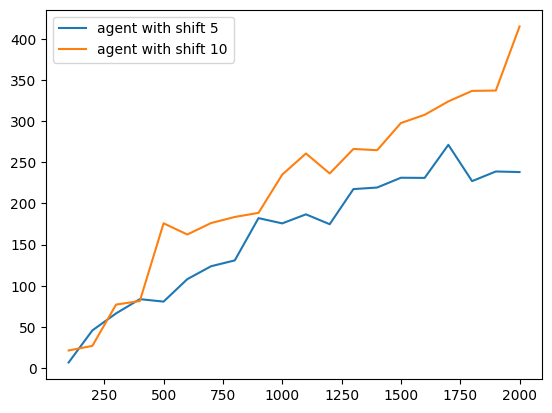

In [51]:
results_5 = []
results_10 = []

x = []

for i in range(100, 2001, 100):
    x.append(i)
    results_5.append(evaluate_agent(agent_5.market, agent_5, max_iteration=i))
    results_10.append(evaluate_agent(agent_10.market, agent_10, max_iteration=i))
    
plt.plot(x, results_5, label='agent with shift 5')
plt.plot(x, results_10, label='agent with shift 10')

plt.legend()

In [57]:
test_results_5 = []
test_results_10 = []

random_seed = 2199

for i in range(100):
    
    random_seed += 1
    
    history_5, agent_5 = simulate_agent_pnl(model=given_model_5, timing=5, n_iter=200, random_seed=random_seed)
    history_10, agent_10 = simulate_agent_pnl(model=given_model_10, timing=10, n_iter=200, random_seed=random_seed)
    
    test_results_5.append(agent_5)
    test_results_10.append(agent_10)

100%|██████████| 200/200 [00:17<00:00, 11.34it/s]


100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


In [62]:
test_results_5[0]

Trader1584

In [449]:
x = range(1, 201)

all_tests_5 = []
all_tests_10 = []

for agent_index in range(100):
    cur_test_5 = []
    cur_test_10 = []
    
    cur_agent_5 = test_results_5[agent_index]
    cur_agent_10 = test_results_10[agent_index]
    
    for i in range(200):
        
        res_5 = evaluate_agent(cur_agent_5.market, cur_agent_5, max_iteration=i)
        res_10 = evaluate_agent(cur_agent_10.market, cur_agent_10, max_iteration=i)
        
        cur_test_5.append(res_5)
        cur_test_10.append(res_10)
        
    all_tests_5.append(cur_test_5)
    all_tests_10.append(cur_test_10)
    
for i in range(len(all_tests_5)):
    new = pd.DataFrame()
    new['return_5'] = all_tests_5[i]
    all_tests_5[i] = new
    
for i in range(len(all_tests_10)):
    new = pd.DataFrame()
    new['return_10'] = all_tests_10[i]
    all_tests_10[i] = new

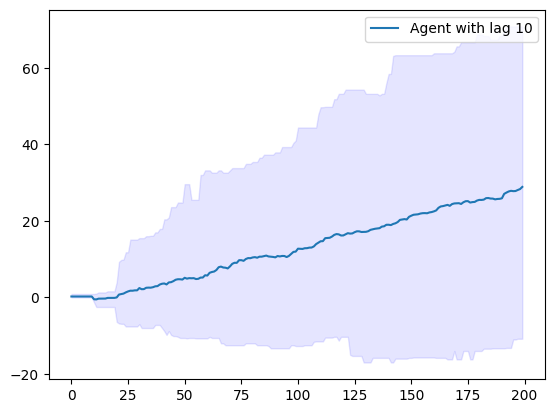

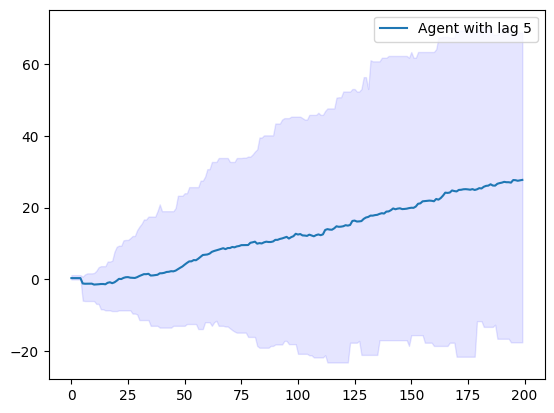

In [450]:
mean_10, q_l, q_u = draw_mean_quantile(all_tests_10, 'return_10', 0.9, x=200, title='Agent with lag 10');
mean_5, q_l, q_u = draw_mean_quantile(all_tests_5, 'return_5', 0.9, x=200, title='Agent with lag 5');

In [211]:
print(mean_10[-1], mean_5[-1])

28.875999999999994 27.704000000000004


In [150]:
# m_v_10 = draw_mean_variance(all_tests_10, 'return_10', x=200)

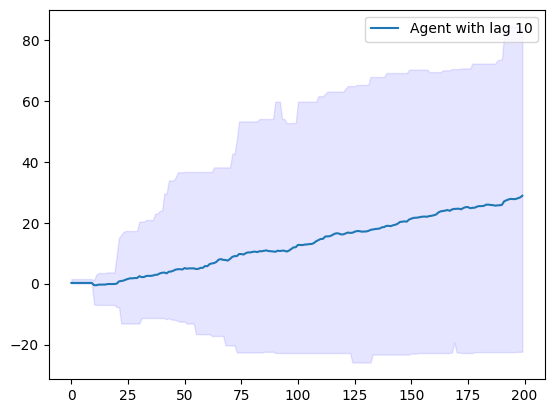

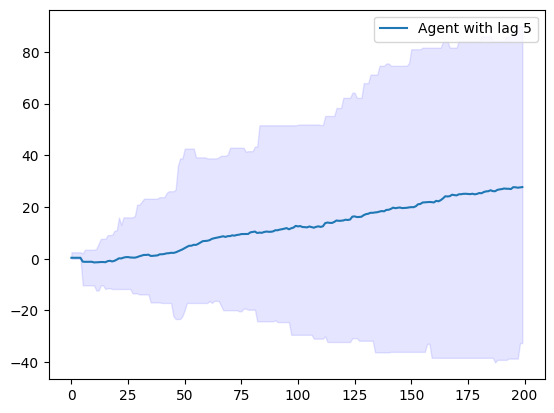

In [154]:
mean_10, q_l, q_u = draw_mean_quantile(all_tests_10, 'return_10', 0.95, x=200, title='Agent with lag 10');
mean, q_l, q_u = draw_mean_quantile(all_tests_5, 'return_5', 0.95, x=200, title='Agent with lag 5')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

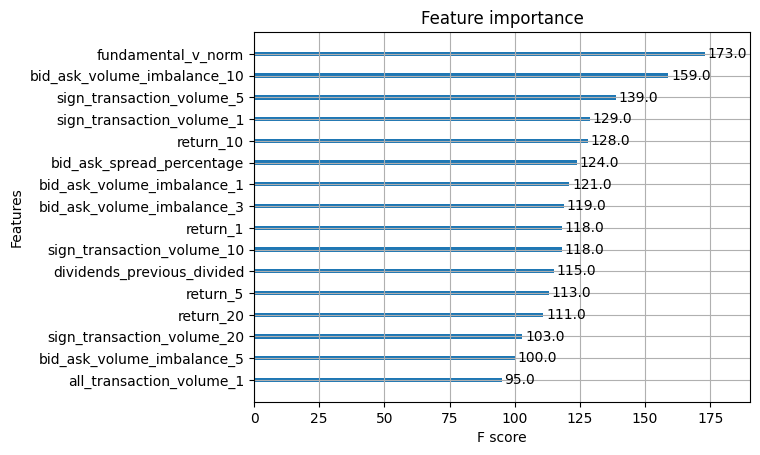

In [159]:
xgb.plot_importance(test_results_10[0].model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

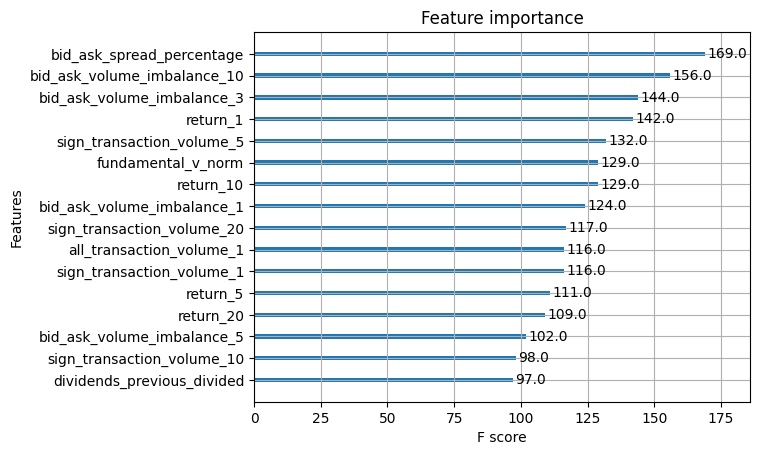

In [162]:
xgb.plot_importance(test_results_5[0].model)

# Limited train models

In [315]:
import matplotlib.pyplot as plt

In [283]:
huge_data_100 = huge_data[:100]
huge_data_50 = huge_data[:50]
huge_data_25 = huge_data[:25]
huge_data_10 = huge_data[:10]

limited_data = [huge_data_100, huge_data_50, huge_data_25, huge_data_10]

data shape - (4500, 23)


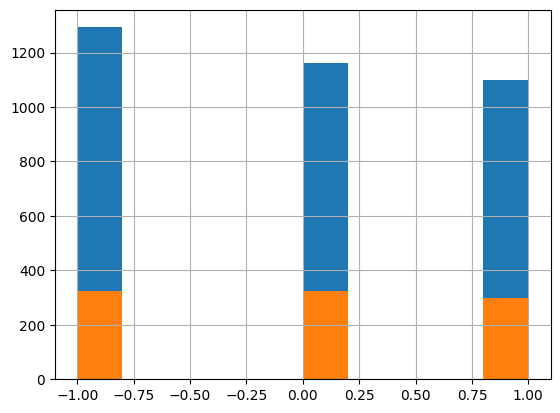

TRAIN accuracy score -  0.8
TEST  accuracy score -  0.6


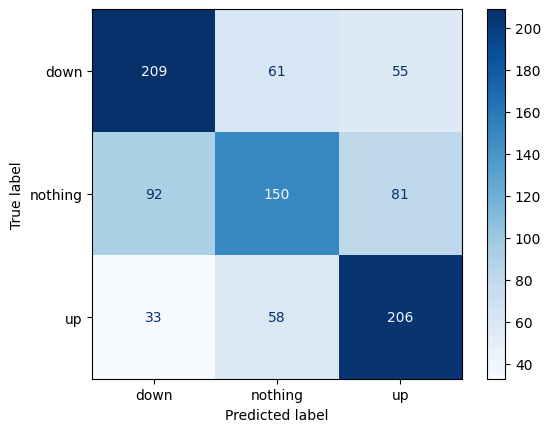

data shape - (2200, 23)


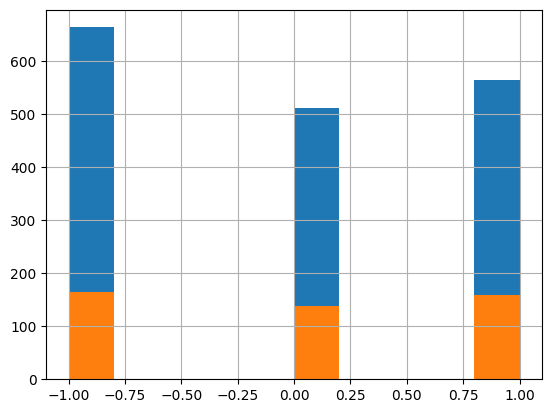

TRAIN accuracy score -  0.91
TEST  accuracy score -  0.54


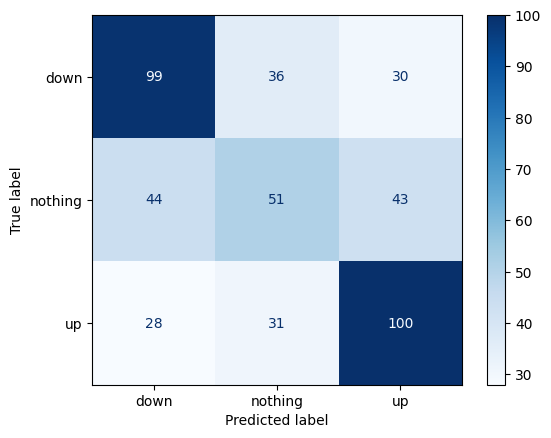

data shape - (2250, 23)


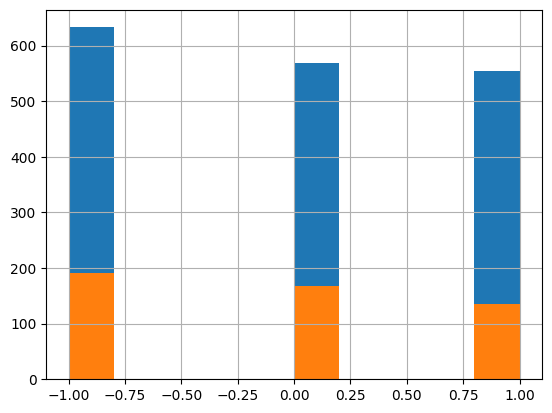

TRAIN accuracy score -  0.92
TEST  accuracy score -  0.6


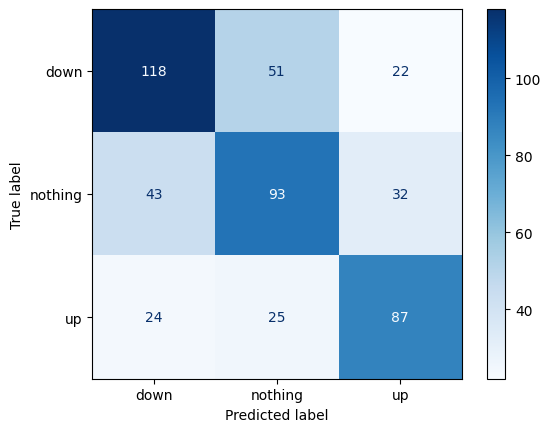

data shape - (1100, 23)


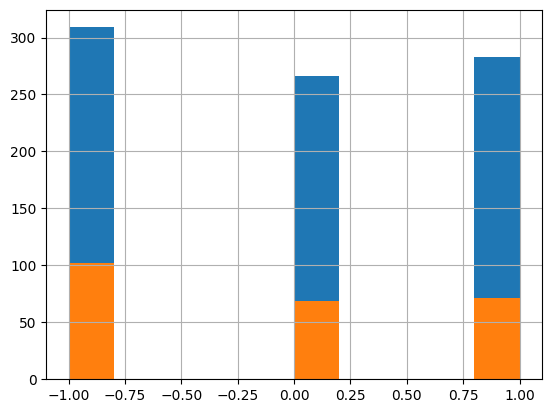

TRAIN accuracy score -  1.0
TEST  accuracy score -  0.56


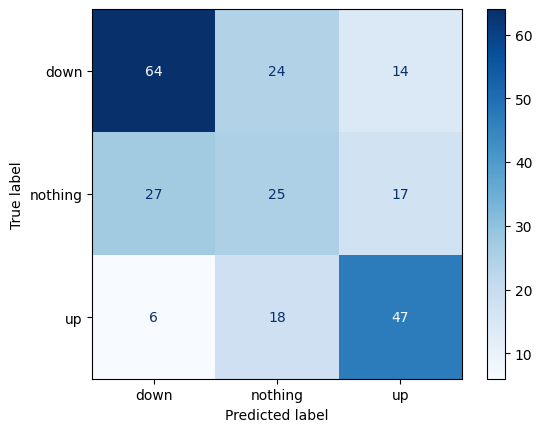

data shape - (1125, 23)


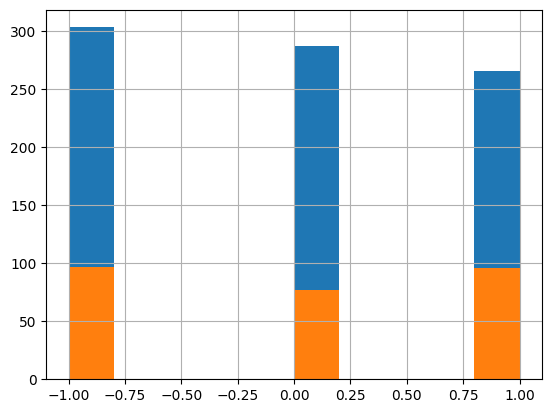

TRAIN accuracy score -  1.0
TEST  accuracy score -  0.6


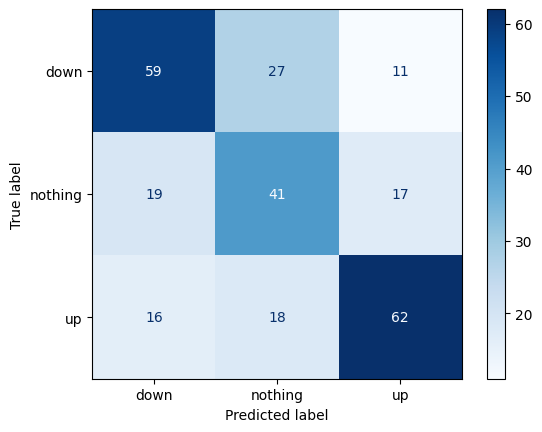

data shape - (550, 23)


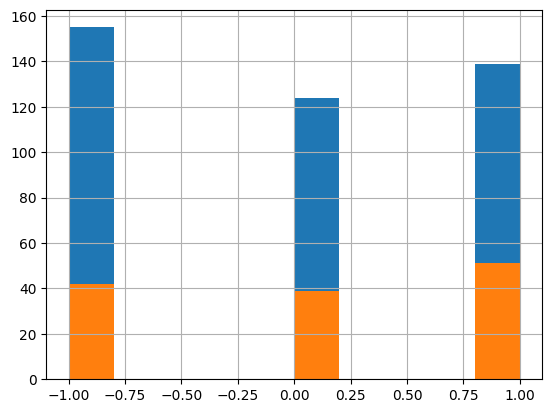

TRAIN accuracy score -  1.0
TEST  accuracy score -  0.47


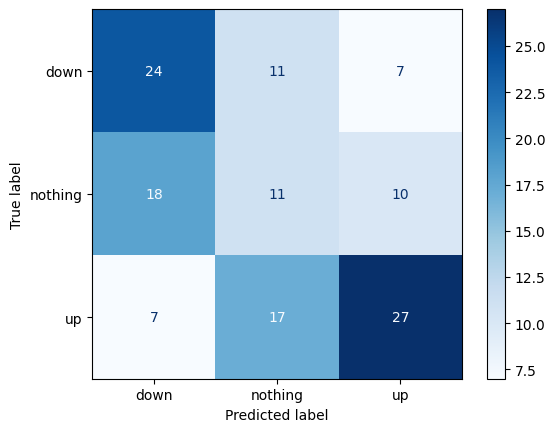

data shape - (450, 23)


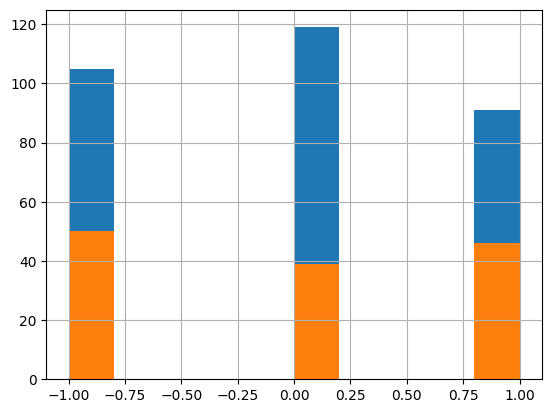

TRAIN accuracy score -  1.0
TEST  accuracy score -  0.55


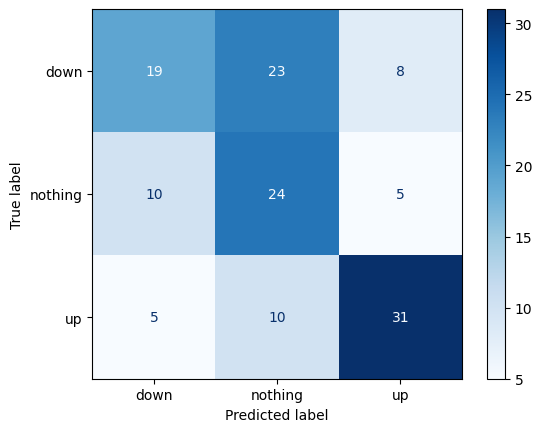

data shape - (220, 23)


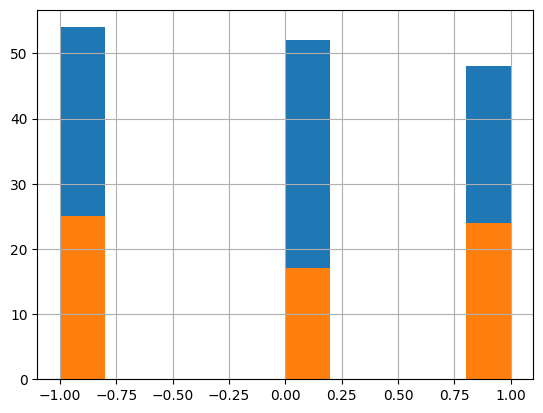

TRAIN accuracy score -  1.0
TEST  accuracy score -  0.45


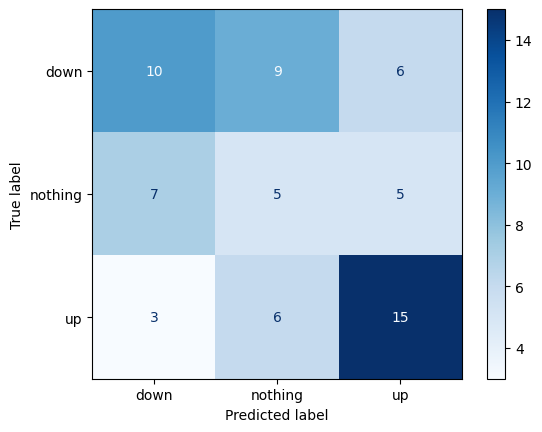

data shape - (4400, 23)


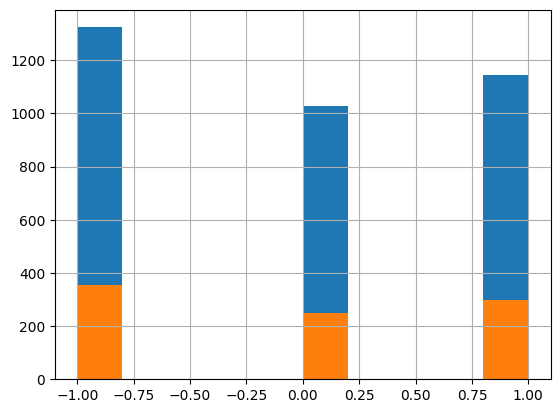

TRAIN accuracy score -  0.81
TEST  accuracy score -  0.59


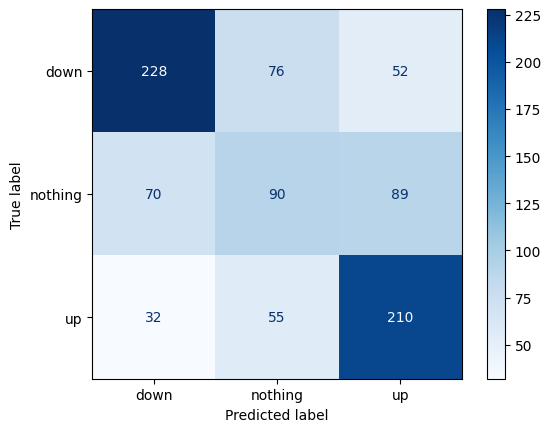

In [319]:
for dataset in limited_data:
    limited_model_5, acc_t, acc_e_5_ = classifier_test(new_model('xgb_depth_3'), dataset, shift=shift_percentage['huge_data'][1][0], percentage=shift_percentage['huge_data'][1][1], silent=False, x_columns=None, trajectory_test_split=1)
    limited_model_10, acc_t, acc_e_10_ = classifier_test(new_model('xgb_depth_3'), dataset, shift=shift_percentage['huge_data'][2][0], percentage=shift_percentage['huge_data'][2][1], silent=False, x_columns=None, trajectory_test_split=1)
    
unlimited_model_10, acc_t, acc_e_10_ = classifier_test(new_model('xgb_depth_3'), huge_data, shift=shift_percentage['huge_data'][2][0], percentage=shift_percentage['huge_data'][2][1], silent=False, x_columns=None, trajectory_test_split=1)

In [284]:
limited_models_5 = []
limited_models_10 = []

acc_e_5 = []
acc_e_10 = []

for dataset in limited_data:
    limited_model_5, acc_t, acc_e_5_ = classifier_test(new_model('xgb_depth_3'), dataset, shift=shift_percentage['huge_data'][1][0], percentage=shift_percentage['huge_data'][1][1], silent=True, x_columns=None, trajectory_test_split=1)
    limited_model_10, acc_t, acc_e_10_ = classifier_test(new_model('xgb_depth_3'), dataset, shift=shift_percentage['huge_data'][2][0], percentage=shift_percentage['huge_data'][2][1], silent=True, x_columns=None, trajectory_test_split=1)
    
    limited_models_5.append(limited_model_5)
    limited_models_10.append(limited_model_10)
    
    acc_e_5.append(acc_e_5_)
    acc_e_10.append(acc_e_10_)
    
unlimited_model_10, acc_t, acc_e_10_ = classifier_test(new_model('xgb_depth_3'), huge_data, shift=shift_percentage['huge_data'][2][0], percentage=shift_percentage['huge_data'][2][1], silent=True, x_columns=None, trajectory_test_split=1)

In [285]:
print(acc_e_5[0], acc_e_5[1], acc_e_5[2], acc_e_5[3])
print(acc_e_10[0], acc_e_10[1], acc_e_10[2], acc_e_10[3], acc_e_10_)

0.5978835978835979 0.602020202020202 0.6 0.5481481481481482
0.5411255411255411 0.5619834710743802 0.4696969696969697 0.45454545454545453 0.5853658536585366


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

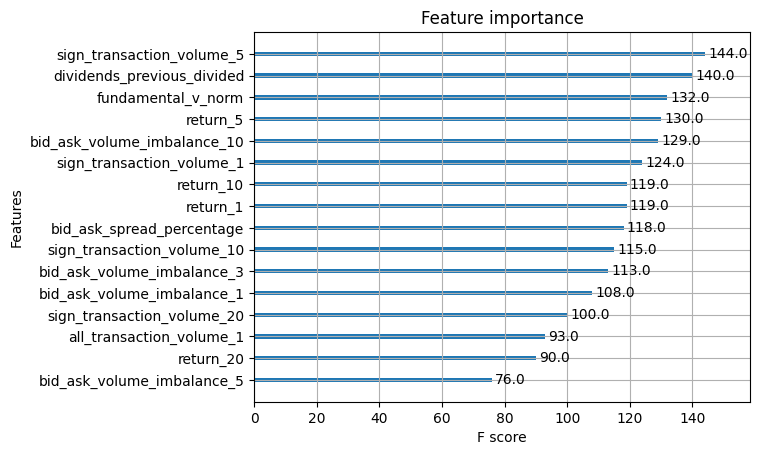

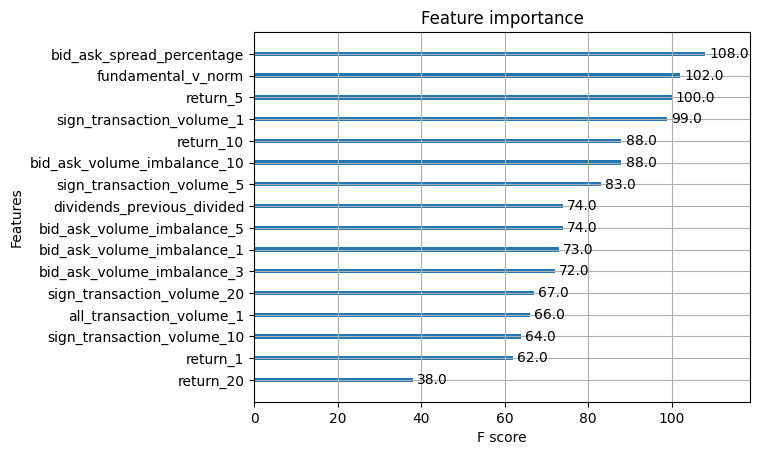

In [286]:
xgb.plot_importance(limited_models_10[0])
xgb.plot_importance(limited_models_10[3])

In [287]:
for model in limited_models_5:
    print(model == limited_models_5[0])

True
False
False
False


In [288]:
limited_results_5 = []

for model in limited_models_5:
    
    limited_test_results_5 = []

    random_seed = 2199

    for i in range(100):
        print(f'{i}/20')

        random_seed += 1

        history_5, agent_5 = simulate_agent_pnl(model=model, timing=5, n_iter=200, random_seed=random_seed)
        
        limited_test_results_5.append(agent_5)
        
    limited_results_5.append(limited_test_results_5)

0/20


100%|██████████| 200/200 [00:18<00:00, 11.00it/s]


1/20


100%|██████████| 200/200 [00:17<00:00, 11.65it/s]


2/20


100%|██████████| 200/200 [00:17<00:00, 11.30it/s]


3/20


100%|██████████| 200/200 [00:17<00:00, 11.34it/s]


4/20


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]


5/20


100%|██████████| 200/200 [00:18<00:00, 10.86it/s]


6/20


100%|██████████| 200/200 [00:16<00:00, 11.98it/s]


7/20


100%|██████████| 200/200 [00:18<00:00, 10.83it/s]


8/20


100%|██████████| 200/200 [00:18<00:00, 10.82it/s]


9/20


100%|██████████| 200/200 [00:18<00:00, 10.64it/s]


10/20


100%|██████████| 200/200 [00:20<00:00,  9.85it/s]


11/20


100%|██████████| 200/200 [00:17<00:00, 11.75it/s]


12/20


100%|██████████| 200/200 [00:18<00:00, 10.96it/s]


13/20


100%|██████████| 200/200 [00:16<00:00, 11.93it/s]


14/20


100%|██████████| 200/200 [00:27<00:00,  7.18it/s]


15/20


100%|██████████| 200/200 [00:18<00:00, 10.95it/s]


16/20


100%|██████████| 200/200 [00:17<00:00, 11.19it/s]


17/20


100%|██████████| 200/200 [00:18<00:00, 11.04it/s]


18/20


100%|██████████| 200/200 [00:18<00:00, 10.97it/s]


19/20


100%|██████████| 200/200 [00:20<00:00,  9.75it/s]


20/20


100%|██████████| 200/200 [00:21<00:00,  9.11it/s]


21/20


100%|██████████| 200/200 [00:17<00:00, 11.36it/s]


22/20


100%|██████████| 200/200 [00:19<00:00, 10.04it/s]


23/20


100%|██████████| 200/200 [00:16<00:00, 11.79it/s]


24/20


100%|██████████| 200/200 [00:16<00:00, 11.77it/s]


25/20


100%|██████████| 200/200 [00:17<00:00, 11.34it/s]


26/20


100%|██████████| 200/200 [00:18<00:00, 10.86it/s]


27/20


100%|██████████| 200/200 [00:17<00:00, 11.30it/s]


28/20


100%|██████████| 200/200 [00:18<00:00, 11.01it/s]


29/20


100%|██████████| 200/200 [00:16<00:00, 12.19it/s]


30/20


100%|██████████| 200/200 [00:17<00:00, 11.13it/s]


31/20


100%|██████████| 200/200 [00:18<00:00, 11.09it/s]


32/20


100%|██████████| 200/200 [00:16<00:00, 11.99it/s]


33/20


100%|██████████| 200/200 [00:17<00:00, 11.56it/s]


34/20


100%|██████████| 200/200 [00:16<00:00, 12.05it/s]


35/20


100%|██████████| 200/200 [00:18<00:00, 10.76it/s]


36/20


100%|██████████| 200/200 [00:18<00:00, 10.75it/s]


37/20


100%|██████████| 200/200 [00:17<00:00, 11.13it/s]


38/20


100%|██████████| 200/200 [00:17<00:00, 11.62it/s]


39/20


100%|██████████| 200/200 [00:17<00:00, 11.25it/s]


40/20


100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


41/20


100%|██████████| 200/200 [00:18<00:00, 10.92it/s]


42/20


100%|██████████| 200/200 [00:18<00:00, 10.82it/s]


43/20


100%|██████████| 200/200 [00:19<00:00, 10.48it/s]


44/20


100%|██████████| 200/200 [00:19<00:00, 10.44it/s]


45/20


100%|██████████| 200/200 [00:18<00:00, 10.97it/s]


46/20


100%|██████████| 200/200 [00:17<00:00, 11.62it/s]


47/20


100%|██████████| 200/200 [00:16<00:00, 11.85it/s]


48/20


100%|██████████| 200/200 [00:18<00:00, 10.66it/s]


49/20


100%|██████████| 200/200 [00:18<00:00, 10.90it/s]


50/20


100%|██████████| 200/200 [00:18<00:00, 10.76it/s]


51/20


100%|██████████| 200/200 [00:18<00:00, 10.70it/s]


52/20


100%|██████████| 200/200 [00:19<00:00, 10.25it/s]


53/20


100%|██████████| 200/200 [00:18<00:00, 11.02it/s]


54/20


100%|██████████| 200/200 [00:18<00:00, 10.54it/s]


55/20


100%|██████████| 200/200 [00:19<00:00, 10.47it/s]


56/20


100%|██████████| 200/200 [00:17<00:00, 11.32it/s]


57/20


100%|██████████| 200/200 [00:17<00:00, 11.48it/s]


58/20


100%|██████████| 200/200 [00:17<00:00, 11.15it/s]


59/20


100%|██████████| 200/200 [00:17<00:00, 11.20it/s]


60/20


100%|██████████| 200/200 [00:17<00:00, 11.16it/s]


61/20


100%|██████████| 200/200 [00:18<00:00, 10.98it/s]


62/20


100%|██████████| 200/200 [00:18<00:00, 10.87it/s]


63/20


100%|██████████| 200/200 [00:18<00:00, 10.81it/s]


64/20


100%|██████████| 200/200 [00:18<00:00, 10.86it/s]


65/20


100%|██████████| 200/200 [00:19<00:00, 10.13it/s]


66/20


100%|██████████| 200/200 [00:16<00:00, 11.97it/s]


67/20


100%|██████████| 200/200 [00:17<00:00, 11.64it/s]


68/20


100%|██████████| 200/200 [00:16<00:00, 12.29it/s]


69/20


100%|██████████| 200/200 [00:17<00:00, 11.49it/s]


70/20


100%|██████████| 200/200 [00:17<00:00, 11.73it/s]


71/20


100%|██████████| 200/200 [00:16<00:00, 12.04it/s]


72/20


100%|██████████| 200/200 [00:18<00:00, 11.09it/s]


73/20


100%|██████████| 200/200 [00:16<00:00, 11.82it/s]


74/20


100%|██████████| 200/200 [00:18<00:00, 10.87it/s]


75/20


100%|██████████| 200/200 [00:19<00:00, 10.29it/s]


76/20


100%|██████████| 200/200 [00:18<00:00, 10.57it/s]


77/20


100%|██████████| 200/200 [00:18<00:00, 11.02it/s]


78/20


100%|██████████| 200/200 [00:17<00:00, 11.32it/s]


79/20


100%|██████████| 200/200 [00:19<00:00, 10.35it/s]


80/20


100%|██████████| 200/200 [00:16<00:00, 11.87it/s]


81/20


100%|██████████| 200/200 [00:16<00:00, 11.91it/s]


82/20


100%|██████████| 200/200 [00:16<00:00, 11.81it/s]


83/20


100%|██████████| 200/200 [00:16<00:00, 11.95it/s]


84/20


100%|██████████| 200/200 [00:19<00:00, 10.19it/s]


85/20


100%|██████████| 200/200 [00:19<00:00, 10.48it/s]


86/20


100%|██████████| 200/200 [00:16<00:00, 11.80it/s]


87/20


100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


88/20


100%|██████████| 200/200 [00:16<00:00, 12.00it/s]


89/20


100%|██████████| 200/200 [00:18<00:00, 10.57it/s]


90/20


100%|██████████| 200/200 [00:17<00:00, 11.59it/s]


91/20


100%|██████████| 200/200 [00:18<00:00, 10.85it/s]


92/20


100%|██████████| 200/200 [00:18<00:00, 10.80it/s]


93/20


100%|██████████| 200/200 [00:18<00:00, 11.06it/s]


94/20


100%|██████████| 200/200 [00:17<00:00, 11.48it/s]


95/20


100%|██████████| 200/200 [00:18<00:00, 10.63it/s]


96/20


100%|██████████| 200/200 [00:17<00:00, 11.14it/s]


97/20


100%|██████████| 200/200 [00:17<00:00, 11.27it/s]


98/20


100%|██████████| 200/200 [00:18<00:00, 10.60it/s]


99/20


100%|██████████| 200/200 [00:18<00:00, 11.08it/s]


0/20


100%|██████████| 200/200 [00:16<00:00, 12.26it/s]


1/20


100%|██████████| 200/200 [00:16<00:00, 12.13it/s]


2/20


100%|██████████| 200/200 [00:17<00:00, 11.13it/s]


3/20


100%|██████████| 200/200 [00:16<00:00, 11.93it/s]


4/20


100%|██████████| 200/200 [00:17<00:00, 11.62it/s]


5/20


100%|██████████| 200/200 [00:18<00:00, 10.70it/s]


6/20


100%|██████████| 200/200 [00:18<00:00, 11.00it/s]


7/20


100%|██████████| 200/200 [00:17<00:00, 11.14it/s]


8/20


100%|██████████| 200/200 [00:17<00:00, 11.34it/s]


9/20


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]


10/20


100%|██████████| 200/200 [00:20<00:00,  9.68it/s]


11/20


100%|██████████| 200/200 [00:16<00:00, 12.00it/s]


12/20


100%|██████████| 200/200 [00:17<00:00, 11.48it/s]


13/20


100%|██████████| 200/200 [00:17<00:00, 11.30it/s]


14/20


100%|██████████| 200/200 [00:17<00:00, 11.70it/s]


15/20


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


16/20


100%|██████████| 200/200 [00:17<00:00, 11.24it/s]


17/20


100%|██████████| 200/200 [00:18<00:00, 10.84it/s]


18/20


100%|██████████| 200/200 [00:18<00:00, 11.08it/s]


19/20


100%|██████████| 200/200 [00:18<00:00, 10.85it/s]


20/20


100%|██████████| 200/200 [00:17<00:00, 11.51it/s]


21/20


100%|██████████| 200/200 [00:16<00:00, 11.84it/s]


22/20


100%|██████████| 200/200 [00:18<00:00, 10.86it/s]


23/20


100%|██████████| 200/200 [00:16<00:00, 12.07it/s]


24/20


100%|██████████| 200/200 [00:17<00:00, 11.68it/s]


25/20


100%|██████████| 200/200 [00:20<00:00,  9.93it/s]


26/20


100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


27/20


100%|██████████| 200/200 [00:17<00:00, 11.58it/s]


28/20


100%|██████████| 200/200 [00:17<00:00, 11.52it/s]


29/20


100%|██████████| 200/200 [00:16<00:00, 12.14it/s]


30/20


100%|██████████| 200/200 [00:18<00:00, 11.10it/s]


31/20


100%|██████████| 200/200 [00:18<00:00, 11.05it/s]


32/20


100%|██████████| 200/200 [00:16<00:00, 11.92it/s]


33/20


100%|██████████| 200/200 [00:17<00:00, 11.55it/s]


34/20


100%|██████████| 200/200 [00:16<00:00, 11.92it/s]


35/20


100%|██████████| 200/200 [00:16<00:00, 12.22it/s]


36/20


100%|██████████| 200/200 [00:16<00:00, 11.81it/s]


37/20


100%|██████████| 200/200 [00:17<00:00, 11.60it/s]


38/20


100%|██████████| 200/200 [00:18<00:00, 10.77it/s]


39/20


100%|██████████| 200/200 [00:18<00:00, 11.02it/s]


40/20


100%|██████████| 200/200 [00:18<00:00, 10.92it/s]


41/20


100%|██████████| 200/200 [00:18<00:00, 10.81it/s]


42/20


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]


43/20


100%|██████████| 200/200 [00:17<00:00, 11.22it/s]


44/20


100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


45/20


100%|██████████| 200/200 [00:17<00:00, 11.27it/s]


46/20


100%|██████████| 200/200 [00:17<00:00, 11.63it/s]


47/20


100%|██████████| 200/200 [00:19<00:00, 10.26it/s]


48/20


100%|██████████| 200/200 [00:17<00:00, 11.33it/s]


49/20


100%|██████████| 200/200 [00:17<00:00, 11.38it/s]


50/20


100%|██████████| 200/200 [00:19<00:00, 10.08it/s]


51/20


100%|██████████| 200/200 [00:17<00:00, 11.17it/s]


52/20


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]


53/20


100%|██████████| 200/200 [00:18<00:00, 11.10it/s]


54/20


100%|██████████| 200/200 [00:17<00:00, 11.36it/s]


55/20


100%|██████████| 200/200 [00:17<00:00, 11.56it/s]


56/20


100%|██████████| 200/200 [00:17<00:00, 11.39it/s]


57/20


100%|██████████| 200/200 [00:15<00:00, 12.78it/s]


58/20


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


59/20


100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


60/20


100%|██████████| 200/200 [00:17<00:00, 11.71it/s]


61/20


100%|██████████| 200/200 [00:17<00:00, 11.19it/s]


62/20


100%|██████████| 200/200 [00:17<00:00, 11.26it/s]


63/20


100%|██████████| 200/200 [00:18<00:00, 11.05it/s]


64/20


100%|██████████| 200/200 [00:18<00:00, 10.55it/s]


65/20


100%|██████████| 200/200 [00:17<00:00, 11.35it/s]


66/20


100%|██████████| 200/200 [00:17<00:00, 11.49it/s]


67/20


100%|██████████| 200/200 [00:20<00:00,  9.76it/s]


68/20


100%|██████████| 200/200 [00:16<00:00, 12.23it/s]


69/20


100%|██████████| 200/200 [00:18<00:00, 11.01it/s]


70/20


100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


71/20


100%|██████████| 200/200 [00:17<00:00, 11.58it/s]


72/20


100%|██████████| 200/200 [00:16<00:00, 12.14it/s]


73/20


100%|██████████| 200/200 [00:17<00:00, 11.19it/s]


74/20


100%|██████████| 200/200 [00:19<00:00, 10.19it/s]


75/20


100%|██████████| 200/200 [00:18<00:00, 10.58it/s]


76/20


100%|██████████| 200/200 [00:17<00:00, 11.48it/s]


77/20


100%|██████████| 200/200 [00:17<00:00, 11.47it/s]


78/20


100%|██████████| 200/200 [00:19<00:00, 10.33it/s]


79/20


100%|██████████| 200/200 [00:18<00:00, 10.92it/s]


80/20


100%|██████████| 200/200 [00:17<00:00, 11.72it/s]


81/20


100%|██████████| 200/200 [00:16<00:00, 12.25it/s]


82/20


100%|██████████| 200/200 [00:16<00:00, 12.04it/s]


83/20


100%|██████████| 200/200 [00:18<00:00, 10.56it/s]


84/20


100%|██████████| 200/200 [00:18<00:00, 10.68it/s]


85/20


100%|██████████| 200/200 [00:16<00:00, 11.78it/s]


86/20


100%|██████████| 200/200 [00:16<00:00, 12.02it/s]


87/20


100%|██████████| 200/200 [00:17<00:00, 11.26it/s]


88/20


100%|██████████| 200/200 [00:17<00:00, 11.12it/s]


89/20


100%|██████████| 200/200 [00:17<00:00, 11.45it/s]


90/20


100%|██████████| 200/200 [00:16<00:00, 12.26it/s]


91/20


100%|██████████| 200/200 [00:20<00:00,  9.85it/s]


92/20


100%|██████████| 200/200 [00:17<00:00, 11.53it/s]


93/20


100%|██████████| 200/200 [00:16<00:00, 11.89it/s]


94/20


100%|██████████| 200/200 [00:18<00:00, 10.89it/s]


95/20


100%|██████████| 200/200 [00:17<00:00, 11.44it/s]


96/20


100%|██████████| 200/200 [00:16<00:00, 11.84it/s]


97/20


100%|██████████| 200/200 [00:17<00:00, 11.39it/s]


98/20


100%|██████████| 200/200 [00:16<00:00, 12.11it/s]


99/20


100%|██████████| 200/200 [00:18<00:00, 10.84it/s]


0/20


100%|██████████| 200/200 [00:17<00:00, 11.71it/s]


1/20


100%|██████████| 200/200 [00:17<00:00, 11.42it/s]


2/20


100%|██████████| 200/200 [00:17<00:00, 11.51it/s]


3/20


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


4/20


100%|██████████| 200/200 [00:17<00:00, 11.72it/s]


5/20


100%|██████████| 200/200 [00:17<00:00, 11.62it/s]


6/20


100%|██████████| 200/200 [00:16<00:00, 12.23it/s]


7/20


100%|██████████| 200/200 [00:18<00:00, 11.10it/s]


8/20


100%|██████████| 200/200 [00:16<00:00, 12.27it/s]


9/20


100%|██████████| 200/200 [00:16<00:00, 12.27it/s]


10/20


100%|██████████| 200/200 [00:17<00:00, 11.58it/s]


11/20


100%|██████████| 200/200 [00:16<00:00, 11.90it/s]


12/20


100%|██████████| 200/200 [00:17<00:00, 11.50it/s]


13/20


100%|██████████| 200/200 [00:17<00:00, 11.37it/s]


14/20


100%|██████████| 200/200 [00:18<00:00, 10.61it/s]


15/20


100%|██████████| 200/200 [00:16<00:00, 12.40it/s]


16/20


100%|██████████| 200/200 [00:17<00:00, 11.49it/s]


17/20


100%|██████████| 200/200 [00:17<00:00, 11.67it/s]


18/20


100%|██████████| 200/200 [00:18<00:00, 10.72it/s]


19/20


100%|██████████| 200/200 [00:17<00:00, 11.26it/s]


20/20


100%|██████████| 200/200 [00:17<00:00, 11.43it/s]


21/20


100%|██████████| 200/200 [00:17<00:00, 11.58it/s]


22/20


100%|██████████| 200/200 [00:17<00:00, 11.30it/s]


23/20


100%|██████████| 200/200 [00:17<00:00, 11.14it/s]


24/20


100%|██████████| 200/200 [00:16<00:00, 11.90it/s]


25/20


100%|██████████| 200/200 [00:17<00:00, 11.36it/s]


26/20


100%|██████████| 200/200 [00:17<00:00, 11.24it/s]


27/20


100%|██████████| 200/200 [00:17<00:00, 11.17it/s]


28/20


100%|██████████| 200/200 [00:17<00:00, 11.46it/s]


29/20


100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


30/20


100%|██████████| 200/200 [00:16<00:00, 11.97it/s]


31/20


100%|██████████| 200/200 [00:16<00:00, 12.01it/s]


32/20


100%|██████████| 200/200 [00:16<00:00, 11.81it/s]


33/20


100%|██████████| 200/200 [00:17<00:00, 11.70it/s]


34/20


100%|██████████| 200/200 [00:17<00:00, 11.63it/s]


35/20


100%|██████████| 200/200 [00:17<00:00, 11.72it/s]


36/20


100%|██████████| 200/200 [00:17<00:00, 11.33it/s]


37/20


100%|██████████| 200/200 [00:16<00:00, 11.84it/s]


38/20


100%|██████████| 200/200 [00:16<00:00, 11.86it/s]


39/20


100%|██████████| 200/200 [00:19<00:00, 10.27it/s]


40/20


100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


41/20


100%|██████████| 200/200 [00:17<00:00, 11.47it/s]


42/20


100%|██████████| 200/200 [00:17<00:00, 11.68it/s]


43/20


100%|██████████| 200/200 [00:17<00:00, 11.57it/s]


44/20


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


45/20


100%|██████████| 200/200 [00:18<00:00, 10.85it/s]


46/20


100%|██████████| 200/200 [00:17<00:00, 11.13it/s]


47/20


100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


48/20


100%|██████████| 200/200 [00:16<00:00, 11.80it/s]


49/20


100%|██████████| 200/200 [00:16<00:00, 12.40it/s]


50/20


100%|██████████| 200/200 [00:17<00:00, 11.72it/s]


51/20


100%|██████████| 200/200 [00:18<00:00, 10.83it/s]


52/20


100%|██████████| 200/200 [00:18<00:00, 10.71it/s]


53/20


100%|██████████| 200/200 [00:16<00:00, 12.04it/s]


54/20


100%|██████████| 200/200 [00:17<00:00, 11.66it/s]


55/20


100%|██████████| 200/200 [00:18<00:00, 10.93it/s]


56/20


100%|██████████| 200/200 [00:17<00:00, 11.33it/s]


57/20


100%|██████████| 200/200 [00:17<00:00, 11.15it/s]


58/20


100%|██████████| 200/200 [00:16<00:00, 11.81it/s]


59/20


100%|██████████| 200/200 [00:17<00:00, 11.19it/s]


60/20


100%|██████████| 200/200 [00:17<00:00, 11.12it/s]


61/20


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


62/20


100%|██████████| 200/200 [00:17<00:00, 11.62it/s]


63/20


100%|██████████| 200/200 [00:17<00:00, 11.29it/s]


64/20


100%|██████████| 200/200 [00:17<00:00, 11.47it/s]


65/20


100%|██████████| 200/200 [00:18<00:00, 10.57it/s]


66/20


100%|██████████| 200/200 [00:18<00:00, 11.03it/s]


67/20


100%|██████████| 200/200 [00:18<00:00, 10.98it/s]


68/20


100%|██████████| 200/200 [00:16<00:00, 12.29it/s]


69/20


100%|██████████| 200/200 [00:16<00:00, 11.93it/s]


70/20


100%|██████████| 200/200 [00:16<00:00, 12.00it/s]


71/20


100%|██████████| 200/200 [00:16<00:00, 12.25it/s]


72/20


100%|██████████| 200/200 [00:16<00:00, 11.80it/s]


73/20


100%|██████████| 200/200 [00:18<00:00, 10.93it/s]


74/20


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


75/20


100%|██████████| 200/200 [00:16<00:00, 12.41it/s]


76/20


100%|██████████| 200/200 [00:16<00:00, 11.87it/s]


77/20


100%|██████████| 200/200 [00:18<00:00, 10.65it/s]


78/20


100%|██████████| 200/200 [00:17<00:00, 11.57it/s]


79/20


100%|██████████| 200/200 [00:17<00:00, 11.33it/s]


80/20


100%|██████████| 200/200 [00:17<00:00, 11.25it/s]


81/20


100%|██████████| 200/200 [00:17<00:00, 11.49it/s]


82/20


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


83/20


100%|██████████| 200/200 [00:16<00:00, 12.32it/s]


84/20


100%|██████████| 200/200 [00:17<00:00, 11.44it/s]


85/20


100%|██████████| 200/200 [00:16<00:00, 12.01it/s]


86/20


100%|██████████| 200/200 [00:17<00:00, 11.63it/s]


87/20


100%|██████████| 200/200 [00:16<00:00, 12.17it/s]


88/20


100%|██████████| 200/200 [00:15<00:00, 12.57it/s]


89/20


100%|██████████| 200/200 [00:16<00:00, 12.16it/s]


90/20


100%|██████████| 200/200 [00:16<00:00, 12.10it/s]


91/20


100%|██████████| 200/200 [00:18<00:00, 10.81it/s]


92/20


100%|██████████| 200/200 [00:20<00:00,  9.98it/s]


93/20


100%|██████████| 200/200 [00:17<00:00, 11.25it/s]


94/20


100%|██████████| 200/200 [00:18<00:00, 10.93it/s]


95/20


100%|██████████| 200/200 [00:17<00:00, 11.39it/s]


96/20


100%|██████████| 200/200 [00:16<00:00, 12.14it/s]


97/20


100%|██████████| 200/200 [00:16<00:00, 12.25it/s]


98/20


100%|██████████| 200/200 [00:16<00:00, 12.27it/s]


99/20


100%|██████████| 200/200 [00:17<00:00, 11.35it/s]


0/20


100%|██████████| 200/200 [00:16<00:00, 12.45it/s]


1/20


100%|██████████| 200/200 [00:16<00:00, 11.90it/s]


2/20


100%|██████████| 200/200 [00:18<00:00, 10.66it/s]


3/20


100%|██████████| 200/200 [00:18<00:00, 11.09it/s]


4/20


100%|██████████| 200/200 [00:17<00:00, 11.28it/s]


5/20


100%|██████████| 200/200 [00:17<00:00, 11.73it/s]


6/20


100%|██████████| 200/200 [00:17<00:00, 11.55it/s]


7/20


100%|██████████| 200/200 [00:16<00:00, 12.08it/s]


8/20


100%|██████████| 200/200 [00:16<00:00, 11.81it/s]


9/20


100%|██████████| 200/200 [00:20<00:00,  9.94it/s]


10/20


100%|██████████| 200/200 [00:18<00:00, 10.58it/s]


11/20


100%|██████████| 200/200 [00:18<00:00, 11.08it/s]


12/20


100%|██████████| 200/200 [00:18<00:00, 11.01it/s]


13/20


100%|██████████| 200/200 [00:16<00:00, 12.06it/s]


14/20


100%|██████████| 200/200 [00:17<00:00, 11.52it/s]


15/20


100%|██████████| 200/200 [00:17<00:00, 11.23it/s]


16/20


100%|██████████| 200/200 [00:18<00:00, 10.56it/s]


17/20


100%|██████████| 200/200 [00:16<00:00, 11.92it/s]


18/20


100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


19/20


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


20/20


100%|██████████| 200/200 [00:19<00:00, 10.07it/s]


21/20


100%|██████████| 200/200 [00:18<00:00, 10.93it/s]


22/20


100%|██████████| 200/200 [00:18<00:00, 10.91it/s]


23/20


100%|██████████| 200/200 [00:18<00:00, 11.04it/s]


24/20


100%|██████████| 200/200 [00:16<00:00, 11.89it/s]


25/20


100%|██████████| 200/200 [00:16<00:00, 12.32it/s]


26/20


100%|██████████| 200/200 [00:17<00:00, 11.67it/s]


27/20


100%|██████████| 200/200 [00:18<00:00, 11.02it/s]


28/20


100%|██████████| 200/200 [00:17<00:00, 11.20it/s]


29/20


100%|██████████| 200/200 [00:18<00:00, 10.91it/s]


30/20


100%|██████████| 200/200 [00:18<00:00, 11.03it/s]


31/20


100%|██████████| 200/200 [00:17<00:00, 11.31it/s]


32/20


100%|██████████| 200/200 [00:18<00:00, 11.10it/s]


33/20


100%|██████████| 200/200 [00:17<00:00, 11.30it/s]


34/20


100%|██████████| 200/200 [00:16<00:00, 12.36it/s]


35/20


100%|██████████| 200/200 [00:17<00:00, 11.42it/s]


36/20


100%|██████████| 200/200 [00:17<00:00, 11.17it/s]


37/20


100%|██████████| 200/200 [00:17<00:00, 11.18it/s]


38/20


100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


39/20


100%|██████████| 200/200 [00:18<00:00, 10.94it/s]


40/20


100%|██████████| 200/200 [00:18<00:00, 11.02it/s]


41/20


100%|██████████| 200/200 [00:17<00:00, 11.45it/s]


42/20


100%|██████████| 200/200 [00:18<00:00, 10.53it/s]


43/20


100%|██████████| 200/200 [00:18<00:00, 11.06it/s]


44/20


100%|██████████| 200/200 [00:17<00:00, 11.34it/s]


45/20


100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


46/20


100%|██████████| 200/200 [00:17<00:00, 11.47it/s]


47/20


100%|██████████| 200/200 [00:18<00:00, 10.70it/s]


48/20


100%|██████████| 200/200 [00:17<00:00, 11.61it/s]


49/20


100%|██████████| 200/200 [00:20<00:00,  9.95it/s]


50/20


100%|██████████| 200/200 [00:17<00:00, 11.13it/s]


51/20


100%|██████████| 200/200 [00:17<00:00, 11.36it/s]


52/20


100%|██████████| 200/200 [00:18<00:00, 10.87it/s]


53/20


100%|██████████| 200/200 [00:18<00:00, 10.79it/s]


54/20


100%|██████████| 200/200 [00:17<00:00, 11.68it/s]


55/20


100%|██████████| 200/200 [00:18<00:00, 10.87it/s]


56/20


100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


57/20


100%|██████████| 200/200 [00:17<00:00, 11.37it/s]


58/20


100%|██████████| 200/200 [00:18<00:00, 10.92it/s]


59/20


100%|██████████| 200/200 [00:17<00:00, 11.16it/s]


60/20


100%|██████████| 200/200 [00:17<00:00, 11.30it/s]


61/20


100%|██████████| 200/200 [00:18<00:00, 10.99it/s]


62/20


100%|██████████| 200/200 [00:18<00:00, 10.59it/s]


63/20


100%|██████████| 200/200 [00:17<00:00, 11.43it/s]


64/20


100%|██████████| 200/200 [00:17<00:00, 11.21it/s]


65/20


100%|██████████| 200/200 [00:17<00:00, 11.30it/s]


66/20


100%|██████████| 200/200 [00:18<00:00, 10.99it/s]


67/20


100%|██████████| 200/200 [00:17<00:00, 11.27it/s]


68/20


100%|██████████| 200/200 [00:17<00:00, 11.62it/s]


69/20


100%|██████████| 200/200 [00:17<00:00, 11.46it/s]


70/20


100%|██████████| 200/200 [00:17<00:00, 11.75it/s]


71/20


100%|██████████| 200/200 [00:17<00:00, 11.68it/s]


72/20


100%|██████████| 200/200 [00:17<00:00, 11.55it/s]


73/20


100%|██████████| 200/200 [00:19<00:00, 10.47it/s]


74/20


100%|██████████| 200/200 [00:17<00:00, 11.28it/s]


75/20


100%|██████████| 200/200 [00:18<00:00, 10.82it/s]


76/20


100%|██████████| 200/200 [00:17<00:00, 11.12it/s]


77/20


100%|██████████| 200/200 [00:18<00:00, 10.91it/s]


78/20


100%|██████████| 200/200 [00:18<00:00, 10.77it/s]


79/20


100%|██████████| 200/200 [00:21<00:00,  9.28it/s]


80/20


100%|██████████| 200/200 [00:17<00:00, 11.24it/s]


81/20


100%|██████████| 200/200 [00:18<00:00, 10.95it/s]


82/20


100%|██████████| 200/200 [00:17<00:00, 11.36it/s]


83/20


100%|██████████| 200/200 [00:17<00:00, 11.52it/s]


84/20


100%|██████████| 200/200 [00:16<00:00, 11.78it/s]


85/20


100%|██████████| 200/200 [00:17<00:00, 11.12it/s]


86/20


100%|██████████| 200/200 [00:17<00:00, 11.48it/s]


87/20


100%|██████████| 200/200 [00:16<00:00, 12.28it/s]


88/20


100%|██████████| 200/200 [00:17<00:00, 11.19it/s]


89/20


100%|██████████| 200/200 [00:18<00:00, 10.93it/s]


90/20


100%|██████████| 200/200 [00:17<00:00, 11.68it/s]


91/20


100%|██████████| 200/200 [00:18<00:00, 11.09it/s]


92/20


100%|██████████| 200/200 [00:18<00:00, 10.99it/s]


93/20


100%|██████████| 200/200 [00:17<00:00, 11.60it/s]


94/20


100%|██████████| 200/200 [00:17<00:00, 11.34it/s]


95/20


100%|██████████| 200/200 [00:19<00:00, 10.49it/s]


96/20


100%|██████████| 200/200 [00:18<00:00, 10.99it/s]


97/20


100%|██████████| 200/200 [00:16<00:00, 12.44it/s]


98/20


100%|██████████| 200/200 [00:17<00:00, 11.61it/s]


99/20


100%|██████████| 200/200 [00:17<00:00, 11.42it/s]


In [289]:
limited_results_10 = []

for model in limited_models_10:
    
    limited_test_results_10 = []

    random_seed = 2199

    for i in range(100):
        print(f'{i}/20')
        random_seed += 1

        history_10, agent_10 = simulate_agent_pnl(model=model, timing=10, n_iter=200, random_seed=random_seed)
        
        limited_test_results_10.append(agent_10)
    
    limited_results_10.append(limited_test_results_10)

0/20


100%|██████████| 200/200 [00:14<00:00, 14.07it/s]


1/20


100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


2/20


100%|██████████| 200/200 [00:16<00:00, 12.49it/s]


3/20


100%|██████████| 200/200 [00:14<00:00, 13.80it/s]


4/20


100%|██████████| 200/200 [00:14<00:00, 13.65it/s]


5/20


100%|██████████| 200/200 [00:14<00:00, 13.56it/s]


6/20


100%|██████████| 200/200 [00:14<00:00, 14.10it/s]


7/20


100%|██████████| 200/200 [00:14<00:00, 13.37it/s]


8/20


100%|██████████| 200/200 [00:15<00:00, 12.85it/s]


9/20


100%|██████████| 200/200 [00:15<00:00, 12.93it/s]


10/20


100%|██████████| 200/200 [00:16<00:00, 11.94it/s]


11/20


100%|██████████| 200/200 [00:17<00:00, 11.16it/s]


12/20


100%|██████████| 200/200 [00:15<00:00, 13.10it/s]


13/20


100%|██████████| 200/200 [00:15<00:00, 13.24it/s]


14/20


100%|██████████| 200/200 [00:14<00:00, 13.95it/s]


15/20


100%|██████████| 200/200 [00:17<00:00, 11.73it/s]


16/20


100%|██████████| 200/200 [00:14<00:00, 14.00it/s]


17/20


100%|██████████| 200/200 [00:14<00:00, 13.78it/s]


18/20


100%|██████████| 200/200 [00:14<00:00, 13.49it/s]


19/20


100%|██████████| 200/200 [00:15<00:00, 13.07it/s]


20/20


100%|██████████| 200/200 [00:16<00:00, 12.29it/s]


21/20


100%|██████████| 200/200 [00:15<00:00, 13.15it/s]


22/20


100%|██████████| 200/200 [00:16<00:00, 12.10it/s]


23/20


100%|██████████| 200/200 [00:14<00:00, 13.84it/s]


24/20


100%|██████████| 200/200 [00:14<00:00, 13.77it/s]


25/20


100%|██████████| 200/200 [00:15<00:00, 12.99it/s]


26/20


100%|██████████| 200/200 [00:15<00:00, 13.24it/s]


27/20


100%|██████████| 200/200 [00:15<00:00, 12.60it/s]


28/20


100%|██████████| 200/200 [00:15<00:00, 13.24it/s]


29/20


100%|██████████| 200/200 [00:15<00:00, 13.22it/s]


30/20


100%|██████████| 200/200 [00:15<00:00, 13.19it/s]


31/20


100%|██████████| 200/200 [00:15<00:00, 12.85it/s]


32/20


100%|██████████| 200/200 [00:14<00:00, 14.07it/s]


33/20


100%|██████████| 200/200 [00:14<00:00, 13.73it/s]


34/20


100%|██████████| 200/200 [00:14<00:00, 13.64it/s]


35/20


100%|██████████| 200/200 [00:15<00:00, 13.15it/s]


36/20


100%|██████████| 200/200 [00:14<00:00, 13.81it/s]


37/20


100%|██████████| 200/200 [00:14<00:00, 14.00it/s]


38/20


100%|██████████| 200/200 [00:15<00:00, 13.25it/s]


39/20


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


40/20


100%|██████████| 200/200 [00:17<00:00, 11.22it/s]


41/20


100%|██████████| 200/200 [00:14<00:00, 13.94it/s]


42/20


100%|██████████| 200/200 [00:15<00:00, 13.22it/s]


43/20


100%|██████████| 200/200 [00:16<00:00, 12.48it/s]


44/20


100%|██████████| 200/200 [00:15<00:00, 13.21it/s]


45/20


100%|██████████| 200/200 [00:15<00:00, 13.16it/s]


46/20


100%|██████████| 200/200 [00:15<00:00, 13.15it/s]


47/20


100%|██████████| 200/200 [00:14<00:00, 13.76it/s]


48/20


100%|██████████| 200/200 [00:14<00:00, 13.85it/s]


49/20


100%|██████████| 200/200 [00:16<00:00, 11.96it/s]


50/20


100%|██████████| 200/200 [00:14<00:00, 13.84it/s]


51/20


100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


52/20


100%|██████████| 200/200 [00:15<00:00, 12.66it/s]


53/20


100%|██████████| 200/200 [00:14<00:00, 13.94it/s]


54/20


100%|██████████| 200/200 [00:14<00:00, 13.51it/s]


55/20


100%|██████████| 200/200 [00:13<00:00, 14.37it/s]


56/20


100%|██████████| 200/200 [00:14<00:00, 13.71it/s]


57/20


100%|██████████| 200/200 [00:14<00:00, 13.64it/s]


58/20


100%|██████████| 200/200 [00:14<00:00, 13.73it/s]


59/20


100%|██████████| 200/200 [00:15<00:00, 12.61it/s]


60/20


100%|██████████| 200/200 [00:15<00:00, 13.09it/s]


61/20


100%|██████████| 200/200 [00:15<00:00, 13.11it/s]


62/20


100%|██████████| 200/200 [00:16<00:00, 12.35it/s]


63/20


100%|██████████| 200/200 [00:16<00:00, 11.92it/s]


64/20


100%|██████████| 200/200 [00:14<00:00, 13.38it/s]


65/20


100%|██████████| 200/200 [00:15<00:00, 12.87it/s]


66/20


100%|██████████| 200/200 [00:14<00:00, 13.85it/s]


67/20


100%|██████████| 200/200 [00:15<00:00, 13.19it/s]


68/20


100%|██████████| 200/200 [00:15<00:00, 12.89it/s]


69/20


100%|██████████| 200/200 [00:15<00:00, 13.05it/s]


70/20


100%|██████████| 200/200 [00:17<00:00, 11.17it/s]


71/20


100%|██████████| 200/200 [00:15<00:00, 13.13it/s]


72/20


100%|██████████| 200/200 [00:14<00:00, 13.70it/s]


73/20


100%|██████████| 200/200 [00:15<00:00, 12.65it/s]


74/20


100%|██████████| 200/200 [00:14<00:00, 13.61it/s]


75/20


100%|██████████| 200/200 [00:15<00:00, 12.51it/s]


76/20


100%|██████████| 200/200 [00:17<00:00, 11.62it/s]


77/20


100%|██████████| 200/200 [00:14<00:00, 13.45it/s]


78/20


100%|██████████| 200/200 [00:15<00:00, 12.72it/s]


79/20


100%|██████████| 200/200 [00:15<00:00, 12.76it/s]


80/20


100%|██████████| 200/200 [00:14<00:00, 14.03it/s]


81/20


100%|██████████| 200/200 [00:15<00:00, 12.56it/s]


82/20


100%|██████████| 200/200 [00:17<00:00, 11.70it/s]


83/20


100%|██████████| 200/200 [00:13<00:00, 14.60it/s]


84/20


100%|██████████| 200/200 [00:15<00:00, 13.08it/s]


85/20


100%|██████████| 200/200 [00:14<00:00, 13.67it/s]


86/20


100%|██████████| 200/200 [00:14<00:00, 13.78it/s]


87/20


100%|██████████| 200/200 [00:16<00:00, 12.20it/s]


88/20


100%|██████████| 200/200 [00:14<00:00, 13.99it/s]


89/20


100%|██████████| 200/200 [00:14<00:00, 13.89it/s]


90/20


100%|██████████| 200/200 [00:13<00:00, 14.36it/s]


91/20


100%|██████████| 200/200 [00:15<00:00, 12.89it/s]


92/20


100%|██████████| 200/200 [00:15<00:00, 12.99it/s]


93/20


100%|██████████| 200/200 [00:14<00:00, 14.01it/s]


94/20


100%|██████████| 200/200 [00:14<00:00, 13.61it/s]


95/20


100%|██████████| 200/200 [00:15<00:00, 12.97it/s]


96/20


100%|██████████| 200/200 [00:14<00:00, 13.52it/s]


97/20


100%|██████████| 200/200 [00:16<00:00, 12.19it/s]


98/20


100%|██████████| 200/200 [00:14<00:00, 13.60it/s]


99/20


100%|██████████| 200/200 [00:15<00:00, 13.07it/s]


0/20


100%|██████████| 200/200 [00:13<00:00, 14.43it/s]


1/20


100%|██████████| 200/200 [00:14<00:00, 13.75it/s]


2/20


100%|██████████| 200/200 [00:17<00:00, 11.15it/s]


3/20


100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


4/20


100%|██████████| 200/200 [00:14<00:00, 13.90it/s]


5/20


100%|██████████| 200/200 [00:16<00:00, 12.44it/s]


6/20


100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


7/20


100%|██████████| 200/200 [00:15<00:00, 12.87it/s]


8/20


100%|██████████| 200/200 [00:15<00:00, 13.33it/s]


9/20


100%|██████████| 200/200 [00:16<00:00, 11.89it/s]


10/20


100%|██████████| 200/200 [00:15<00:00, 12.56it/s]


11/20


100%|██████████| 200/200 [00:15<00:00, 13.17it/s]


12/20


100%|██████████| 200/200 [00:15<00:00, 12.91it/s]


13/20


100%|██████████| 200/200 [00:15<00:00, 13.08it/s]


14/20


100%|██████████| 200/200 [00:14<00:00, 13.36it/s]


15/20


100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


16/20


100%|██████████| 200/200 [00:15<00:00, 13.27it/s]


17/20


100%|██████████| 200/200 [00:16<00:00, 12.30it/s]


18/20


100%|██████████| 200/200 [00:14<00:00, 13.34it/s]


19/20


100%|██████████| 200/200 [00:15<00:00, 12.50it/s]


20/20


100%|██████████| 200/200 [00:14<00:00, 13.51it/s]


21/20


100%|██████████| 200/200 [00:15<00:00, 13.22it/s]


22/20


100%|██████████| 200/200 [00:15<00:00, 13.06it/s]


23/20


100%|██████████| 200/200 [00:15<00:00, 13.32it/s]


24/20


100%|██████████| 200/200 [00:14<00:00, 13.33it/s]


25/20


100%|██████████| 200/200 [00:15<00:00, 13.17it/s]


26/20


100%|██████████| 200/200 [00:14<00:00, 13.80it/s]


27/20


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


28/20


100%|██████████| 200/200 [00:15<00:00, 12.84it/s]


29/20


100%|██████████| 200/200 [00:15<00:00, 12.58it/s]


30/20


100%|██████████| 200/200 [00:16<00:00, 12.09it/s]


31/20


100%|██████████| 200/200 [00:15<00:00, 13.26it/s]


32/20


100%|██████████| 200/200 [00:14<00:00, 13.84it/s]


33/20


100%|██████████| 200/200 [00:16<00:00, 12.37it/s]


34/20


100%|██████████| 200/200 [00:15<00:00, 13.31it/s]


35/20


100%|██████████| 200/200 [00:18<00:00, 10.72it/s]


36/20


100%|██████████| 200/200 [00:15<00:00, 13.23it/s]


37/20


100%|██████████| 200/200 [00:14<00:00, 13.50it/s]


38/20


100%|██████████| 200/200 [00:14<00:00, 14.10it/s]


39/20


100%|██████████| 200/200 [00:14<00:00, 13.65it/s]


40/20


100%|██████████| 200/200 [00:15<00:00, 12.69it/s]


41/20


100%|██████████| 200/200 [00:14<00:00, 13.97it/s]


42/20


100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


43/20


100%|██████████| 200/200 [00:15<00:00, 12.92it/s]


44/20


100%|██████████| 200/200 [00:16<00:00, 11.89it/s]


45/20


100%|██████████| 200/200 [00:16<00:00, 12.14it/s]


46/20


100%|██████████| 200/200 [00:14<00:00, 13.89it/s]


47/20


100%|██████████| 200/200 [00:15<00:00, 12.86it/s]


48/20


100%|██████████| 200/200 [00:17<00:00, 11.63it/s]


49/20


100%|██████████| 200/200 [00:15<00:00, 13.12it/s]


50/20


100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


51/20


100%|██████████| 200/200 [00:15<00:00, 12.83it/s]


52/20


100%|██████████| 200/200 [00:15<00:00, 12.91it/s]


53/20


100%|██████████| 200/200 [00:15<00:00, 13.26it/s]


54/20


100%|██████████| 200/200 [00:14<00:00, 13.69it/s]


55/20


100%|██████████| 200/200 [00:14<00:00, 13.73it/s]


56/20


100%|██████████| 200/200 [00:16<00:00, 12.33it/s]


57/20


100%|██████████| 200/200 [00:14<00:00, 13.88it/s]


58/20


100%|██████████| 200/200 [00:14<00:00, 13.49it/s]


59/20


100%|██████████| 200/200 [00:15<00:00, 12.80it/s]


60/20


100%|██████████| 200/200 [00:15<00:00, 12.59it/s]


61/20


100%|██████████| 200/200 [00:15<00:00, 12.67it/s]


62/20


100%|██████████| 200/200 [00:15<00:00, 13.27it/s]


63/20


100%|██████████| 200/200 [00:15<00:00, 12.64it/s]


64/20


100%|██████████| 200/200 [00:16<00:00, 12.48it/s]


65/20


100%|██████████| 200/200 [00:16<00:00, 11.99it/s]


66/20


100%|██████████| 200/200 [00:15<00:00, 13.31it/s]


67/20


100%|██████████| 200/200 [00:17<00:00, 11.54it/s]


68/20


100%|██████████| 200/200 [00:15<00:00, 12.96it/s]


69/20


100%|██████████| 200/200 [00:17<00:00, 11.26it/s]


70/20


100%|██████████| 200/200 [00:15<00:00, 13.28it/s]


71/20


100%|██████████| 200/200 [00:15<00:00, 13.31it/s]


72/20


100%|██████████| 200/200 [00:14<00:00, 13.82it/s]


73/20


100%|██████████| 200/200 [00:14<00:00, 13.37it/s]


74/20


100%|██████████| 200/200 [00:14<00:00, 13.40it/s]


75/20


100%|██████████| 200/200 [00:16<00:00, 11.84it/s]


76/20


100%|██████████| 200/200 [00:15<00:00, 12.53it/s]


77/20


100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


78/20


100%|██████████| 200/200 [00:15<00:00, 12.80it/s]


79/20


100%|██████████| 200/200 [00:16<00:00, 12.38it/s]


80/20


100%|██████████| 200/200 [00:16<00:00, 12.43it/s]


81/20


100%|██████████| 200/200 [00:15<00:00, 13.30it/s]


82/20


100%|██████████| 200/200 [00:15<00:00, 13.23it/s]


83/20


100%|██████████| 200/200 [00:15<00:00, 13.13it/s]


84/20


100%|██████████| 200/200 [00:14<00:00, 13.49it/s]


85/20


100%|██████████| 200/200 [00:15<00:00, 12.78it/s]


86/20


100%|██████████| 200/200 [00:14<00:00, 13.56it/s]


87/20


100%|██████████| 200/200 [00:15<00:00, 13.27it/s]


88/20


100%|██████████| 200/200 [00:14<00:00, 14.21it/s]


89/20


100%|██████████| 200/200 [00:15<00:00, 13.28it/s]


90/20


100%|██████████| 200/200 [00:15<00:00, 13.10it/s]


91/20


100%|██████████| 200/200 [00:15<00:00, 12.84it/s]


92/20


100%|██████████| 200/200 [00:15<00:00, 13.14it/s]


93/20


100%|██████████| 200/200 [00:15<00:00, 13.18it/s]


94/20


100%|██████████| 200/200 [00:14<00:00, 13.38it/s]


95/20


100%|██████████| 200/200 [00:14<00:00, 13.83it/s]


96/20


100%|██████████| 200/200 [00:15<00:00, 13.31it/s]


97/20


100%|██████████| 200/200 [00:14<00:00, 13.34it/s]


98/20


100%|██████████| 200/200 [00:14<00:00, 13.84it/s]


99/20


100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


0/20


100%|██████████| 200/200 [00:14<00:00, 14.25it/s]


1/20


100%|██████████| 200/200 [00:14<00:00, 13.64it/s]


2/20


100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


3/20


100%|██████████| 200/200 [00:14<00:00, 13.99it/s]


4/20


100%|██████████| 200/200 [00:14<00:00, 13.73it/s]


5/20


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]


6/20


100%|██████████| 200/200 [00:14<00:00, 13.46it/s]


7/20


100%|██████████| 200/200 [00:15<00:00, 12.88it/s]


8/20


100%|██████████| 200/200 [00:15<00:00, 12.80it/s]


9/20


100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


10/20


100%|██████████| 200/200 [00:16<00:00, 11.95it/s]


11/20


100%|██████████| 200/200 [00:15<00:00, 13.24it/s]


12/20


100%|██████████| 200/200 [00:14<00:00, 14.10it/s]


13/20


100%|██████████| 200/200 [00:14<00:00, 13.99it/s]


14/20


100%|██████████| 200/200 [00:16<00:00, 12.33it/s]


15/20


100%|██████████| 200/200 [00:15<00:00, 12.82it/s]


16/20


100%|██████████| 200/200 [00:15<00:00, 13.19it/s]


17/20


100%|██████████| 200/200 [00:14<00:00, 13.86it/s]


18/20


100%|██████████| 200/200 [00:14<00:00, 13.75it/s]


19/20


100%|██████████| 200/200 [00:15<00:00, 12.91it/s]


20/20


100%|██████████| 200/200 [00:15<00:00, 12.98it/s]


21/20


100%|██████████| 200/200 [00:14<00:00, 13.58it/s]


22/20


100%|██████████| 200/200 [00:16<00:00, 12.44it/s]


23/20


100%|██████████| 200/200 [00:15<00:00, 12.94it/s]


24/20


100%|██████████| 200/200 [00:14<00:00, 13.85it/s]


25/20


100%|██████████| 200/200 [00:15<00:00, 12.60it/s]


26/20


100%|██████████| 200/200 [00:14<00:00, 13.93it/s]


27/20


100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


28/20


100%|██████████| 200/200 [00:16<00:00, 12.17it/s]


29/20


100%|██████████| 200/200 [00:16<00:00, 12.48it/s]


30/20


100%|██████████| 200/200 [00:16<00:00, 12.28it/s]


31/20


100%|██████████| 200/200 [00:15<00:00, 13.09it/s]


32/20


100%|██████████| 200/200 [00:14<00:00, 14.09it/s]


33/20


100%|██████████| 200/200 [00:15<00:00, 12.59it/s]


34/20


100%|██████████| 200/200 [00:14<00:00, 13.53it/s]


35/20


100%|██████████| 200/200 [00:14<00:00, 13.78it/s]


36/20


100%|██████████| 200/200 [00:15<00:00, 13.21it/s]


37/20


100%|██████████| 200/200 [00:15<00:00, 12.97it/s]


38/20


100%|██████████| 200/200 [00:14<00:00, 14.10it/s]


39/20


100%|██████████| 200/200 [00:15<00:00, 12.74it/s]


40/20


100%|██████████| 200/200 [00:15<00:00, 12.96it/s]


41/20


100%|██████████| 200/200 [00:18<00:00, 11.04it/s]


42/20


100%|██████████| 200/200 [00:15<00:00, 13.20it/s]


43/20


100%|██████████| 200/200 [00:14<00:00, 13.58it/s]


44/20


100%|██████████| 200/200 [00:15<00:00, 13.11it/s]


45/20


100%|██████████| 200/200 [00:14<00:00, 13.78it/s]


46/20


100%|██████████| 200/200 [00:14<00:00, 14.11it/s]


47/20


100%|██████████| 200/200 [00:14<00:00, 13.91it/s]


48/20


100%|██████████| 200/200 [00:15<00:00, 12.76it/s]


49/20


100%|██████████| 200/200 [00:15<00:00, 12.63it/s]


50/20


100%|██████████| 200/200 [00:15<00:00, 13.16it/s]


51/20


100%|██████████| 200/200 [00:16<00:00, 12.36it/s]


52/20


100%|██████████| 200/200 [00:15<00:00, 12.75it/s]


53/20


100%|██████████| 200/200 [00:15<00:00, 12.77it/s]


54/20


100%|██████████| 200/200 [00:15<00:00, 12.97it/s]


55/20


100%|██████████| 200/200 [00:16<00:00, 12.09it/s]


56/20


100%|██████████| 200/200 [00:14<00:00, 13.78it/s]


57/20


100%|██████████| 200/200 [00:14<00:00, 13.47it/s]


58/20


100%|██████████| 200/200 [00:13<00:00, 14.43it/s]


59/20


100%|██████████| 200/200 [00:14<00:00, 13.83it/s]


60/20


100%|██████████| 200/200 [00:16<00:00, 12.18it/s]


61/20


100%|██████████| 200/200 [00:15<00:00, 13.00it/s]


62/20


100%|██████████| 200/200 [00:15<00:00, 12.61it/s]


63/20


100%|██████████| 200/200 [00:17<00:00, 11.75it/s]


64/20


100%|██████████| 200/200 [00:15<00:00, 12.79it/s]


65/20


100%|██████████| 200/200 [00:16<00:00, 12.35it/s]


66/20


100%|██████████| 200/200 [00:15<00:00, 12.93it/s]


67/20


100%|██████████| 200/200 [00:15<00:00, 12.87it/s]


68/20


100%|██████████| 200/200 [00:15<00:00, 13.26it/s]


69/20


100%|██████████| 200/200 [00:15<00:00, 13.24it/s]


70/20


100%|██████████| 200/200 [00:14<00:00, 13.70it/s]


71/20


100%|██████████| 200/200 [00:14<00:00, 13.66it/s]


72/20


100%|██████████| 200/200 [00:15<00:00, 12.85it/s]


73/20


100%|██████████| 200/200 [00:14<00:00, 13.38it/s]


74/20


100%|██████████| 200/200 [00:15<00:00, 13.25it/s]


75/20


100%|██████████| 200/200 [00:16<00:00, 12.38it/s]


76/20


100%|██████████| 200/200 [00:15<00:00, 12.90it/s]


77/20


100%|██████████| 200/200 [00:14<00:00, 13.68it/s]


78/20


100%|██████████| 200/200 [00:15<00:00, 13.31it/s]


79/20


100%|██████████| 200/200 [00:16<00:00, 11.83it/s]


80/20


100%|██████████| 200/200 [00:18<00:00, 10.71it/s]


81/20


100%|██████████| 200/200 [00:15<00:00, 13.10it/s]


82/20


100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


83/20


100%|██████████| 200/200 [00:14<00:00, 14.25it/s]


84/20


100%|██████████| 200/200 [00:16<00:00, 12.50it/s]


85/20


100%|██████████| 200/200 [00:15<00:00, 12.94it/s]


86/20


100%|██████████| 200/200 [00:13<00:00, 14.37it/s]


87/20


100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


88/20


100%|██████████| 200/200 [00:14<00:00, 13.71it/s]


89/20


100%|██████████| 200/200 [00:15<00:00, 12.78it/s]


90/20


100%|██████████| 200/200 [00:16<00:00, 12.38it/s]


91/20


100%|██████████| 200/200 [00:15<00:00, 13.14it/s]


92/20


100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


93/20


100%|██████████| 200/200 [00:14<00:00, 13.69it/s]


94/20


100%|██████████| 200/200 [00:16<00:00, 11.80it/s]


95/20


100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


96/20


100%|██████████| 200/200 [00:15<00:00, 13.11it/s]


97/20


100%|██████████| 200/200 [00:14<00:00, 13.84it/s]


98/20


100%|██████████| 200/200 [00:15<00:00, 12.68it/s]


99/20


100%|██████████| 200/200 [00:14<00:00, 13.82it/s]


0/20


100%|██████████| 200/200 [00:15<00:00, 12.83it/s]


1/20


100%|██████████| 200/200 [00:14<00:00, 13.37it/s]


2/20


100%|██████████| 200/200 [00:15<00:00, 13.12it/s]


3/20


100%|██████████| 200/200 [00:14<00:00, 13.86it/s]


4/20


100%|██████████| 200/200 [00:14<00:00, 13.52it/s]


5/20


100%|██████████| 200/200 [00:15<00:00, 12.69it/s]


6/20


100%|██████████| 200/200 [00:13<00:00, 14.40it/s]


7/20


100%|██████████| 200/200 [00:16<00:00, 11.91it/s]


8/20


100%|██████████| 200/200 [00:15<00:00, 13.19it/s]


9/20


100%|██████████| 200/200 [00:16<00:00, 11.97it/s]


10/20


100%|██████████| 200/200 [00:15<00:00, 12.73it/s]


11/20


100%|██████████| 200/200 [00:16<00:00, 11.91it/s]


12/20


100%|██████████| 200/200 [00:14<00:00, 13.67it/s]


13/20


100%|██████████| 200/200 [00:15<00:00, 13.10it/s]


14/20


100%|██████████| 200/200 [00:16<00:00, 12.35it/s]


15/20


100%|██████████| 200/200 [00:14<00:00, 13.37it/s]


16/20


100%|██████████| 200/200 [00:16<00:00, 12.22it/s]


17/20


100%|██████████| 200/200 [00:15<00:00, 12.67it/s]


18/20


100%|██████████| 200/200 [00:15<00:00, 12.91it/s]


19/20


100%|██████████| 200/200 [00:16<00:00, 12.09it/s]


20/20


100%|██████████| 200/200 [00:18<00:00, 10.68it/s]


21/20


100%|██████████| 200/200 [00:15<00:00, 13.03it/s]


22/20


100%|██████████| 200/200 [00:18<00:00, 11.06it/s]


23/20


100%|██████████| 200/200 [00:15<00:00, 13.10it/s]


24/20


100%|██████████| 200/200 [00:15<00:00, 13.25it/s]


25/20


100%|██████████| 200/200 [00:16<00:00, 12.26it/s]


26/20


100%|██████████| 200/200 [00:17<00:00, 11.70it/s]


27/20


100%|██████████| 200/200 [00:15<00:00, 12.80it/s]


28/20


100%|██████████| 200/200 [00:14<00:00, 13.72it/s]


29/20


100%|██████████| 200/200 [00:16<00:00, 12.40it/s]


30/20


100%|██████████| 200/200 [00:16<00:00, 12.18it/s]


31/20


100%|██████████| 200/200 [00:15<00:00, 12.73it/s]


32/20


100%|██████████| 200/200 [00:14<00:00, 13.93it/s]


33/20


100%|██████████| 200/200 [00:14<00:00, 13.78it/s]


34/20


100%|██████████| 200/200 [00:14<00:00, 13.68it/s]


35/20


100%|██████████| 200/200 [00:14<00:00, 13.41it/s]


36/20


100%|██████████| 200/200 [00:15<00:00, 12.76it/s]


37/20


100%|██████████| 200/200 [00:14<00:00, 13.36it/s]


38/20


100%|██████████| 200/200 [00:16<00:00, 12.08it/s]


39/20


100%|██████████| 200/200 [00:14<00:00, 13.45it/s]


40/20


100%|██████████| 200/200 [00:16<00:00, 11.94it/s]


41/20


100%|██████████| 200/200 [00:14<00:00, 13.58it/s]


42/20


100%|██████████| 200/200 [00:14<00:00, 13.91it/s]


43/20


100%|██████████| 200/200 [00:14<00:00, 13.34it/s]


44/20


100%|██████████| 200/200 [00:14<00:00, 13.64it/s]


45/20


100%|██████████| 200/200 [00:14<00:00, 14.16it/s]


46/20


100%|██████████| 200/200 [00:15<00:00, 12.66it/s]


47/20


100%|██████████| 200/200 [00:16<00:00, 12.45it/s]


48/20


100%|██████████| 200/200 [00:13<00:00, 14.31it/s]


49/20


100%|██████████| 200/200 [00:15<00:00, 12.69it/s]


50/20


100%|██████████| 200/200 [00:15<00:00, 12.68it/s]


51/20


100%|██████████| 200/200 [00:16<00:00, 12.07it/s]


52/20


100%|██████████| 200/200 [00:16<00:00, 11.81it/s]


53/20


100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


54/20


100%|██████████| 200/200 [00:16<00:00, 12.01it/s]


55/20


100%|██████████| 200/200 [00:16<00:00, 11.93it/s]


56/20


100%|██████████| 200/200 [00:14<00:00, 13.60it/s]


57/20


100%|██████████| 200/200 [00:15<00:00, 13.06it/s]


58/20


100%|██████████| 200/200 [00:15<00:00, 12.65it/s]


59/20


100%|██████████| 200/200 [00:16<00:00, 12.23it/s]


60/20


100%|██████████| 200/200 [00:15<00:00, 12.65it/s]


61/20


100%|██████████| 200/200 [00:14<00:00, 13.45it/s]


62/20


100%|██████████| 200/200 [00:19<00:00, 10.19it/s]


63/20


100%|██████████| 200/200 [00:17<00:00, 11.46it/s]


64/20


100%|██████████| 200/200 [00:14<00:00, 13.40it/s]


65/20


100%|██████████| 200/200 [00:16<00:00, 11.93it/s]


66/20


100%|██████████| 200/200 [00:15<00:00, 13.28it/s]


67/20


100%|██████████| 200/200 [00:15<00:00, 12.51it/s]


68/20


100%|██████████| 200/200 [00:15<00:00, 12.71it/s]


69/20


100%|██████████| 200/200 [00:14<00:00, 14.19it/s]


70/20


100%|██████████| 200/200 [00:16<00:00, 12.41it/s]


71/20


100%|██████████| 200/200 [00:16<00:00, 11.89it/s]


72/20


100%|██████████| 200/200 [00:14<00:00, 13.67it/s]


73/20


100%|██████████| 200/200 [00:15<00:00, 12.97it/s]


74/20


100%|██████████| 200/200 [00:15<00:00, 12.86it/s]


75/20


100%|██████████| 200/200 [00:16<00:00, 12.38it/s]


76/20


100%|██████████| 200/200 [00:15<00:00, 13.25it/s]


77/20


100%|██████████| 200/200 [00:15<00:00, 12.84it/s]


78/20


100%|██████████| 200/200 [00:17<00:00, 11.46it/s]


79/20


100%|██████████| 200/200 [00:15<00:00, 12.63it/s]


80/20


100%|██████████| 200/200 [00:14<00:00, 13.71it/s]


81/20


100%|██████████| 200/200 [00:14<00:00, 13.53it/s]


82/20


100%|██████████| 200/200 [00:14<00:00, 13.66it/s]


83/20


100%|██████████| 200/200 [00:14<00:00, 13.80it/s]


84/20


100%|██████████| 200/200 [00:17<00:00, 11.42it/s]


85/20


100%|██████████| 200/200 [00:15<00:00, 12.84it/s]


86/20


100%|██████████| 200/200 [00:14<00:00, 14.24it/s]


87/20


100%|██████████| 200/200 [00:15<00:00, 12.91it/s]


88/20


100%|██████████| 200/200 [00:15<00:00, 12.59it/s]


89/20


100%|██████████| 200/200 [00:14<00:00, 13.65it/s]


90/20


100%|██████████| 200/200 [00:14<00:00, 13.54it/s]


91/20


100%|██████████| 200/200 [00:16<00:00, 11.99it/s]


92/20


100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


93/20


100%|██████████| 200/200 [00:14<00:00, 13.58it/s]


94/20


100%|██████████| 200/200 [00:15<00:00, 13.14it/s]


95/20


100%|██████████| 200/200 [00:14<00:00, 13.45it/s]


96/20


100%|██████████| 200/200 [00:15<00:00, 13.11it/s]


97/20


100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


98/20


100%|██████████| 200/200 [00:14<00:00, 13.49it/s]


99/20


100%|██████████| 200/200 [00:16<00:00, 12.49it/s]


In [301]:
len(limited_results_5[0])

100

In [304]:
agent_names = ['agent_limit_100', 'agent_limit_50', 'agent_limit_25', 'agent_limit_10']
all_results_limited = {}

for k in range(4):
    limited_test_results_5 = limited_results_5[k]
    limited_test_results_10 = limited_results_10[k]
    
    all_tests_limited_5 = []
    all_tests_limited_10 = []

    for agent_index in range(100):
        cur_test_5 = []
        cur_test_10 = []

        cur_agent_5 = limited_test_results_5[agent_index]
        cur_agent_10 = limited_test_results_10[agent_index]

        for i in range(200):

            res_5 = evaluate_agent(cur_agent_5.market, cur_agent_5, max_iteration=i)
            res_10 = evaluate_agent(cur_agent_10.market, cur_agent_10, max_iteration=i)

            cur_test_5.append(res_5)
            cur_test_10.append(res_10)

        all_tests_limited_5.append(cur_test_5)
        all_tests_limited_10.append(cur_test_10)

    for i in range(len(all_tests_limited_5)):
        new = pd.DataFrame()
        new['return_5'] = all_tests_limited_5[i]
        all_tests_limited_5[i] = new

    for i in range(len(all_tests_limited_10)):
        new = pd.DataFrame()
        new['return_10'] = all_tests_limited_10[i]
        all_tests_limited_10[i] = new
        
    all_results_limited[f"{agent_names[k]}_5"] = all_tests_limited_5
    all_results_limited[f"{agent_names[k]}_10"] = all_tests_limited_10

In [305]:
all_results_limited.keys()

dict_keys(['agent_limit_100_5', 'agent_limit_100_10', 'agent_limit_50_5', 'agent_limit_50_10', 'agent_limit_25_5', 'agent_limit_25_10', 'agent_limit_10_5', 'agent_limit_10_10'])

In [306]:
len(all_results_limited['agent_limit_100_5'])

100

agent_limit_10


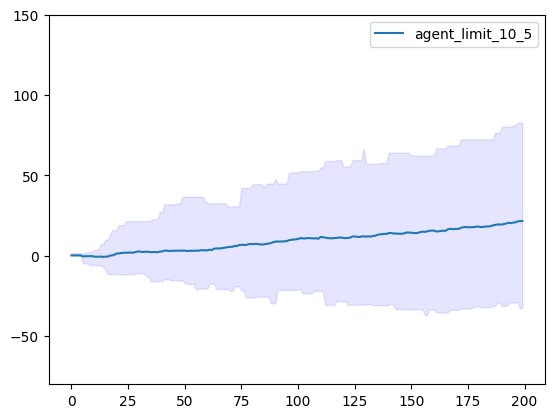

21.596000000000096
agent_limit_25


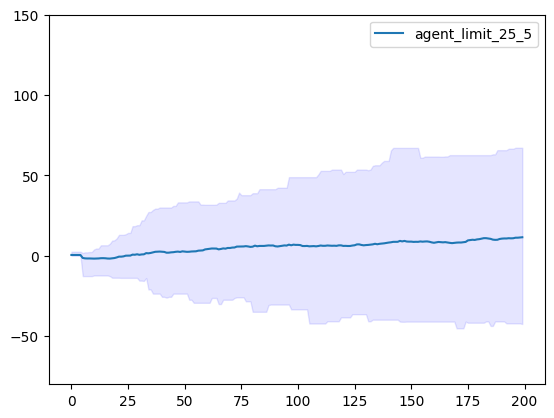

11.492999999999995
agent_limit_50


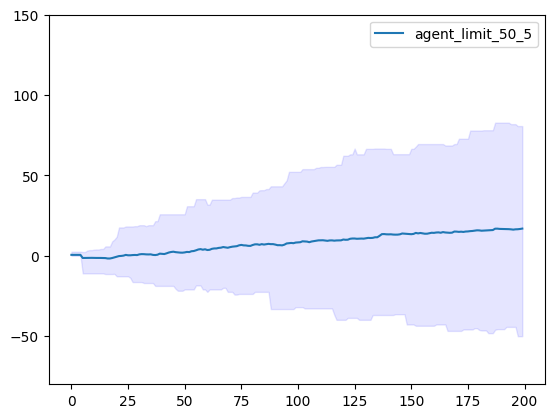

16.879999999999825
agent_limit_100


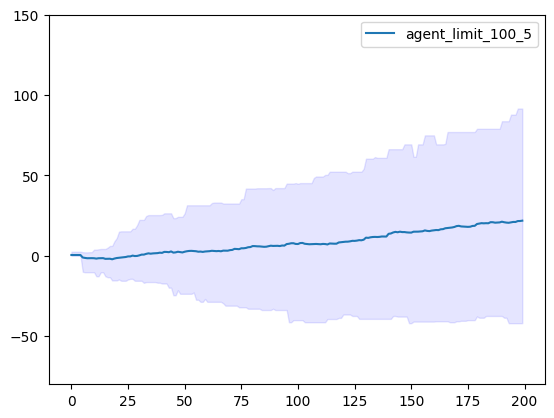

21.809999999999945


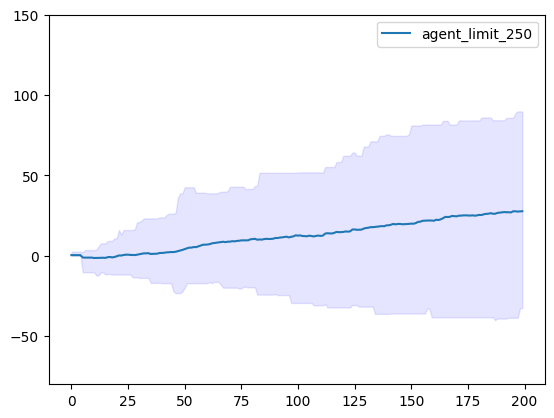

27.704000000000004


In [307]:
for i in range(4):
    name = agent_names[3 - i]
    print(name)
    relevant_info_5 = all_results_limited[name + "_5"]
#     relevant_info_10 = all_results_limited[name + "_10"]
    
    mean_5, q_l, q_u = draw_mean_quantile(relevant_info_5, 'return_5', 0.95, x=200, title=name + "_5", y_lim=[-80, 150]);
    print(mean_5[-1])
#     mean_10, q_l, q_u = draw_mean_quantile(relevant_info_10, 'return_10', 0.95, x=200, title=name + "_10");

mean_5, q_l, q_u = draw_mean_quantile(all_tests_5, 'return_5', 0.95, x=200, title='agent_limit_250', y_lim=[-80, 150]);
print(mean_5[-1])

agent_limit_10


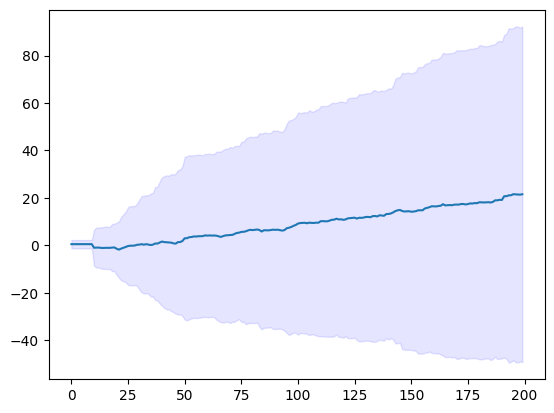

0.016585656345963318
agent_limit_25


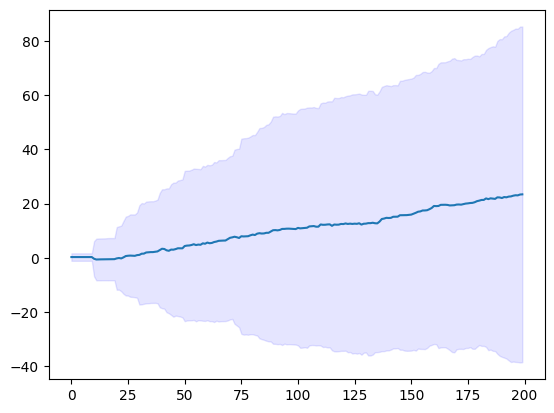

0.023502406030814375
agent_limit_50


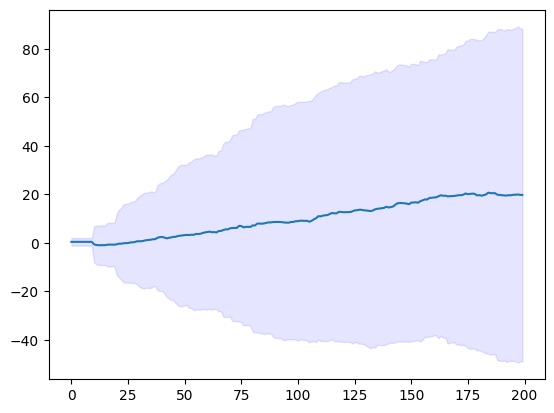

0.01610766135478268
agent_limit_100


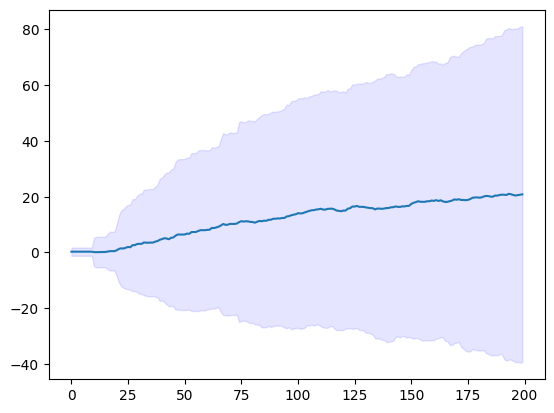

0.02207859861474116


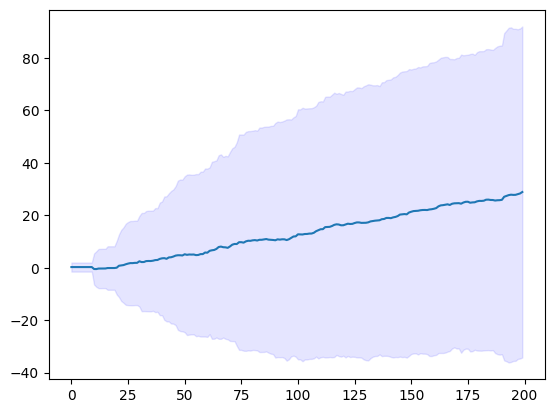

0.027821654181184156


In [308]:
for i in range(4):
    name = agent_names[3 - i]
    print(name)
#     relevant_info_5 = all_results_limited[name + "_5"]
    relevant_info_10 = all_results_limited[name + "_10"]
    
#     mean_5, q_l, q_u = draw_mean_quantile(relevant_info_5, 'return_5', 0.95, x=200, title=name + "_5", y_lim=[-80, 150]);
    mean_10, v = draw_mean_variance(relevant_info_10, 'return_10', x=200);
    print(mean_10[-1]/v[-1])
mean_10, v = draw_mean_variance(all_tests_10, 'return_10', x=200);
print(mean_10[-1]/v[-1])

agent_limit_10


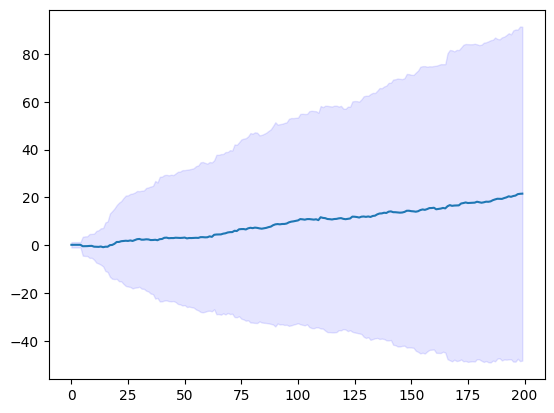

0.017032867534830933
agent_limit_25


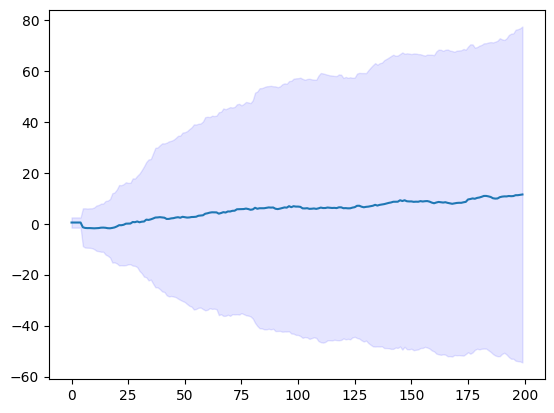

0.010140939736921968
agent_limit_50


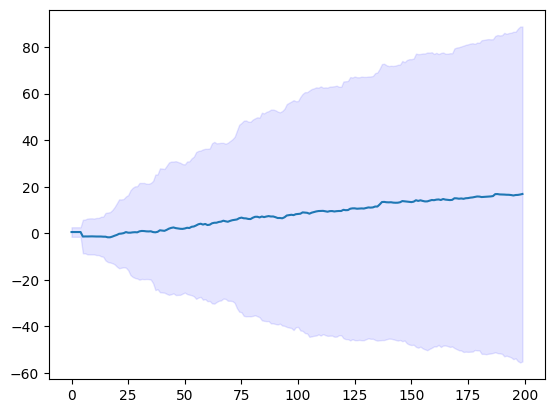

0.012538257320886025
agent_limit_100


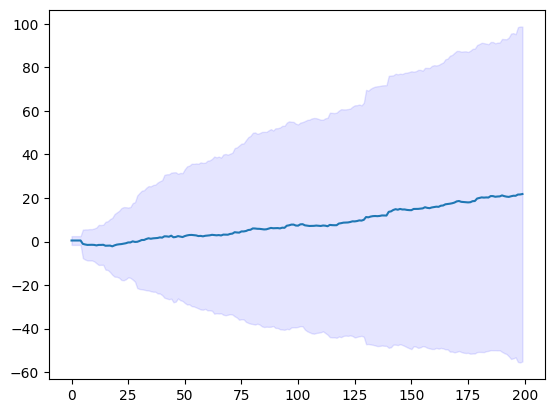

0.01416226985139057


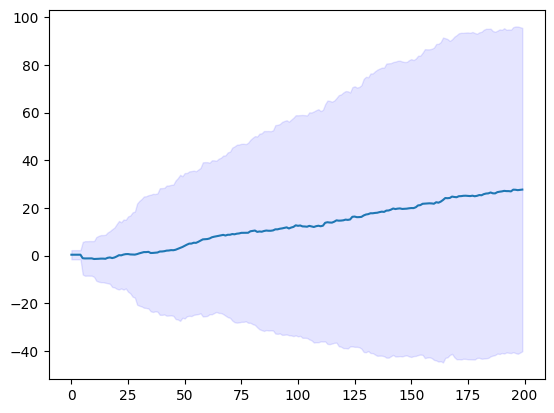

0.023112195448369066


In [309]:
for i in range(4):
    name = agent_names[3 - i]
    print(name)
#     relevant_info_5 = all_results_limited[name + "_5"]
    relevant_info_5 = all_results_limited[name + "_5"]
    
#     mean_5, q_l, q_u = draw_mean_quantile(relevant_info_5, 'return_5', 0.95, x=200, title=name + "_5", y_lim=[-80, 150]);
    mean_5, v = draw_mean_variance(relevant_info_5, 'return_5', x=200);
    print(mean_5[-1]/v[-1])
mean_5, v = draw_mean_variance(all_tests_5, 'return_5', x=200);
print(mean_5[-1]/v[-1])

In [310]:
len(huge_data[0])

250

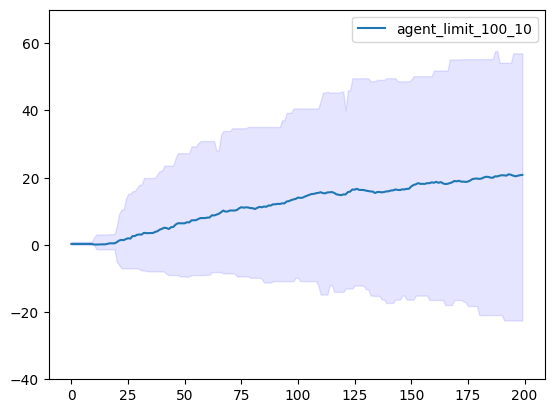

20.83400000000007


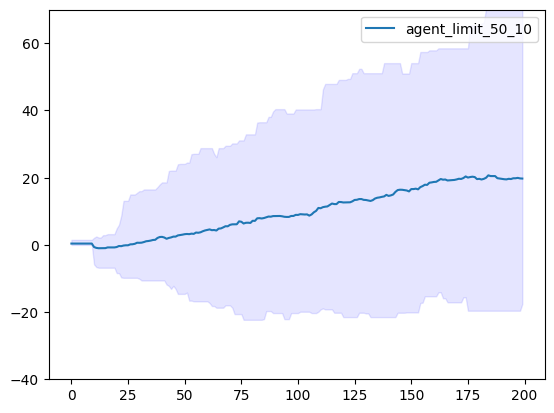

19.73599999999993


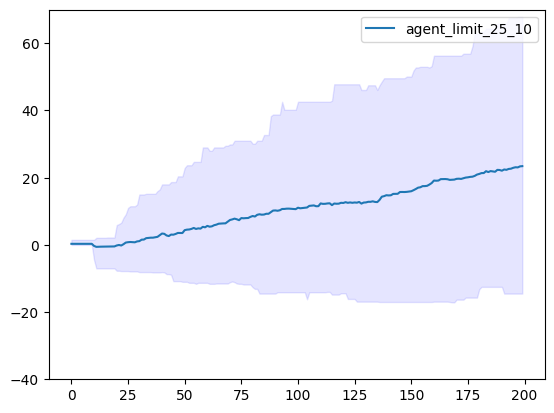

23.431000000000022


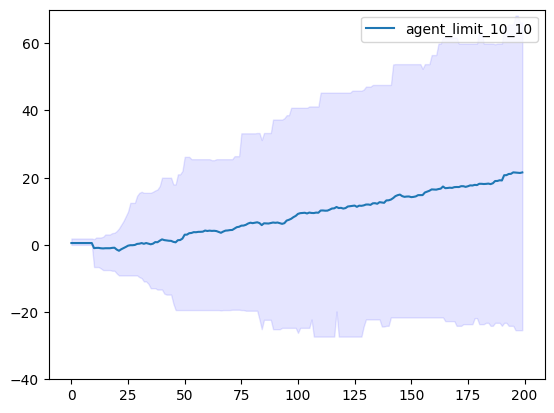

21.56499999999994


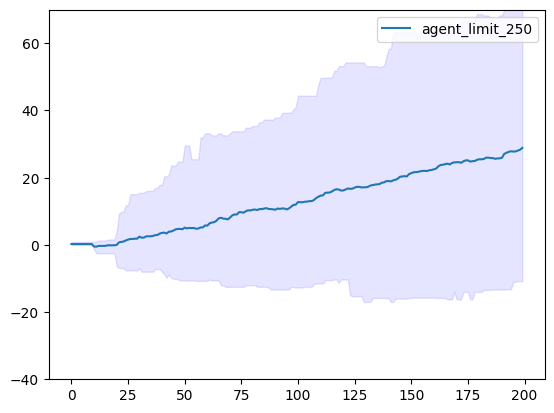

28.875999999999994


In [311]:
for i in range(4):
    name = agent_names[i]
#     relevant_info_5 = all_results_limited[name + "_5"]
    relevant_info_10 = all_results_limited[name + "_10"]
    
#     mean_5, q_l, q_u = draw_mean_quantile(relevant_info_5, 'return_5', 0.95, x=200, title=name + "_5", y_lim=[-80, 150]);
    mean_10, q_l, q_u = draw_mean_quantile(relevant_info_10, 'return_10', 0.9, x=200, title=name + "_10", y_lim=[-40, 70]);
    print(mean_10[-1])
mean_10, q_l, q_u = draw_mean_quantile(all_tests_10, 'return_10', 0.9, x=200, title='agent_limit_250', y_lim=[-40, 70]);
print(mean_10[-1])

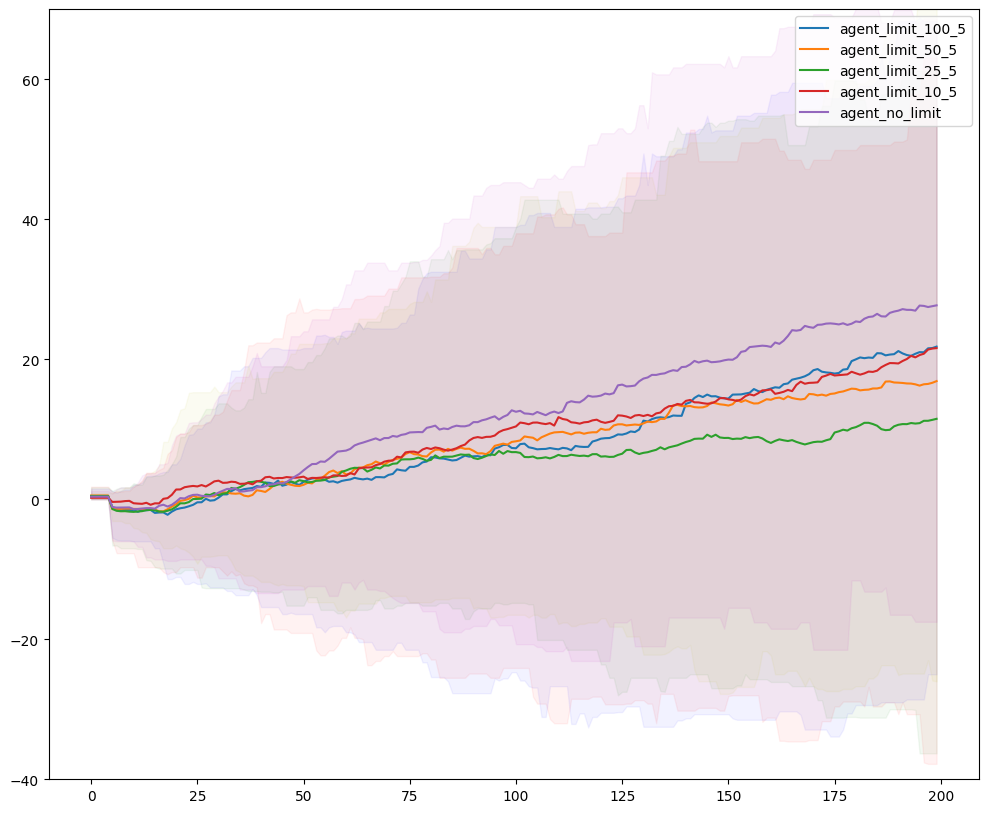

In [312]:
dataset = [all_results_limited[name + "_5"] for name in agent_names]
dataset.append(all_tests_5)

title=[name + "_5" for name in agent_names]
title.append('agent_no_limit')

draw_many_mean_quantile(dataset, 'return_5', 0.9, x=200, title=title, y_lim=[-40, 70])

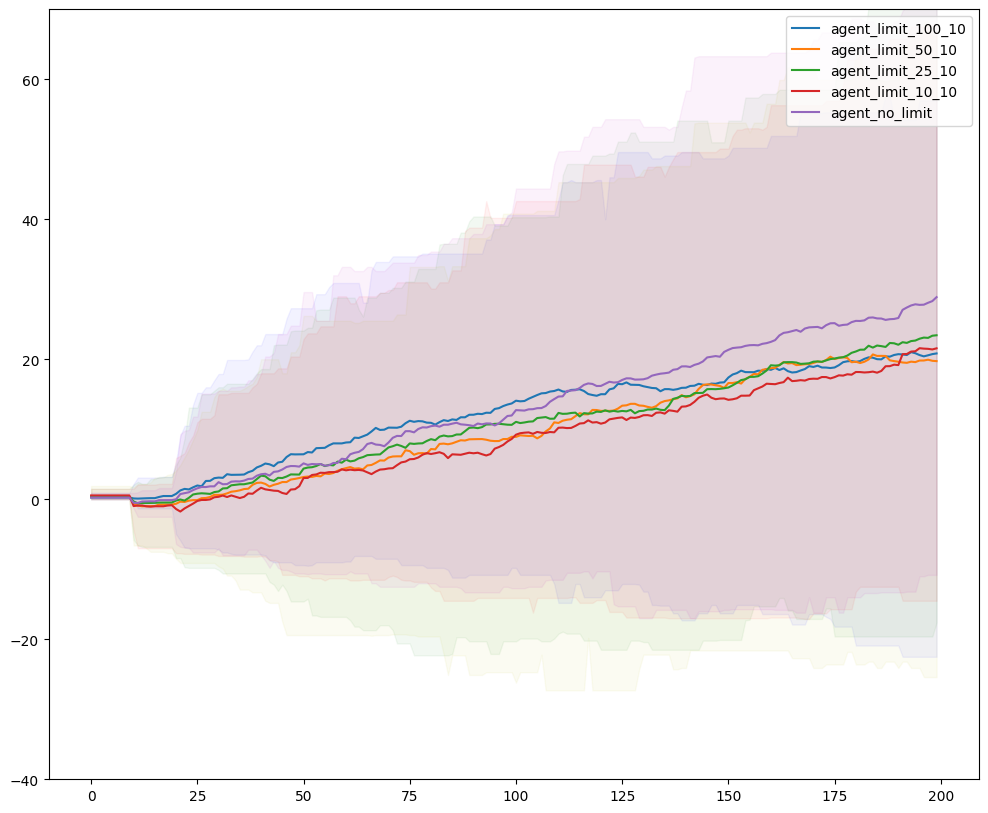

In [313]:
dataset = [all_results_limited[name + "_10"] for name in agent_names]
dataset.append(all_tests_10)

title=[name + "_10" for name in agent_names]
title.append('agent_no_limit')

draw_many_mean_quantile(dataset, 'return_10', 0.9, x=200, title=title, y_lim=[-40, 70])

# Live prediction accuracy

In [335]:
shift_percentage['huge_data'] = [(1, 0.0004), (5, 0.001), (10, 0.0017)]

In [340]:
limited_results_10[0][0]

Trader123218

In [382]:
def fix_ids(predictions):
    ids = []

    cur_id = 0
    last_prediction = 90

    for i in range(len(predictions)):
        if predictions[i] != last_prediction:
            ids.append(cur_id)
            cur_id+=5
            last_prediction = predictions[i]
        elif predictions[i] == last_prediction:
            ids.append(cur_id)
            cur_id+=1
            
    return ids

In [443]:
cur_agent_5.FC.info.prices[list(cur_agent_5.FC.info.prices.keys())[0]][199]

200.05

In [442]:
cur_agent_5.market.price()

200.05

agent_limit_100 lag 5 - 0.6283537595230209
agent_limit_100 lag 10 - 0.3895211509555508


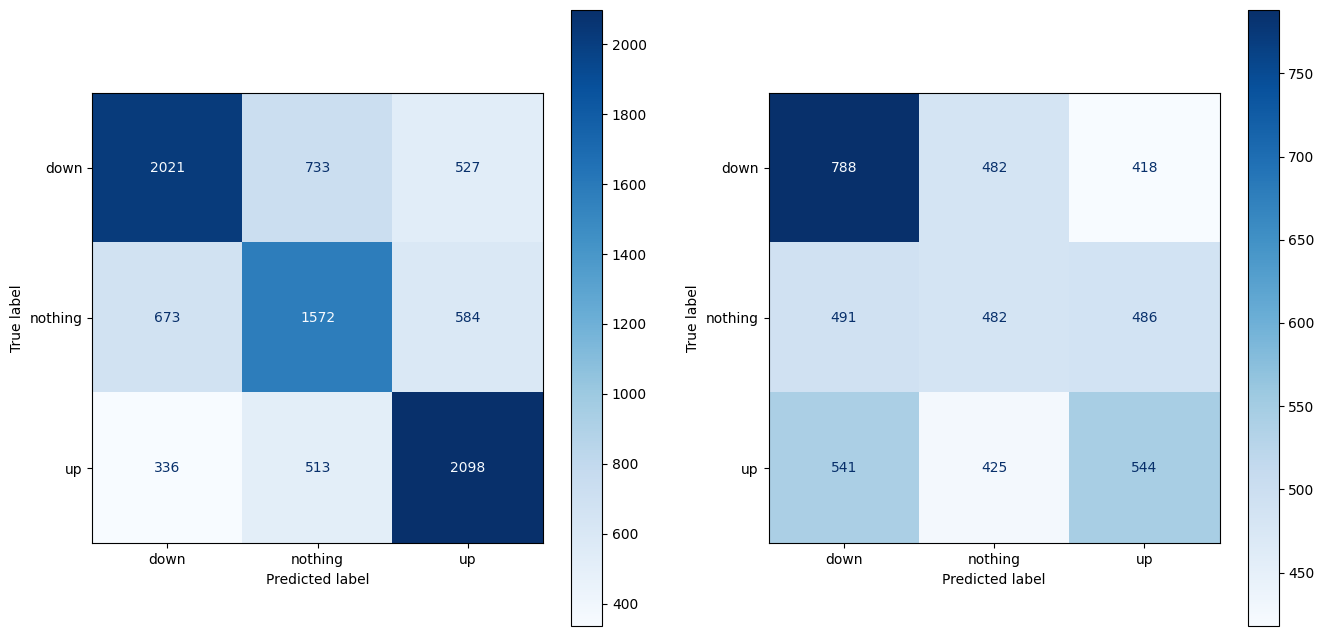

agent_limit_50 lag 5 - 0.6037327870718107
agent_limit_50 lag 10 - 0.4146341463414634


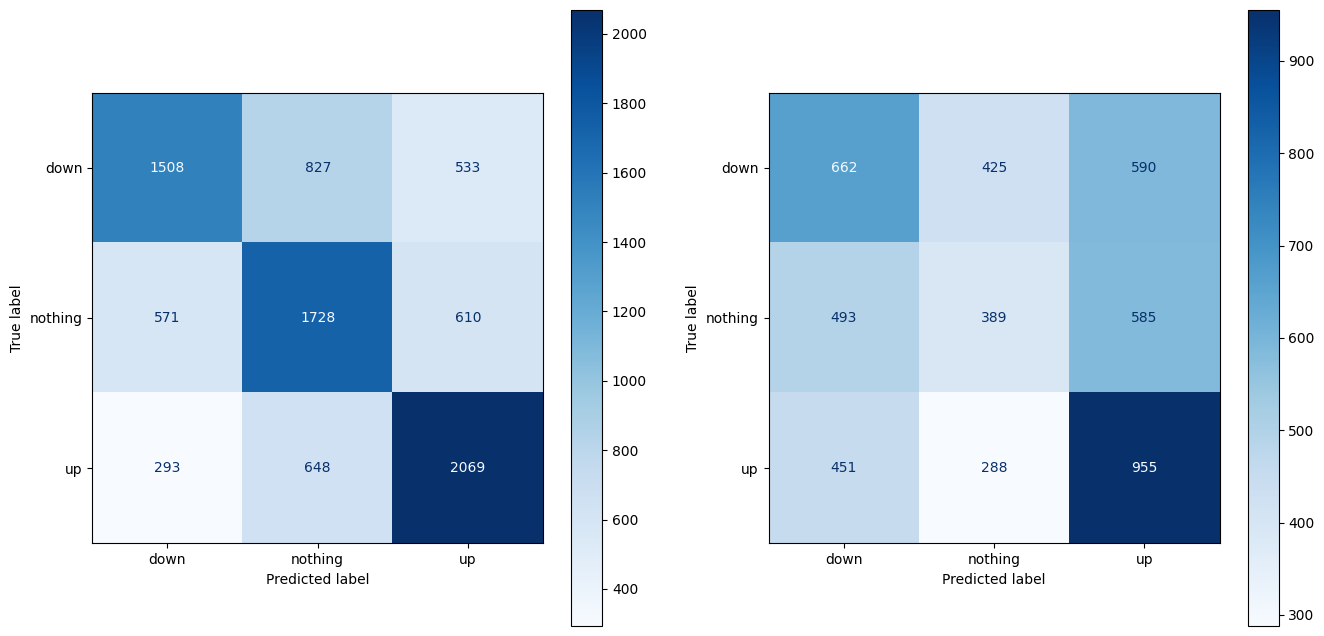

agent_limit_25 lag 5 - 0.5861728395061728
agent_limit_25 lag 10 - 0.40368895409767347


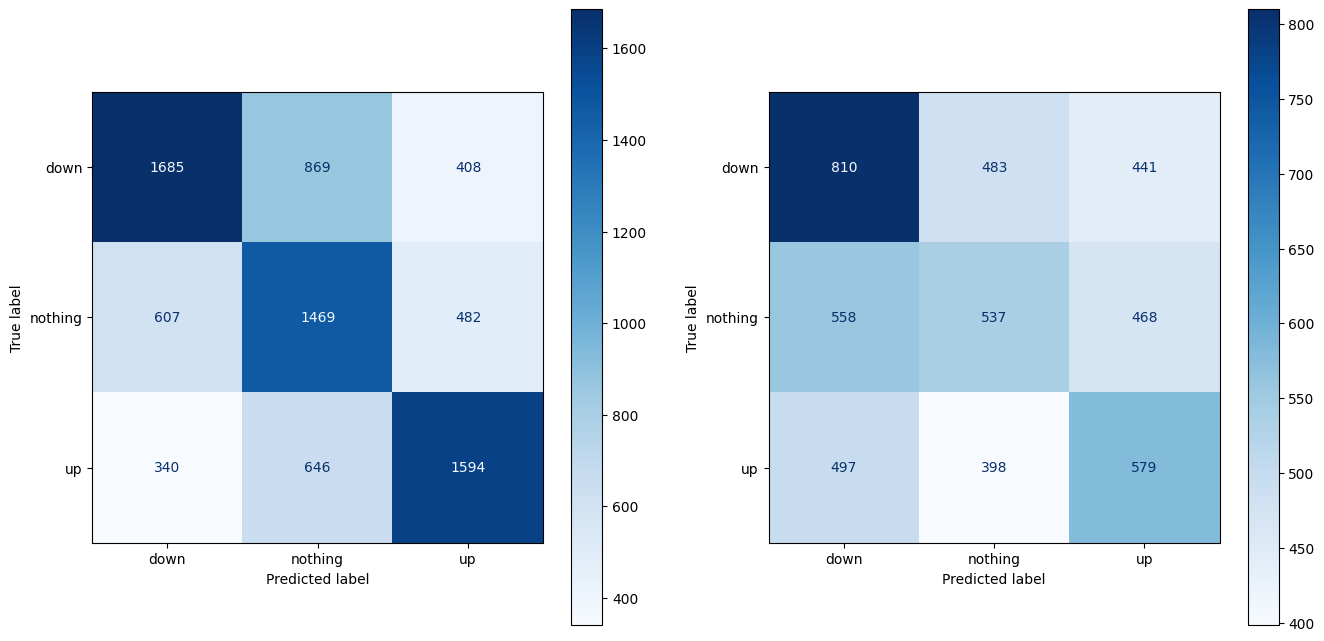

agent_limit_10 lag 5 - 0.5978619356306153
agent_limit_10 lag 10 - 0.42166344294003866


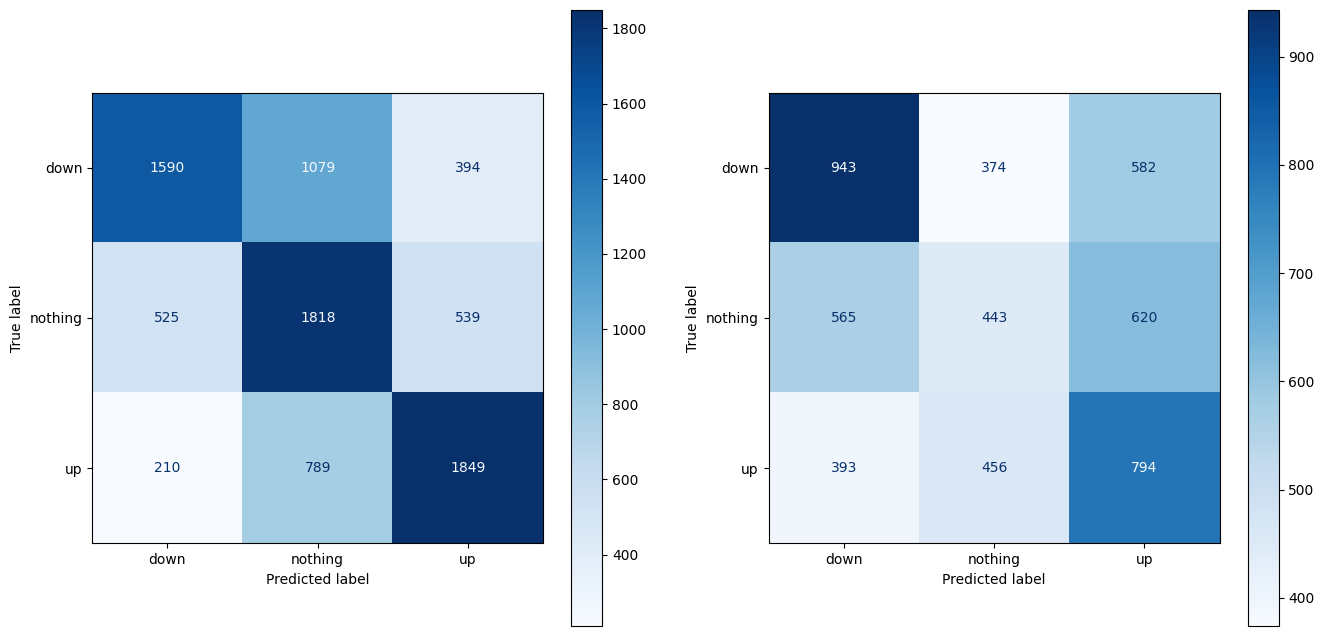

In [444]:
agent_names = ['agent_limit_100', 'agent_limit_50', 'agent_limit_25', 'agent_limit_10']

for k in range(4):
    limited_test_results_5 = limited_results_5[k]
    limited_test_results_10 = limited_results_10[k]
    
    all_differences_5 = []
    all_differences_10 = []
    
    all_predictions_5 = []
    all_predictions_10 = []
    
    for agent_index in range(100):

        cur_agent_5 = limited_test_results_5[agent_index]
        cur_agent_10 = limited_test_results_10[agent_index]
        
        prices_5 = cur_agent_5.FC.info.prices[list(cur_agent_5.FC.info.prices.keys())[0]]
        prices_10 = cur_agent_10.FC.info.prices[list(cur_agent_10.FC.info.prices.keys())[0]]
        
        ids_5 = fix_ids(cur_agent_5.predictions)
        ids_10 = fix_ids(cur_agent_10.predictions)
        
        differences_5 = []
        differences_10 = []
        
        cut_indexes_5 = 0
        cut_indexes_10 = 0

        for indx in ids_5:
            
#             cur_indx = len(prices_5) - indx - 1
            
            if indx + 5 > 199:
                cut_indexes_5 += 1
                continue
            
            cur_difference = (prices_5[indx + 5] - prices_5[indx]) / prices_5[indx]

            if cur_difference < -1 * (shift_percentage['huge_data'][1][1]):
                differences_5.append(0)
#                 differences_5.append(2)

            elif cur_difference > (shift_percentage['huge_data'][1][1]):
                differences_5.append(2)
#                 differences_5.append(0)

            else: 
                differences_5.append(1)
            
            
        for indx in ids_10:
            
            cur_indx = len(prices_10) - indx - 1
            
            if indx + 10 > 199:
                cut_indexes_10 += 1
                continue
            
            cur_difference = (prices_10[indx + 10] - prices_10[indx]) / prices_10[indx]

            if cur_difference < -1 * (shift_percentage['huge_data'][2][1]):
                differences_10.append(0)

            elif cur_difference > (shift_percentage['huge_data'][2][1]):
                differences_10.append(2)

            else:
                differences_10.append(1)
        
#         print(len(prices_5), len(cur_agent_5.predictions), cur_agent_5.timing, cur_agent_5.last_move)
#         print(len(prices_10), len(cur_agent_10.predictions), cur_agent_10.timing, cur_agent_10.last_move)
        
        predictions_5 = cur_agent_5.predictions
        predictions_10 = cur_agent_10.predictions
    
        if cut_indexes_5 > 0:
            predictions_5 = cur_agent_5.predictions[:-cut_indexes_5].copy()
            
        if cut_indexes_10 > 0:
            predictions_10 = cur_agent_10.predictions[:-cut_indexes_10].copy()
    
#         print(len(differences_5), len(cur_agent_5.predictions[:-cut_indexes_5]))
#         print(len(differences_10), len(cur_agent_10.predictions))
#         print(cut_indexes_5, cut_indexes_10)

        all_differences_5 = all_differences_5 + differences_5
        all_differences_10 = all_differences_10 + differences_10
        
        all_predictions_5 = all_predictions_5 + predictions_5
        all_predictions_10 = all_predictions_10 + predictions_10
    
    fig, ax = plt.subplots(1, 2, figsize=[16, 8]) 
    
    print(agent_names[k], 'lag 5 -', accuracy_score(all_differences_5, all_predictions_5))
    
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_differences_5, all_predictions_5), #/confusion_matrix(y_test, predictions).sum(),
                                display_labels=['down', 'nothing', 'up'])
    disp.plot(cmap=plt.cm.Blues, ax=ax[0])
#     plt.show()
    
    print(agent_names[k], 'lag 10 -',accuracy_score(all_differences_10, all_predictions_10))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_differences_10, all_predictions_10), #/confusion_matrix(y_test, predictions).sum(),
                                display_labels=['down', 'nothing', 'up'])
    disp.plot(cmap=plt.cm.Blues, ax=ax[1])
    plt.show()

agent_no_limit lag 5 - 0.6059925093632959
agent_no_limit lag 10 - 0.40616966580976865


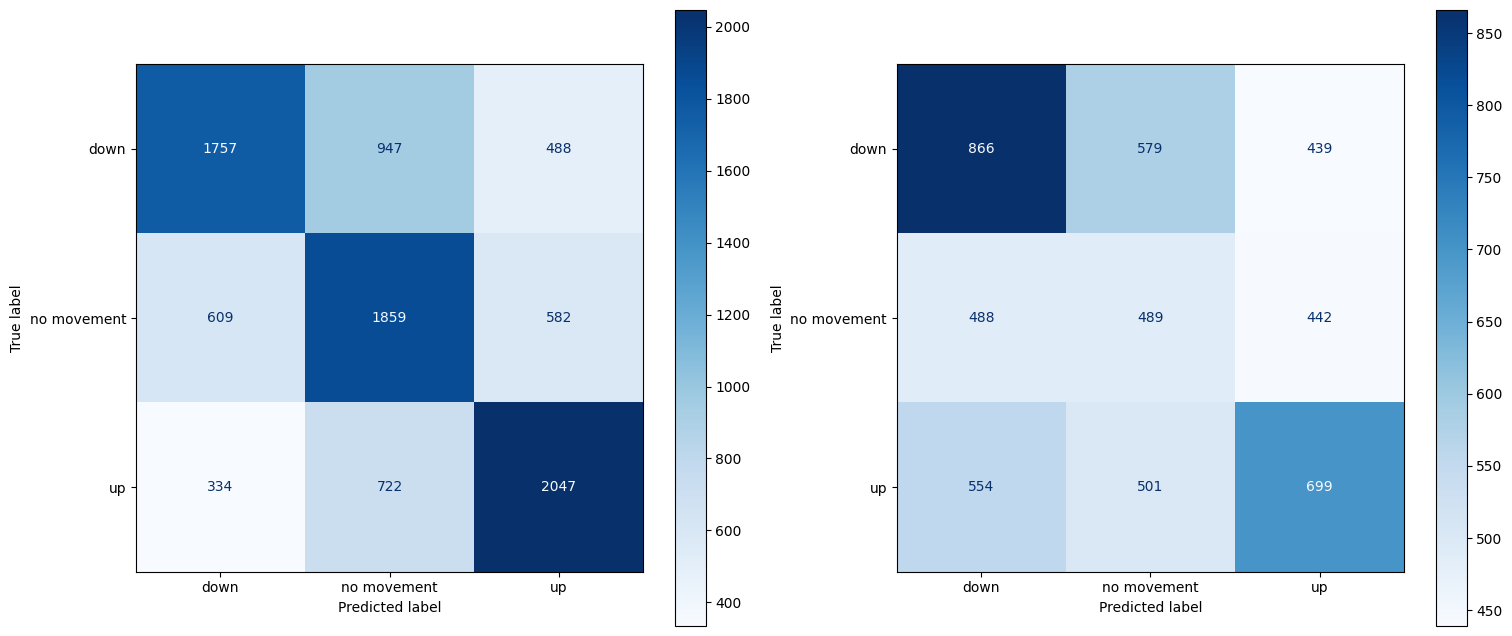

In [463]:
# test_results_5

agent_names_unlimited = ['agent_no_limit']

for k in range(1):
    limited_test_results_5 = test_results_5
    limited_test_results_10 = test_results_10
    
    all_differences_5 = []
    all_differences_10 = []
    
    all_predictions_5 = []
    all_predictions_10 = []
    
    for agent_index in range(100):

        cur_agent_5 = limited_test_results_5[agent_index]
        cur_agent_10 = limited_test_results_10[agent_index]
        
        prices_5 = cur_agent_5.FC.info.prices[list(cur_agent_5.FC.info.prices.keys())[0]]
        prices_10 = cur_agent_10.FC.info.prices[list(cur_agent_10.FC.info.prices.keys())[0]]
        
        ids_5 = fix_ids(cur_agent_5.predictions)
        ids_10 = fix_ids(cur_agent_10.predictions)
        
        differences_5 = []
        differences_10 = []
        
        cut_indexes_5 = 0
        cut_indexes_10 = 0

        for indx in ids_5:
            
#             cur_indx = len(prices_5) - indx - 1
            
            if indx + 5 > 199:
                cut_indexes_5 += 1
                continue
            
            cur_difference = (prices_5[indx + 5] - prices_5[indx]) / prices_5[indx]

            if cur_difference < -1 * (shift_percentage['huge_data'][1][1]):
                differences_5.append(0)
#                 differences_5.append(2)

            elif cur_difference > (shift_percentage['huge_data'][1][1]):
                differences_5.append(2)
#                 differences_5.append(0)

            else: 
                differences_5.append(1)
            
            
        for indx in ids_10:
            
            cur_indx = len(prices_10) - indx - 1
            
            if indx + 10 > 199:
                cut_indexes_10 += 1
                continue
            
            cur_difference = (prices_10[indx + 10] - prices_10[indx]) / prices_10[indx]

            if cur_difference < -1 * (shift_percentage['huge_data'][2][1]):
                differences_10.append(0)

            elif cur_difference > (shift_percentage['huge_data'][2][1]):
                differences_10.append(2)

            else:
                differences_10.append(1)
        
#         print(len(prices_5), len(cur_agent_5.predictions), cur_agent_5.timing, cur_agent_5.last_move)
#         print(len(prices_10), len(cur_agent_10.predictions), cur_agent_10.timing, cur_agent_10.last_move)
        
        predictions_5 = cur_agent_5.predictions
        predictions_10 = cur_agent_10.predictions
    
        if cut_indexes_5 > 0:
            predictions_5 = cur_agent_5.predictions[:-cut_indexes_5].copy()
            
        if cut_indexes_10 > 0:
            predictions_10 = cur_agent_10.predictions[:-cut_indexes_10].copy()
    
#         print(len(differences_5), len(cur_agent_5.predictions[:-cut_indexes_5]))
#         print(len(differences_10), len(cur_agent_10.predictions))
#         print(cut_indexes_5, cut_indexes_10)

        all_differences_5 = all_differences_5 + differences_5
        all_differences_10 = all_differences_10 + differences_10
        
        all_predictions_5 = all_predictions_5 + predictions_5
        all_predictions_10 = all_predictions_10 + predictions_10
    
    fig, ax = plt.subplots(1, 2, figsize=[18, 8]) 
    
    print(agent_names_unlimited[k], 'lag 5 -', accuracy_score(all_differences_5, all_predictions_5))
    
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_differences_5, all_predictions_5), #/confusion_matrix(y_test, predictions).sum(),
                                display_labels=['down', 'no movement', 'up'])
    disp.plot(cmap=plt.cm.Blues, ax=ax[0])
#     plt.show()
    
    print(agent_names_unlimited[k], 'lag 10 -',accuracy_score(all_differences_10, all_predictions_10))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_differences_10, all_predictions_10), #/confusion_matrix(y_test, predictions).sum(),
                                display_labels=['down', 'no movement', 'up'])
    disp.plot(cmap=plt.cm.Blues, ax=ax[1])
    plt.show()

In [425]:
cur_difference = (prices_5[199] - prices_5[199 - 5]) / prices_5[199]
cur_difference_s = (prices_5[194] - prices_5[194 + 5]) / prices_5[194]

In [437]:
test_2[-5:]

[-0.002255639097744304,
 -0.00553180789539837,
 0.004751187796949181,
 -0.006532663316582972,
 0.00099850224663014]

In [409]:
test_agent = limited_results_5[0][99]

prices_5 = test_agent.FC.info.prices[list(test_agent.FC.info.prices.keys())[0]]
predictions = test_agent.predictions

ids_5 = 

In [410]:
test_exchange = test_agent.market

transactions = pd.DataFrame(test_exchange.transactions.transactions, columns=['id', 'price', 'qty', 'side', 'trader_id'])

# if max_iteration >= 0:
#     transactions = transactions[transactions['id'] <= max_iteration]

agent_transactions = transactions[transactions['trader_id'] == test_agent]

In [413]:
fix_ids(predictions)

[0,
 5,
 6,
 7,
 8,
 13,
 14,
 15,
 16,
 17,
 22,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 45,
 50,
 51,
 56,
 57,
 58,
 59,
 64,
 65,
 70,
 71,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 93,
 98,
 99,
 100,
 101,
 102,
 107,
 108,
 113,
 114,
 115,
 116,
 117,
 122,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 138,
 143,
 144,
 149,
 150,
 151,
 156,
 157,
 158,
 159,
 160,
 161,
 166,
 171,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 189,
 190,
 195]

In [414]:
predictions

[1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 1]

In [411]:
agent_transactions

id  price  qty side                  trader_id
190     8  200.1   10  bid  Trader86496 (ModelTrader)
501    17  201.1    1  ask  Trader86496 (ModelTrader)
502    17  199.6    2  ask  Trader86496 (ModelTrader)
503    17  199.5    3  ask  Trader86496 (ModelTrader)
504    17  199.4    4  ask  Trader86496 (ModelTrader)
615    22  200.3   10  ask  Trader86496 (ModelTrader)
1147   40  200.1    2  bid  Trader86496 (ModelTrader)
1148   40  200.3    8  bid  Trader86496 (ModelTrader)
1306   45  200.0    1  ask  Trader86496 (ModelTrader)
1307   45  200.0    9  ask  Trader86496 (ModelTrader)
1470   51  199.8    2  bid  Trader86496 (ModelTrader)
1471   51  199.8    8  bid  Trader86496 (ModelTrader)
1664   59  200.1    5  bid  Trader86496 (ModelTrader)
1665   59  200.2    5  bid  Trader86496 (ModelTrader)
1822   65  200.7    1  ask  Trader86496 (ModelTrader)
1823   65  200.7    1  ask  Trader86496 (ModelTrader)
1824   65  200.7    4  ask  Trader86496 (ModelTrader)
1825   65  200.7    1  ask  Trader86496 (ModelTrader)
1826   65  200.6    3  ask  Trader86496 (ModelTrader)
1954   71  200.9    1  ask  Trader86496 (ModelTrader)
1955   71  200.7    9  ask  Trader86496 (ModelTrader)
2460   88  198.6   10  bid  Trader86496 (ModelTrader)
2640   93  198.4   10  ask  Trader86496 (ModelTrader)
2940  102  197.4   10  bid  Trader86496 (ModelTrader)
3107  108  197.5   10  bid  Trader86496 (ModelTrader)
3386  117  198.3   10  ask  Trader86496 (ModelTrader)
3517  122  198.7    2  bid  Trader86496 (ModelTrader)
3518  122  199.1    8  bid  Trader86496 (ModelTrader)
3856  133  199.7   10  ask  Trader86496 (ModelTrader)
4035  138  201.2    5  bid  Trader86496 (ModelTrader)
4036  138  201.4    1  bid  Trader86496 (ModelTrader)
4037  138  201.4    4  bid  Trader86496 (ModelTrader)
4222  144  200.9    4  ask  Trader86496 (ModelTrader)
4223  144  200.9    5  ask  Trader86496 (ModelTrader)
4224  144  200.7    1  ask  Trader86496 (ModelTrader)
4404  151  201.5    4  bid  Trader86496 (ModelTrader)
4405  151  201.7    6  bid  Trader86496 (ModelTrader)
4696  161  202.9    1  ask  Trader86496 (ModelTrader)
4697  161  202.8    4  ask  Trader86496 (ModelTrader)
4698  161  202.1    4  ask  Trader86496 (ModelTrader)
4699  161  201.7    1  ask  Trader86496 (ModelTrader)
5033  171  204.2    3  bid  Trader86496 (ModelTrader)
5034  171  204.6    7  bid  Trader86496 (ModelTrader)
5429  184  205.0   10  ask  Trader86496 (ModelTrader)
5580  190  206.0    5  bid  Trader86496 (ModelTrader)
5581  190  206.0    5  bid  Trader86496 (ModelTrader)
5678  195  205.7   10  ask  Trader86496 (ModelTrader)

In [ ]:
for i in range(len(ids)):
    cur_price = prices_5[ids[i]]
    future_price = prices_5[ids[i] + 5]
    

In [376]:
print(len(predictions), len(ids))

96 96


In [378]:
len(prices_5)

200

In [334]:
agent_5.FC.info.prices[list(agent_5.FC.info.prices.keys())[0]][:5]

[200.0, 199.95, 199.8, 200.0, 199.8]

In [ ]:
agent_5.FC.info.prices[list(agent_5.FC.info.prices.keys())[0]]

In [332]:
list(agent_5.FC.info.prices.keys())[0]

1009

# NN classifier

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [221]:
class trainDataset():
    def __init__(self, data_x, data_y, device="cuda"):
        self.data = data_x
        self.device = device
        self.labels = data_y
        
    def __getitem__(self, x):
        data_x = self.data.iloc[x]
        data_y = [self.labels.iloc[x]]
        
        data = torch.Tensor(data_x.values).to(self.device)
        label = torch.Tensor(data_y).type(torch.LongTensor).to(self.device)
        
        return data, label
    
    def __len__(self):
        return len(self.labels)

In [139]:
class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()
        self.lstm = nn.LSTM(17, 30, 3, batch_first=True)
        self.linear = nn.Linear(17, 20)
        self.linear2 = nn.Linear(20, 3)
        self.sigmoid = nn.Sigmoid()
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        h_0 = torch.zeros(3, x.size(0), 30).requires_grad_().to(device)
        c_0 = torch.zeros(3, x.size(0), 30).requires_grad_().to(device)
        
        output, (h_index, c_index) = self.lstm(x, (h_0, c_0))
            
        output = self.linear(output)
        
        output = self.relu(output)
        
        output = self.linear2(output)
        
        output = self.sigmoid(output)
        
        return output

In [248]:
class SimpleModel(nn.Module):
    def __init__(self, n_epoch=1):
        self.n_epoch = n_epoch
        
        super(SimpleModel, self).__init__()
        
        self.linear = nn.Linear(16, 30)
        self.linear2 = nn.Linear(30, 20)
        self.linear3 = nn.Linear(20, 10)
        self.linear4 = nn.Linear(10, 3)
        
#         self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
#         x = self.sigmoid(x)
        
        return x
    
    def fit(self, data_x, data_y):
        
        train_ds = trainDataset(data_x, data_y)
        train_dl = DataLoader(train_ds, batch_size = 32, shuffle = False)
        
        optimizer = torch.optim.Adam(self.parameters(), lr=0.00001)
        
        loss_f = nn.CrossEntropyLoss()
        
        for i in range(self.n_epoch):
            for el in tqdm(train_dl):
                
                data = el[0]
                target = el[1].squeeze()

                y_pred = self(data)
                
                optimizer.zero_grad()
#                 print(y_pred, target)
                loss = loss_f(y_pred, target)

                loss.backward()

                optimizer.step()
        
    def predict(self, x):
        self.eval()
        
        train_ds = torch.Tensor(x.values).to(device)
        results = torch.argmax(self(train_ds).detach().cpu(), dim=1)
        
        print(results)
        
        return results

In [211]:
data_xy = prepare_huge_data(huge_data, shift=5, percentage=0.001)

shift_percentage = {}
shift_percentage['huge_data'] = [(1, 0.00000001), (5, 0.001), (10, 0.0015)]
shift_percentage['huge_data_no_mm'] = [(1, 0.001), (5, 0.0025), (10, 0.003)]
shift_percentage['huge_data_undervalued'] = [(1, 0.0008), (5, 0.0025), (10, 0.004)]
shift_percentage['huge_data_undervalued_no_mm'] = [(1, 0.00105), (5, 0.003), (10, 0.0042)]

In [212]:
data_xy

index  bid_ask_volume_imbalance_1  bid_ask_volume_imbalance_3  \
0       20                   -0.692308                    0.627706   
1       21                    0.937500                    0.839623   
2       22                    0.744076                    0.542857   
3       23                   -0.520000                   -0.384615   
4       24                   -0.428571                    0.642553   
..     ...                         ...                         ...   
220    240                   -0.394495                   -0.306452   
221    241                   -0.367442                   -0.274194   
222    242                   -0.489130                   -0.333333   
223    243                   -0.687805                   -0.521008   
224    244                   -0.847826                   -0.648148   

     bid_ask_volume_imbalance_5  bid_ask_volume_imbalance_10  \
0                      0.568000                     0.365994   
1                      0.562500                     0.441270   
2                      0.540146                     0.399433   
3                     -0.461538                     0.406061   
4                      0.562500                     0.384146   
..                          ...                          ...   
220                   -0.137931                     0.045131   
221                   -0.103679                     0.108374   
222                   -0.189189                     0.100775   
223                   -0.330961                    -0.024752   
224                   -0.312057                    -0.073684   

     sign_transaction_volume_1  sign_transaction_volume_5  \
0                     0.081081                   0.017857   
1                     0.128205                  -0.009174   
2                    -0.255814                  -0.008929   
3                     0.200000                   0.004219   
4                     0.459459                   0.116505   
..                         ...                        ...   
220                  -0.225806                  -0.281609   
221                  -0.111111                  -0.270718   
222                  -0.105263                  -0.297872   
223                  -0.538462                  -0.323308   
224                  -0.386667                  -0.291553   

     sign_transaction_volume_10  sign_transaction_volume_20  \
0                      0.045726                    0.098117   
1                      0.013917                    0.098814   
2                      0.004149                    0.095477   
3                      0.022587                    0.103935   
4                      0.063181                    0.117467   
..                          ...                         ...   
220                   -0.357911                   -0.267393   
221                   -0.354938                   -0.283930   
222                   -0.303835                   -0.293269   
223                   -0.334243                   -0.326036   
224                   -0.316456                   -0.347418   

     all_transaction_volume_1  ...  dividends_previous_divided  fundamental_v  \
0                          37  ...                    1.002037     201.158995   
1                          39  ...                    1.002821     201.416636   
2                          43  ...                    0.998929     201.433938   
3                          50  ...                    0.997793     201.005425   
4                          37  ...                    0.998393     201.076365   
..                        ...  ...                         ...            ...   
220                        62  ...                    0.988717     191.020114   
221                        63  ...                    0.988456     190.821523   
222                        76  ...                    0.988028     190.541202   
223                        91  ...                    0.986579     190.261754   
224           

In [178]:
device = "cuda"

In [249]:
# datasets
all_tested_data = [huge_data, huge_data_no_mm, huge_data_undervalued, huge_data_undervalued_no_mm] #, huge_data_no_mm, huge_data_undervalued, huge_data_undervalued_no_mm] # [huge_data]
all_tested_data_names = ['huge_data', 'huge_data_no_mm', 'huge_data_undervalued', 'huge_data_undervalued_no_mm'] #, 'huge_data_no_mm', 'huge_data_undervalued', 'huge_data_undervalued_no_mm'] # [huge_data]

# Testing xgb for different shifts
shift_percentage = {}
shift_percentage['huge_data'] = [(1, 0.00000001), (5, 0.001), (10, 0.0015)]
shift_percentage['huge_data_no_mm'] = [(1, 0.001), (5, 0.0025), (10, 0.003)]
shift_percentage['huge_data_undervalued'] = [(1, 0.0008), (5, 0.0025), (10, 0.004)]
shift_percentage['huge_data_undervalued_no_mm'] = [(1, 0.00105), (5, 0.003), (10, 0.0042)]

#[huge_data, huge_data_no_mm, huge_data_undervalued, huge_data_undervalued_no_mm]

all_train_results = pd.DataFrame()

all_train_scores = []
all_test_scores = []

current_loop_models = []

model = SimpleModel().to(device)

for i in range(len(all_tested_data)):

    dataset = all_tested_data[i]
    name = all_tested_data_names[i]
    settings = shift_percentage[name]

    train_scores = []
    test_scores = []

    for setting in settings:

        m, acc_train, acc_test = classifier_test(model, dataset, shift=setting[0], percentage=setting[1], silent=True, 
                                                 x_columns=None)

        train_scores.append(round(acc_train, 2))
        test_scores.append(round(acc_test, 2))

        try:
            xgb.plot_importance(m)
        except:
            pass

    all_train_scores.append(train_scores)
    all_test_scores.append(test_scores)

    current_loop_models.append(m)


train_results = pd.DataFrame()

#     draw_importance_xgb(current_loop_models)


for i in range(len(all_tested_data)):
    train_s = all_train_scores[i]
    test_s = all_test_scores[i]

    train_results['accuracy ' + all_tested_data_names[i].replace('huge_', '') + ' ' + 'simple_nn'] = train_s + test_s

    train_results.index = ['shift_1', 'shift_5', 'shift_10'] + ['shift_1_test', 'shift_5_test', 'shift_10_test']

train_results = (train_results.T)[['shift_1', 'shift_1_test', 'shift_5', 'shift_5_test', 'shift_10', 'shift_10_test']]
all_train_results = pd.concat([all_train_results, train_results])

all_train_results

100%|██████████| 1150/1150 [00:12<00:00, 93.27it/s]


tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([1, 1, 1,  ..., 1, 1, 1])


100%|██████████| 225/225 [00:02<00:00, 94.09it/s]


tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([1, 1, 1,  ..., 1, 1, 1])


100%|██████████| 113/113 [00:01<00:00, 88.40it/s]


tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       

100%|██████████| 1150/1150 [00:12<00:00, 92.94it/s]


tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([0, 0, 0,  ..., 0, 0, 0])


100%|██████████| 225/225 [00:02<00:00, 89.66it/s]


tensor([0, 0, 1,  ..., 0, 1, 1])
tensor([0, 0, 0,  ..., 0, 0, 0])


100%|██████████| 113/113 [00:01<00:00, 93.40it/s]


tensor([0, 0, 0,  ..., 0, 1, 0])
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       

100%|██████████| 1150/1150 [00:12<00:00, 93.81it/s]


tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([1, 1, 1,  ..., 1, 1, 1])


100%|██████████| 225/225 [00:02<00:00, 95.85it/s] 


tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([1, 1, 1,  ..., 1, 1, 1])


100%|██████████| 113/113 [00:01<00:00, 98.34it/s]


tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       

100%|██████████| 1150/1150 [00:12<00:00, 91.21it/s]


tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([1, 1, 1,  ..., 1, 1, 1])


100%|██████████| 225/225 [00:02<00:00, 102.07it/s]


tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([1, 1, 1,  ..., 1, 1, 1])


100%|██████████| 113/113 [00:01<00:00, 95.93it/s]

tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       

shift_1  shift_1_test  shift_5  \
accuracy data simple_nn                       0.17          0.16     0.33   
accuracy data_no_mm simple_nn                 0.38          0.38     0.35   
accuracy data_undervalued simple_nn           0.55          0.59     0.60   
accuracy data_undervalued_no_mm simple_nn     0.27          0.28     0.41   

                                           shift_5_test  shift_10  \
accuracy data simple_nn                            0.32      0.29   
accuracy data_no_mm simple_nn                      0.34      0.35   
accuracy data_undervalued simple_nn                0.66      0.62   
accuracy data_undervalued_no_mm simple_nn          0.44      0.45   

                                           shift_10_test  
accuracy data simple_nn                             0.30  
accuracy data_no_mm simple_nn                       0.34  
accuracy data_undervalued simple_nn                 0.66  
accuracy data_undervalued_no_mm simple_nn           0.48

In [ ]:
nn.CrossEntropyLoss

In [77]:
for model_name in models.keys():
    
    try:
        xgb.plot_importance(models[model_name])
        plt.plot()
    except:
        pass

AttributeError: 'list' object has no attribute 'keys'

In [ ]:
all_train_results

In [ ]:
# train_results_logreg = train_results
# train_results_xgb = train_results
# train_results_xgb_depth_3 = train_results

# Experiments + UNEXPECTED results

In [ ]:
data_xy = prepare_data(huge_data, shift=10, percentage=0.000001, two_classes_only=True)
data_y = data_xy['difference']
data_x = data_xy.drop(['future_price', 'index', 'difference'], axis=1)

data_xy['difference'].hist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=99, shuffle=True)

log_model = LogisticRegression(random_state=99)
log_model.fit(X_train, y_train)

predictions = log_model.predict(X_test)

print("accuracy score - ", accuracy_score(y_test, predictions)) #, recall_score(y_test, predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions), #/confusion_matrix(y_test, predictions).sum(),
                            display_labels=['down', 'up'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [45]:
huge_data[0]['price']

0      199.85
1      200.05
2      200.05
3      200.25
4      200.35
        ...  
245    202.65
246    202.50
247    202.15
248    201.85
249    201.95
Name: price, Length: 250, dtype: float64